# Afriat

In [1]:
import warnings
import os
import sys
import gc
import warnings

In [2]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
tardis.config = tardis.config_server

In [3]:
torch.cuda.is_available()

False

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [5]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [6]:
asdp_1 = adata.X.sum()

In [7]:
ratio_true=0.999

from tardis._utils.functions import create_random_mask
mask = create_random_mask(adata.shape[1], ratio_true=ratio_true, seed=2024)
adata.X[:, mask] = 0.0

In [8]:
asdp_2 = adata.X.sum()

In [9]:
mask.sum()/adata.shape[1],  1-asdp_2/asdp_1

(0.999, 0.9993668969837017)

In [10]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|status_control",
        training_set = ["train"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|zone",
        training_set = ["train"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 128,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|time_cat",
        training_set = ["train"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 128,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|mouse",
        training_set = ["train"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 128,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [11]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "status_control",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "time_cat",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "zone",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [12]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['zone', 'status_control', 'time_cat', 'mouse']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"afriat_v2_4_ablation_{ratio_true}"
)

vae.save(
    dir_path,
    overwrite=True,
)

/home/icb/kemal.inecik/work/codes/tardis/tardis/_mymodel.py:81: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(self.adata_manager, n_batch)


W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: r27ofkn6
Name: scruffy-looking-wookie-102
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/r27ofkn6
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240504_155910-r27ofkn6/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `training` set. Number of elements in each group: 2554,3297,9392
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `time_cat` for `training` set. Number of elements in each group: 2554,2577,1669,3426,1642,3375
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `training` set. Number of elements in each group: 4491,10752
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `validation` set. Number of elements in each group: 651,812,2347
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `time_cat` for `validation` set. Number of elements in each group: 651,625,439,864,407,824
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `validation` set. Number of elements in each group: 1093,2717
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:13<2:17:16, 13.75s/it]

Epoch 1/600:   0%|          | 1/600 [00:13<2:17:16, 13.75s/it, v_num=n6_1, total_loss_train=7.23, kl_local_train=24.1]

Epoch 2/600:   0%|          | 1/600 [00:13<2:17:16, 13.75s/it, v_num=n6_1, total_loss_train=7.23, kl_local_train=24.1]

Epoch 2/600:   0%|          | 2/600 [00:26<2:10:25, 13.09s/it, v_num=n6_1, total_loss_train=7.23, kl_local_train=24.1]

Epoch 2/600:   0%|          | 2/600 [00:26<2:10:25, 13.09s/it, v_num=n6_1, total_loss_train=3.64, kl_local_train=36.3]

Epoch 3/600:   0%|          | 2/600 [00:26<2:10:25, 13.09s/it, v_num=n6_1, total_loss_train=3.64, kl_local_train=36.3]

Epoch 3/600:   0%|          | 3/600 [00:39<2:08:21, 12.90s/it, v_num=n6_1, total_loss_train=3.64, kl_local_train=36.3]

Epoch 3/600:   0%|          | 3/600 [00:39<2:08:21, 12.90s/it, v_num=n6_1, total_loss_train=2.93, kl_local_train=26.5]

Epoch 4/600:   0%|          | 3/600 [00:39<2:08:21, 12.90s/it, v_num=n6_1, total_loss_train=2.93, kl_local_train=26.5]

Epoch 4/600:   1%|          | 4/600 [00:51<2:07:13, 12.81s/it, v_num=n6_1, total_loss_train=2.93, kl_local_train=26.5]

Epoch 4/600:   1%|          | 4/600 [00:51<2:07:13, 12.81s/it, v_num=n6_1, total_loss_train=2.68, kl_local_train=14.4]

Epoch 5/600:   1%|          | 4/600 [00:51<2:07:13, 12.81s/it, v_num=n6_1, total_loss_train=2.68, kl_local_train=14.4]

Epoch 5/600:   1%|          | 5/600 [01:04<2:06:42, 12.78s/it, v_num=n6_1, total_loss_train=2.68, kl_local_train=14.4]

Epoch 5/600:   1%|          | 5/600 [01:04<2:06:42, 12.78s/it, v_num=n6_1, total_loss_train=2.5, kl_local_train=12.2] 

Epoch 6/600:   1%|          | 5/600 [01:05<2:06:42, 12.78s/it, v_num=n6_1, total_loss_train=2.5, kl_local_train=12.2]

Epoch 6/600:   1%|          | 6/600 [01:17<2:08:12, 12.95s/it, v_num=n6_1, total_loss_train=2.5, kl_local_train=12.2]

Epoch 6/600:   1%|          | 6/600 [01:17<2:08:12, 12.95s/it, v_num=n6_1, total_loss_train=2.4, kl_local_train=11.4, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0366]

Epoch 7/600:   1%|          | 6/600 [01:17<2:08:12, 12.95s/it, v_num=n6_1, total_loss_train=2.4, kl_local_train=11.4, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0366]

Epoch 7/600:   1%|          | 7/600 [01:29<2:05:01, 12.65s/it, v_num=n6_1, total_loss_train=2.4, kl_local_train=11.4, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0366]

Epoch 7/600:   1%|          | 7/600 [01:29<2:05:01, 12.65s/it, v_num=n6_1, total_loss_train=2.33, kl_local_train=10.3, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0366]

Epoch 8/600:   1%|          | 7/600 [01:29<2:05:01, 12.65s/it, v_num=n6_1, total_loss_train=2.33, kl_local_train=10.3, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0366]

Epoch 8/600:   1%|▏         | 8/600 [01:41<2:02:47, 12.44s/it, v_num=n6_1, total_loss_train=2.33, kl_local_train=10.3, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0366]

Epoch 8/600:   1%|▏         | 8/600 [01:41<2:02:47, 12.44s/it, v_num=n6_1, total_loss_train=10.1, kl_local_train=9.6, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0366] 

Epoch 9/600:   1%|▏         | 8/600 [01:41<2:02:47, 12.44s/it, v_num=n6_1, total_loss_train=10.1, kl_local_train=9.6, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0366]

Epoch 9/600:   2%|▏         | 9/600 [01:53<2:01:19, 12.32s/it, v_num=n6_1, total_loss_train=10.1, kl_local_train=9.6, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0366]

Epoch 9/600:   2%|▏         | 9/600 [01:53<2:01:19, 12.32s/it, v_num=n6_1, total_loss_train=15.6, kl_local_train=44.5, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0366]

Epoch 10/600:   2%|▏         | 9/600 [01:53<2:01:19, 12.32s/it, v_num=n6_1, total_loss_train=15.6, kl_local_train=44.5, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0366]

Epoch 10/600:   2%|▏         | 10/600 [02:05<2:00:33, 12.26s/it, v_num=n6_1, total_loss_train=15.6, kl_local_train=44.5, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0366]

Epoch 10/600:   2%|▏         | 10/600 [02:05<2:00:33, 12.26s/it, v_num=n6_1, total_loss_train=19.5, kl_local_train=68.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0366]

Epoch 11/600:   2%|▏         | 10/600 [02:07<2:00:33, 12.26s/it, v_num=n6_1, total_loss_train=19.5, kl_local_train=68.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0366]

Epoch 11/600:   2%|▏         | 11/600 [02:19<2:03:37, 12.59s/it, v_num=n6_1, total_loss_train=19.5, kl_local_train=68.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0366]

Epoch 11/600:   2%|▏         | 11/600 [02:19<2:03:37, 12.59s/it, v_num=n6_1, total_loss_train=24, kl_local_train=77.6, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.143, metric_mi|time_cat_train=0.074, metric_mi|mouse_train=0.0731]    

Epoch 12/600:   2%|▏         | 11/600 [02:19<2:03:37, 12.59s/it, v_num=n6_1, total_loss_train=24, kl_local_train=77.6, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.143, metric_mi|time_cat_train=0.074, metric_mi|mouse_train=0.0731]

Epoch 12/600:   2%|▏         | 12/600 [02:31<2:01:44, 12.42s/it, v_num=n6_1, total_loss_train=24, kl_local_train=77.6, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.143, metric_mi|time_cat_train=0.074, metric_mi|mouse_train=0.0731]

Epoch 12/600:   2%|▏         | 12/600 [02:31<2:01:44, 12.42s/it, v_num=n6_1, total_loss_train=27.5, kl_local_train=102, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.143, metric_mi|time_cat_train=0.074, metric_mi|mouse_train=0.0731]

Epoch 13/600:   2%|▏         | 12/600 [02:31<2:01:44, 12.42s/it, v_num=n6_1, total_loss_train=27.5, kl_local_train=102, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.143, metric_mi|time_cat_train=0.074, metric_mi|mouse_train=0.0731]

Epoch 13/600:   2%|▏         | 13/600 [02:43<2:00:23, 12.31s/it, v_num=n6_1, total_loss_train=27.5, kl_local_train=102, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.143, metric_mi|time_cat_train=0.074, metric_mi|mouse_train=0.0731]

Epoch 13/600:   2%|▏         | 13/600 [02:43<2:00:23, 12.31s/it, v_num=n6_1, total_loss_train=31.3, kl_local_train=117, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.143, metric_mi|time_cat_train=0.074, metric_mi|mouse_train=0.0731]

Epoch 14/600:   2%|▏         | 13/600 [02:43<2:00:23, 12.31s/it, v_num=n6_1, total_loss_train=31.3, kl_local_train=117, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.143, metric_mi|time_cat_train=0.074, metric_mi|mouse_train=0.0731]

Epoch 14/600:   2%|▏         | 14/600 [02:55<1:59:37, 12.25s/it, v_num=n6_1, total_loss_train=31.3, kl_local_train=117, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.143, metric_mi|time_cat_train=0.074, metric_mi|mouse_train=0.0731]

Epoch 14/600:   2%|▏         | 14/600 [02:55<1:59:37, 12.25s/it, v_num=n6_1, total_loss_train=35.4, kl_local_train=121, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.143, metric_mi|time_cat_train=0.074, metric_mi|mouse_train=0.0731]

Epoch 15/600:   2%|▏         | 14/600 [02:55<1:59:37, 12.25s/it, v_num=n6_1, total_loss_train=35.4, kl_local_train=121, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.143, metric_mi|time_cat_train=0.074, metric_mi|mouse_train=0.0731]

Epoch 15/600:   2%|▎         | 15/600 [03:07<1:59:19, 12.24s/it, v_num=n6_1, total_loss_train=35.4, kl_local_train=121, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.143, metric_mi|time_cat_train=0.074, metric_mi|mouse_train=0.0731]

Epoch 15/600:   2%|▎         | 15/600 [03:07<1:59:19, 12.24s/it, v_num=n6_1, total_loss_train=39.6, kl_local_train=123, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.143, metric_mi|time_cat_train=0.074, metric_mi|mouse_train=0.0731]

Epoch 16/600:   2%|▎         | 15/600 [03:09<1:59:19, 12.24s/it, v_num=n6_1, total_loss_train=39.6, kl_local_train=123, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.143, metric_mi|time_cat_train=0.074, metric_mi|mouse_train=0.0731]

Epoch 16/600:   3%|▎         | 16/600 [03:21<2:02:29, 12.58s/it, v_num=n6_1, total_loss_train=39.6, kl_local_train=123, metric_mi|status_control_train=0.201, metric_mi|zone_train=0.143, metric_mi|time_cat_train=0.074, metric_mi|mouse_train=0.0731]

Epoch 16/600:   3%|▎         | 16/600 [03:21<2:02:29, 12.58s/it, v_num=n6_1, total_loss_train=43.8, kl_local_train=126, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132] 

Epoch 17/600:   3%|▎         | 16/600 [03:21<2:02:29, 12.58s/it, v_num=n6_1, total_loss_train=43.8, kl_local_train=126, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 17/600:   3%|▎         | 17/600 [03:33<2:00:43, 12.43s/it, v_num=n6_1, total_loss_train=43.8, kl_local_train=126, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 17/600:   3%|▎         | 17/600 [03:33<2:00:43, 12.43s/it, v_num=n6_1, total_loss_train=48.1, kl_local_train=128, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 18/600:   3%|▎         | 17/600 [03:33<2:00:43, 12.43s/it, v_num=n6_1, total_loss_train=48.1, kl_local_train=128, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 18/600:   3%|▎         | 18/600 [03:45<1:59:20, 12.30s/it, v_num=n6_1, total_loss_train=48.1, kl_local_train=128, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 18/600:   3%|▎         | 18/600 [03:45<1:59:20, 12.30s/it, v_num=n6_1, total_loss_train=52.4, kl_local_train=129, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 19/600:   3%|▎         | 18/600 [03:45<1:59:20, 12.30s/it, v_num=n6_1, total_loss_train=52.4, kl_local_train=129, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 19/600:   3%|▎         | 19/600 [03:57<1:58:15, 12.21s/it, v_num=n6_1, total_loss_train=52.4, kl_local_train=129, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 19/600:   3%|▎         | 19/600 [03:57<1:58:15, 12.21s/it, v_num=n6_1, total_loss_train=56.7, kl_local_train=132, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 20/600:   3%|▎         | 19/600 [03:57<1:58:15, 12.21s/it, v_num=n6_1, total_loss_train=56.7, kl_local_train=132, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 20/600:   3%|▎         | 20/600 [04:09<1:57:57, 12.20s/it, v_num=n6_1, total_loss_train=56.7, kl_local_train=132, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 20/600:   3%|▎         | 20/600 [04:09<1:57:57, 12.20s/it, v_num=n6_1, total_loss_train=60.9, kl_local_train=135, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 21/600:   3%|▎         | 20/600 [04:10<1:57:57, 12.20s/it, v_num=n6_1, total_loss_train=60.9, kl_local_train=135, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 21/600:   4%|▎         | 21/600 [04:22<2:01:20, 12.58s/it, v_num=n6_1, total_loss_train=60.9, kl_local_train=135, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 21/600:   4%|▎         | 21/600 [04:22<2:01:20, 12.58s/it, v_num=n6_1, total_loss_train=65.1, kl_local_train=137, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.178, metric_mi|mouse_train=0.134]

Epoch 22/600:   4%|▎         | 21/600 [04:22<2:01:20, 12.58s/it, v_num=n6_1, total_loss_train=65.1, kl_local_train=137, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.178, metric_mi|mouse_train=0.134]

Epoch 22/600:   4%|▎         | 22/600 [04:34<1:59:42, 12.43s/it, v_num=n6_1, total_loss_train=65.1, kl_local_train=137, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.178, metric_mi|mouse_train=0.134]

Epoch 22/600:   4%|▎         | 22/600 [04:34<1:59:42, 12.43s/it, v_num=n6_1, total_loss_train=69.5, kl_local_train=137, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.178, metric_mi|mouse_train=0.134]

Epoch 23/600:   4%|▎         | 22/600 [04:34<1:59:42, 12.43s/it, v_num=n6_1, total_loss_train=69.5, kl_local_train=137, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.178, metric_mi|mouse_train=0.134]

Epoch 23/600:   4%|▍         | 23/600 [04:46<1:58:31, 12.33s/it, v_num=n6_1, total_loss_train=69.5, kl_local_train=137, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.178, metric_mi|mouse_train=0.134]

Epoch 23/600:   4%|▍         | 23/600 [04:46<1:58:31, 12.33s/it, v_num=n6_1, total_loss_train=73.8, kl_local_train=138, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.178, metric_mi|mouse_train=0.134]

Epoch 24/600:   4%|▍         | 23/600 [04:46<1:58:31, 12.33s/it, v_num=n6_1, total_loss_train=73.8, kl_local_train=138, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.178, metric_mi|mouse_train=0.134]

Epoch 24/600:   4%|▍         | 24/600 [04:59<1:57:40, 12.26s/it, v_num=n6_1, total_loss_train=73.8, kl_local_train=138, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.178, metric_mi|mouse_train=0.134]

Epoch 24/600:   4%|▍         | 24/600 [04:59<1:57:40, 12.26s/it, v_num=n6_1, total_loss_train=77.9, kl_local_train=139, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.178, metric_mi|mouse_train=0.134]

Epoch 25/600:   4%|▍         | 24/600 [04:59<1:57:40, 12.26s/it, v_num=n6_1, total_loss_train=77.9, kl_local_train=139, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.178, metric_mi|mouse_train=0.134]

Epoch 25/600:   4%|▍         | 25/600 [05:11<1:57:17, 12.24s/it, v_num=n6_1, total_loss_train=77.9, kl_local_train=139, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.178, metric_mi|mouse_train=0.134]

Epoch 25/600:   4%|▍         | 25/600 [05:11<1:57:17, 12.24s/it, v_num=n6_1, total_loss_train=82.3, kl_local_train=137, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.178, metric_mi|mouse_train=0.134]

Epoch 26/600:   4%|▍         | 25/600 [05:12<1:57:17, 12.24s/it, v_num=n6_1, total_loss_train=82.3, kl_local_train=137, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.178, metric_mi|mouse_train=0.134]

Epoch 26/600:   4%|▍         | 26/600 [05:24<2:00:30, 12.60s/it, v_num=n6_1, total_loss_train=82.3, kl_local_train=137, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.178, metric_mi|mouse_train=0.134]

Epoch 26/600:   4%|▍         | 26/600 [05:24<2:00:30, 12.60s/it, v_num=n6_1, total_loss_train=86.6, kl_local_train=136, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138] 

Epoch 27/600:   4%|▍         | 26/600 [05:24<2:00:30, 12.60s/it, v_num=n6_1, total_loss_train=86.6, kl_local_train=136, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 27/600:   4%|▍         | 27/600 [05:36<1:58:49, 12.44s/it, v_num=n6_1, total_loss_train=86.6, kl_local_train=136, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 27/600:   4%|▍         | 27/600 [05:36<1:58:49, 12.44s/it, v_num=n6_1, total_loss_train=90.8, kl_local_train=136, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 28/600:   4%|▍         | 27/600 [05:36<1:58:49, 12.44s/it, v_num=n6_1, total_loss_train=90.8, kl_local_train=136, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 28/600:   5%|▍         | 28/600 [05:48<1:57:41, 12.35s/it, v_num=n6_1, total_loss_train=90.8, kl_local_train=136, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 28/600:   5%|▍         | 28/600 [05:48<1:57:41, 12.35s/it, v_num=n6_1, total_loss_train=94.9, kl_local_train=137, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 29/600:   5%|▍         | 28/600 [05:48<1:57:41, 12.35s/it, v_num=n6_1, total_loss_train=94.9, kl_local_train=137, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 29/600:   5%|▍         | 29/600 [06:00<1:56:47, 12.27s/it, v_num=n6_1, total_loss_train=94.9, kl_local_train=137, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 29/600:   5%|▍         | 29/600 [06:00<1:56:47, 12.27s/it, v_num=n6_1, total_loss_train=99.3, kl_local_train=137, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 30/600:   5%|▍         | 29/600 [06:00<1:56:47, 12.27s/it, v_num=n6_1, total_loss_train=99.3, kl_local_train=137, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 30/600:   5%|▌         | 30/600 [06:13<1:56:11, 12.23s/it, v_num=n6_1, total_loss_train=99.3, kl_local_train=137, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 30/600:   5%|▌         | 30/600 [06:13<1:56:11, 12.23s/it, v_num=n6_1, total_loss_train=104, kl_local_train=137, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138] 

Epoch 31/600:   5%|▌         | 30/600 [06:14<1:56:11, 12.23s/it, v_num=n6_1, total_loss_train=104, kl_local_train=137, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 31/600:   5%|▌         | 31/600 [06:26<1:59:24, 12.59s/it, v_num=n6_1, total_loss_train=104, kl_local_train=137, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 31/600:   5%|▌         | 31/600 [06:26<1:59:24, 12.59s/it, v_num=n6_1, total_loss_train=108, kl_local_train=137, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.182, metric_mi|mouse_train=0.136]

Epoch 32/600:   5%|▌         | 31/600 [06:26<1:59:24, 12.59s/it, v_num=n6_1, total_loss_train=108, kl_local_train=137, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.182, metric_mi|mouse_train=0.136]

Epoch 32/600:   5%|▌         | 32/600 [06:38<1:57:48, 12.44s/it, v_num=n6_1, total_loss_train=108, kl_local_train=137, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.182, metric_mi|mouse_train=0.136]

Epoch 32/600:   5%|▌         | 32/600 [06:38<1:57:48, 12.44s/it, v_num=n6_1, total_loss_train=112, kl_local_train=137, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.182, metric_mi|mouse_train=0.136]

Epoch 33/600:   5%|▌         | 32/600 [06:38<1:57:48, 12.44s/it, v_num=n6_1, total_loss_train=112, kl_local_train=137, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.182, metric_mi|mouse_train=0.136]

Epoch 33/600:   6%|▌         | 33/600 [06:50<1:56:37, 12.34s/it, v_num=n6_1, total_loss_train=112, kl_local_train=137, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.182, metric_mi|mouse_train=0.136]

Epoch 33/600:   6%|▌         | 33/600 [06:50<1:56:37, 12.34s/it, v_num=n6_1, total_loss_train=116, kl_local_train=138, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.182, metric_mi|mouse_train=0.136]

Epoch 34/600:   6%|▌         | 33/600 [06:50<1:56:37, 12.34s/it, v_num=n6_1, total_loss_train=116, kl_local_train=138, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.182, metric_mi|mouse_train=0.136]

Epoch 34/600:   6%|▌         | 34/600 [07:02<1:55:44, 12.27s/it, v_num=n6_1, total_loss_train=116, kl_local_train=138, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.182, metric_mi|mouse_train=0.136]

Epoch 34/600:   6%|▌         | 34/600 [07:02<1:55:44, 12.27s/it, v_num=n6_1, total_loss_train=121, kl_local_train=140, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.182, metric_mi|mouse_train=0.136]

Epoch 35/600:   6%|▌         | 34/600 [07:02<1:55:44, 12.27s/it, v_num=n6_1, total_loss_train=121, kl_local_train=140, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.182, metric_mi|mouse_train=0.136]

Epoch 35/600:   6%|▌         | 35/600 [07:15<1:55:19, 12.25s/it, v_num=n6_1, total_loss_train=121, kl_local_train=140, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.182, metric_mi|mouse_train=0.136]

Epoch 35/600:   6%|▌         | 35/600 [07:15<1:55:19, 12.25s/it, v_num=n6_1, total_loss_train=125, kl_local_train=143, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.182, metric_mi|mouse_train=0.136]

Epoch 36/600:   6%|▌         | 35/600 [07:16<1:55:19, 12.25s/it, v_num=n6_1, total_loss_train=125, kl_local_train=143, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.182, metric_mi|mouse_train=0.136]

Epoch 36/600:   6%|▌         | 36/600 [07:28<1:58:30, 12.61s/it, v_num=n6_1, total_loss_train=125, kl_local_train=143, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.182, metric_mi|mouse_train=0.136]

Epoch 36/600:   6%|▌         | 36/600 [07:28<1:58:30, 12.61s/it, v_num=n6_1, total_loss_train=129, kl_local_train=143, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.186, metric_mi|mouse_train=0.139]  

Epoch 37/600:   6%|▌         | 36/600 [07:28<1:58:30, 12.61s/it, v_num=n6_1, total_loss_train=129, kl_local_train=143, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.186, metric_mi|mouse_train=0.139]

Epoch 37/600:   6%|▌         | 37/600 [07:40<1:56:58, 12.47s/it, v_num=n6_1, total_loss_train=129, kl_local_train=143, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.186, metric_mi|mouse_train=0.139]

Epoch 37/600:   6%|▌         | 37/600 [07:40<1:56:58, 12.47s/it, v_num=n6_1, total_loss_train=133, kl_local_train=144, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.186, metric_mi|mouse_train=0.139]

Epoch 38/600:   6%|▌         | 37/600 [07:40<1:56:58, 12.47s/it, v_num=n6_1, total_loss_train=133, kl_local_train=144, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.186, metric_mi|mouse_train=0.139]

Epoch 38/600:   6%|▋         | 38/600 [07:52<1:55:48, 12.36s/it, v_num=n6_1, total_loss_train=133, kl_local_train=144, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.186, metric_mi|mouse_train=0.139]

Epoch 38/600:   6%|▋         | 38/600 [07:52<1:55:48, 12.36s/it, v_num=n6_1, total_loss_train=138, kl_local_train=142, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.186, metric_mi|mouse_train=0.139]

Epoch 39/600:   6%|▋         | 38/600 [07:52<1:55:48, 12.36s/it, v_num=n6_1, total_loss_train=138, kl_local_train=142, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.186, metric_mi|mouse_train=0.139]

Epoch 39/600:   6%|▋         | 39/600 [08:04<1:54:54, 12.29s/it, v_num=n6_1, total_loss_train=138, kl_local_train=142, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.186, metric_mi|mouse_train=0.139]

Epoch 39/600:   6%|▋         | 39/600 [08:04<1:54:54, 12.29s/it, v_num=n6_1, total_loss_train=142, kl_local_train=144, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.186, metric_mi|mouse_train=0.139]

Epoch 40/600:   6%|▋         | 39/600 [08:04<1:54:54, 12.29s/it, v_num=n6_1, total_loss_train=142, kl_local_train=144, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.186, metric_mi|mouse_train=0.139]

Epoch 40/600:   7%|▋         | 40/600 [08:17<1:54:27, 12.26s/it, v_num=n6_1, total_loss_train=142, kl_local_train=144, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.186, metric_mi|mouse_train=0.139]

Epoch 40/600:   7%|▋         | 40/600 [08:17<1:54:27, 12.26s/it, v_num=n6_1, total_loss_train=146, kl_local_train=144, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.186, metric_mi|mouse_train=0.139]

Epoch 41/600:   7%|▋         | 40/600 [08:18<1:54:27, 12.26s/it, v_num=n6_1, total_loss_train=146, kl_local_train=144, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.186, metric_mi|mouse_train=0.139]

Epoch 41/600:   7%|▋         | 41/600 [08:30<1:57:37, 12.62s/it, v_num=n6_1, total_loss_train=146, kl_local_train=144, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.186, metric_mi|mouse_train=0.139]

Epoch 41/600:   7%|▋         | 41/600 [08:30<1:57:37, 12.62s/it, v_num=n6_1, total_loss_train=150, kl_local_train=143, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.14]

Epoch 42/600:   7%|▋         | 41/600 [08:30<1:57:37, 12.62s/it, v_num=n6_1, total_loss_train=150, kl_local_train=143, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.14]

Epoch 42/600:   7%|▋         | 42/600 [08:42<1:56:02, 12.48s/it, v_num=n6_1, total_loss_train=150, kl_local_train=143, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.14]

Epoch 42/600:   7%|▋         | 42/600 [08:42<1:56:02, 12.48s/it, v_num=n6_1, total_loss_train=154, kl_local_train=145, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.14]

Epoch 43/600:   7%|▋         | 42/600 [08:42<1:56:02, 12.48s/it, v_num=n6_1, total_loss_train=154, kl_local_train=145, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.14]

Epoch 43/600:   7%|▋         | 43/600 [08:54<1:54:51, 12.37s/it, v_num=n6_1, total_loss_train=154, kl_local_train=145, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.14]

Epoch 43/600:   7%|▋         | 43/600 [08:54<1:54:51, 12.37s/it, v_num=n6_1, total_loss_train=159, kl_local_train=145, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.14]

Epoch 44/600:   7%|▋         | 43/600 [08:54<1:54:51, 12.37s/it, v_num=n6_1, total_loss_train=159, kl_local_train=145, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.14]

Epoch 44/600:   7%|▋         | 44/600 [09:06<1:54:00, 12.30s/it, v_num=n6_1, total_loss_train=159, kl_local_train=145, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.14]

Epoch 44/600:   7%|▋         | 44/600 [09:06<1:54:00, 12.30s/it, v_num=n6_1, total_loss_train=163, kl_local_train=145, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.14]

Epoch 45/600:   7%|▋         | 44/600 [09:06<1:54:00, 12.30s/it, v_num=n6_1, total_loss_train=163, kl_local_train=145, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.14]

Epoch 45/600:   8%|▊         | 45/600 [09:19<1:53:41, 12.29s/it, v_num=n6_1, total_loss_train=163, kl_local_train=145, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.14]

Epoch 45/600:   8%|▊         | 45/600 [09:19<1:53:41, 12.29s/it, v_num=n6_1, total_loss_train=168, kl_local_train=147, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.14]

Epoch 46/600:   8%|▊         | 45/600 [09:20<1:53:41, 12.29s/it, v_num=n6_1, total_loss_train=168, kl_local_train=147, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.14]

Epoch 46/600:   8%|▊         | 46/600 [09:32<1:56:48, 12.65s/it, v_num=n6_1, total_loss_train=168, kl_local_train=147, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.14]

Epoch 46/600:   8%|▊         | 46/600 [09:32<1:56:48, 12.65s/it, v_num=n6_1, total_loss_train=172, kl_local_train=149, metric_mi|status_control_train=0.246, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 47/600:   8%|▊         | 46/600 [09:32<1:56:48, 12.65s/it, v_num=n6_1, total_loss_train=172, kl_local_train=149, metric_mi|status_control_train=0.246, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 47/600:   8%|▊         | 47/600 [09:44<1:55:21, 12.52s/it, v_num=n6_1, total_loss_train=172, kl_local_train=149, metric_mi|status_control_train=0.246, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 47/600:   8%|▊         | 47/600 [09:44<1:55:21, 12.52s/it, v_num=n6_1, total_loss_train=176, kl_local_train=148, metric_mi|status_control_train=0.246, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 48/600:   8%|▊         | 47/600 [09:44<1:55:21, 12.52s/it, v_num=n6_1, total_loss_train=176, kl_local_train=148, metric_mi|status_control_train=0.246, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 48/600:   8%|▊         | 48/600 [09:57<1:54:06, 12.40s/it, v_num=n6_1, total_loss_train=176, kl_local_train=148, metric_mi|status_control_train=0.246, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 48/600:   8%|▊         | 48/600 [09:57<1:54:06, 12.40s/it, v_num=n6_1, total_loss_train=180, kl_local_train=147, metric_mi|status_control_train=0.246, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 49/600:   8%|▊         | 48/600 [09:57<1:54:06, 12.40s/it, v_num=n6_1, total_loss_train=180, kl_local_train=147, metric_mi|status_control_train=0.246, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 49/600:   8%|▊         | 49/600 [10:09<1:53:07, 12.32s/it, v_num=n6_1, total_loss_train=180, kl_local_train=147, metric_mi|status_control_train=0.246, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 49/600:   8%|▊         | 49/600 [10:09<1:53:07, 12.32s/it, v_num=n6_1, total_loss_train=185, kl_local_train=147, metric_mi|status_control_train=0.246, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 50/600:   8%|▊         | 49/600 [10:09<1:53:07, 12.32s/it, v_num=n6_1, total_loss_train=185, kl_local_train=147, metric_mi|status_control_train=0.246, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 50/600:   8%|▊         | 50/600 [10:21<1:52:31, 12.27s/it, v_num=n6_1, total_loss_train=185, kl_local_train=147, metric_mi|status_control_train=0.246, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 50/600:   8%|▊         | 50/600 [10:21<1:52:31, 12.27s/it, v_num=n6_1, total_loss_train=189, kl_local_train=148, metric_mi|status_control_train=0.246, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 51/600:   8%|▊         | 50/600 [10:22<1:52:31, 12.27s/it, v_num=n6_1, total_loss_train=189, kl_local_train=148, metric_mi|status_control_train=0.246, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 51/600:   8%|▊         | 51/600 [10:34<1:55:37, 12.64s/it, v_num=n6_1, total_loss_train=189, kl_local_train=148, metric_mi|status_control_train=0.246, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 51/600:   8%|▊         | 51/600 [10:34<1:55:37, 12.64s/it, v_num=n6_1, total_loss_train=189, kl_local_train=148, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.202, metric_mi|mouse_train=0.148]

Epoch 52/600:   8%|▊         | 51/600 [10:34<1:55:37, 12.64s/it, v_num=n6_1, total_loss_train=189, kl_local_train=148, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.202, metric_mi|mouse_train=0.148]

Epoch 52/600:   9%|▊         | 52/600 [10:46<1:54:03, 12.49s/it, v_num=n6_1, total_loss_train=189, kl_local_train=148, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.202, metric_mi|mouse_train=0.148]

Epoch 52/600:   9%|▊         | 52/600 [10:46<1:54:03, 12.49s/it, v_num=n6_1, total_loss_train=189, kl_local_train=148, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.202, metric_mi|mouse_train=0.148]

Epoch 53/600:   9%|▊         | 52/600 [10:46<1:54:03, 12.49s/it, v_num=n6_1, total_loss_train=189, kl_local_train=148, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.202, metric_mi|mouse_train=0.148]

Epoch 53/600:   9%|▉         | 53/600 [10:59<1:52:53, 12.38s/it, v_num=n6_1, total_loss_train=189, kl_local_train=148, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.202, metric_mi|mouse_train=0.148]

Epoch 53/600:   9%|▉         | 53/600 [10:59<1:52:53, 12.38s/it, v_num=n6_1, total_loss_train=189, kl_local_train=145, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.202, metric_mi|mouse_train=0.148]

Epoch 54/600:   9%|▉         | 53/600 [10:59<1:52:53, 12.38s/it, v_num=n6_1, total_loss_train=189, kl_local_train=145, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.202, metric_mi|mouse_train=0.148]

Epoch 54/600:   9%|▉         | 54/600 [11:11<1:51:56, 12.30s/it, v_num=n6_1, total_loss_train=189, kl_local_train=145, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.202, metric_mi|mouse_train=0.148]

Epoch 54/600:   9%|▉         | 54/600 [11:11<1:51:56, 12.30s/it, v_num=n6_1, total_loss_train=189, kl_local_train=143, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.202, metric_mi|mouse_train=0.148]

Epoch 55/600:   9%|▉         | 54/600 [11:11<1:51:56, 12.30s/it, v_num=n6_1, total_loss_train=189, kl_local_train=143, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.202, metric_mi|mouse_train=0.148]

Epoch 55/600:   9%|▉         | 55/600 [11:23<1:51:14, 12.25s/it, v_num=n6_1, total_loss_train=189, kl_local_train=143, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.202, metric_mi|mouse_train=0.148]

Epoch 55/600:   9%|▉         | 55/600 [11:23<1:51:14, 12.25s/it, v_num=n6_1, total_loss_train=189, kl_local_train=144, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.202, metric_mi|mouse_train=0.148]

Epoch 56/600:   9%|▉         | 55/600 [11:24<1:51:14, 12.25s/it, v_num=n6_1, total_loss_train=189, kl_local_train=144, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.202, metric_mi|mouse_train=0.148]

Epoch 56/600:   9%|▉         | 56/600 [11:36<1:54:17, 12.61s/it, v_num=n6_1, total_loss_train=189, kl_local_train=144, metric_mi|status_control_train=0.252, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.202, metric_mi|mouse_train=0.148]

Epoch 56/600:   9%|▉         | 56/600 [11:36<1:54:17, 12.61s/it, v_num=n6_1, total_loss_train=189, kl_local_train=141, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.2, metric_mi|mouse_train=0.147]   

Epoch 57/600:   9%|▉         | 56/600 [11:36<1:54:17, 12.61s/it, v_num=n6_1, total_loss_train=189, kl_local_train=141, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.2, metric_mi|mouse_train=0.147]

Epoch 57/600:  10%|▉         | 57/600 [11:48<1:52:50, 12.47s/it, v_num=n6_1, total_loss_train=189, kl_local_train=141, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.2, metric_mi|mouse_train=0.147]

Epoch 57/600:  10%|▉         | 57/600 [11:48<1:52:50, 12.47s/it, v_num=n6_1, total_loss_train=190, kl_local_train=142, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.2, metric_mi|mouse_train=0.147]

Epoch 58/600:  10%|▉         | 57/600 [11:48<1:52:50, 12.47s/it, v_num=n6_1, total_loss_train=190, kl_local_train=142, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.2, metric_mi|mouse_train=0.147]

Epoch 58/600:  10%|▉         | 58/600 [12:01<1:51:44, 12.37s/it, v_num=n6_1, total_loss_train=190, kl_local_train=142, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.2, metric_mi|mouse_train=0.147]

Epoch 58/600:  10%|▉         | 58/600 [12:01<1:51:44, 12.37s/it, v_num=n6_1, total_loss_train=190, kl_local_train=141, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.2, metric_mi|mouse_train=0.147]

Epoch 59/600:  10%|▉         | 58/600 [12:01<1:51:44, 12.37s/it, v_num=n6_1, total_loss_train=190, kl_local_train=141, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.2, metric_mi|mouse_train=0.147]

Epoch 59/600:  10%|▉         | 59/600 [12:13<1:50:53, 12.30s/it, v_num=n6_1, total_loss_train=190, kl_local_train=141, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.2, metric_mi|mouse_train=0.147]

Epoch 59/600:  10%|▉         | 59/600 [12:13<1:50:53, 12.30s/it, v_num=n6_1, total_loss_train=190, kl_local_train=141, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.2, metric_mi|mouse_train=0.147]

Epoch 60/600:  10%|▉         | 59/600 [12:13<1:50:53, 12.30s/it, v_num=n6_1, total_loss_train=190, kl_local_train=141, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.2, metric_mi|mouse_train=0.147]

Epoch 60/600:  10%|█         | 60/600 [12:25<1:50:16, 12.25s/it, v_num=n6_1, total_loss_train=190, kl_local_train=141, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.2, metric_mi|mouse_train=0.147]

Epoch 60/600:  10%|█         | 60/600 [12:25<1:50:16, 12.25s/it, v_num=n6_1, total_loss_train=190, kl_local_train=138, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.2, metric_mi|mouse_train=0.147]

Epoch 61/600:  10%|█         | 60/600 [12:26<1:50:16, 12.25s/it, v_num=n6_1, total_loss_train=190, kl_local_train=138, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.2, metric_mi|mouse_train=0.147]

Epoch 61/600:  10%|█         | 61/600 [12:38<1:53:16, 12.61s/it, v_num=n6_1, total_loss_train=190, kl_local_train=138, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.181, metric_mi|time_cat_train=0.2, metric_mi|mouse_train=0.147]

Epoch 61/600:  10%|█         | 61/600 [12:38<1:53:16, 12.61s/it, v_num=n6_1, total_loss_train=190, kl_local_train=136, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 62/600:  10%|█         | 61/600 [12:38<1:53:16, 12.61s/it, v_num=n6_1, total_loss_train=190, kl_local_train=136, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 62/600:  10%|█         | 62/600 [12:50<1:51:47, 12.47s/it, v_num=n6_1, total_loss_train=190, kl_local_train=136, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 62/600:  10%|█         | 62/600 [12:50<1:51:47, 12.47s/it, v_num=n6_1, total_loss_train=190, kl_local_train=135, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 63/600:  10%|█         | 62/600 [12:50<1:51:47, 12.47s/it, v_num=n6_1, total_loss_train=190, kl_local_train=135, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 63/600:  10%|█         | 63/600 [13:03<1:50:42, 12.37s/it, v_num=n6_1, total_loss_train=190, kl_local_train=135, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 63/600:  10%|█         | 63/600 [13:03<1:50:42, 12.37s/it, v_num=n6_1, total_loss_train=190, kl_local_train=134, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 64/600:  10%|█         | 63/600 [13:03<1:50:42, 12.37s/it, v_num=n6_1, total_loss_train=190, kl_local_train=134, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 64/600:  11%|█         | 64/600 [13:15<1:49:51, 12.30s/it, v_num=n6_1, total_loss_train=190, kl_local_train=134, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 64/600:  11%|█         | 64/600 [13:15<1:49:51, 12.30s/it, v_num=n6_1, total_loss_train=190, kl_local_train=136, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 65/600:  11%|█         | 64/600 [13:15<1:49:51, 12.30s/it, v_num=n6_1, total_loss_train=190, kl_local_train=136, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 65/600:  11%|█         | 65/600 [13:27<1:49:25, 12.27s/it, v_num=n6_1, total_loss_train=190, kl_local_train=136, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 65/600:  11%|█         | 65/600 [13:27<1:49:25, 12.27s/it, v_num=n6_1, total_loss_train=190, kl_local_train=132, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 66/600:  11%|█         | 65/600 [13:28<1:49:25, 12.27s/it, v_num=n6_1, total_loss_train=190, kl_local_train=132, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 66/600:  11%|█         | 66/600 [13:40<1:52:23, 12.63s/it, v_num=n6_1, total_loss_train=190, kl_local_train=132, metric_mi|status_control_train=0.242, metric_mi|zone_train=0.18, metric_mi|time_cat_train=0.198, metric_mi|mouse_train=0.146]

Epoch 66/600:  11%|█         | 66/600 [13:40<1:52:23, 12.63s/it, v_num=n6_1, total_loss_train=191, kl_local_train=133, metric_mi|status_control_train=0.235, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 67/600:  11%|█         | 66/600 [13:40<1:52:23, 12.63s/it, v_num=n6_1, total_loss_train=191, kl_local_train=133, metric_mi|status_control_train=0.235, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 67/600:  11%|█         | 67/600 [13:52<1:50:54, 12.48s/it, v_num=n6_1, total_loss_train=191, kl_local_train=133, metric_mi|status_control_train=0.235, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 67/600:  11%|█         | 67/600 [13:52<1:50:54, 12.48s/it, v_num=n6_1, total_loss_train=191, kl_local_train=132, metric_mi|status_control_train=0.235, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 68/600:  11%|█         | 67/600 [13:53<1:50:54, 12.48s/it, v_num=n6_1, total_loss_train=191, kl_local_train=132, metric_mi|status_control_train=0.235, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 68/600:  11%|█▏        | 68/600 [14:05<1:49:48, 12.38s/it, v_num=n6_1, total_loss_train=191, kl_local_train=132, metric_mi|status_control_train=0.235, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 68/600:  11%|█▏        | 68/600 [14:05<1:49:48, 12.38s/it, v_num=n6_1, total_loss_train=191, kl_local_train=133, metric_mi|status_control_train=0.235, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 69/600:  11%|█▏        | 68/600 [14:05<1:49:48, 12.38s/it, v_num=n6_1, total_loss_train=191, kl_local_train=133, metric_mi|status_control_train=0.235, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 69/600:  12%|█▏        | 69/600 [14:17<1:49:02, 12.32s/it, v_num=n6_1, total_loss_train=191, kl_local_train=133, metric_mi|status_control_train=0.235, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 69/600:  12%|█▏        | 69/600 [14:17<1:49:02, 12.32s/it, v_num=n6_1, total_loss_train=191, kl_local_train=131, metric_mi|status_control_train=0.235, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 70/600:  12%|█▏        | 69/600 [14:17<1:49:02, 12.32s/it, v_num=n6_1, total_loss_train=191, kl_local_train=131, metric_mi|status_control_train=0.235, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 70/600:  12%|█▏        | 70/600 [14:29<1:48:18, 12.26s/it, v_num=n6_1, total_loss_train=191, kl_local_train=131, metric_mi|status_control_train=0.235, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 70/600:  12%|█▏        | 70/600 [14:29<1:48:18, 12.26s/it, v_num=n6_1, total_loss_train=191, kl_local_train=129, metric_mi|status_control_train=0.235, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 71/600:  12%|█▏        | 70/600 [14:30<1:48:18, 12.26s/it, v_num=n6_1, total_loss_train=191, kl_local_train=129, metric_mi|status_control_train=0.235, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 71/600:  12%|█▏        | 71/600 [14:42<1:51:30, 12.65s/it, v_num=n6_1, total_loss_train=191, kl_local_train=129, metric_mi|status_control_train=0.235, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 71/600:  12%|█▏        | 71/600 [14:42<1:51:30, 12.65s/it, v_num=n6_1, total_loss_train=191, kl_local_train=128, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.142]

Epoch 72/600:  12%|█▏        | 71/600 [14:42<1:51:30, 12.65s/it, v_num=n6_1, total_loss_train=191, kl_local_train=128, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.142]

Epoch 72/600:  12%|█▏        | 72/600 [14:55<1:50:07, 12.51s/it, v_num=n6_1, total_loss_train=191, kl_local_train=128, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.142]

Epoch 72/600:  12%|█▏        | 72/600 [14:55<1:50:07, 12.51s/it, v_num=n6_1, total_loss_train=191, kl_local_train=127, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.142]

Epoch 73/600:  12%|█▏        | 72/600 [14:55<1:50:07, 12.51s/it, v_num=n6_1, total_loss_train=191, kl_local_train=127, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.142]

Epoch 73/600:  12%|█▏        | 73/600 [15:07<1:49:09, 12.43s/it, v_num=n6_1, total_loss_train=191, kl_local_train=127, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.142]

Epoch 73/600:  12%|█▏        | 73/600 [15:07<1:49:09, 12.43s/it, v_num=n6_1, total_loss_train=192, kl_local_train=129, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.142]

Epoch 74/600:  12%|█▏        | 73/600 [15:07<1:49:09, 12.43s/it, v_num=n6_1, total_loss_train=192, kl_local_train=129, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.142]

Epoch 74/600:  12%|█▏        | 74/600 [15:19<1:48:23, 12.36s/it, v_num=n6_1, total_loss_train=192, kl_local_train=129, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.142]

Epoch 74/600:  12%|█▏        | 74/600 [15:19<1:48:23, 12.36s/it, v_num=n6_1, total_loss_train=191, kl_local_train=128, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.142]

Epoch 75/600:  12%|█▏        | 74/600 [15:19<1:48:23, 12.36s/it, v_num=n6_1, total_loss_train=191, kl_local_train=128, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.142]

Epoch 75/600:  12%|█▎        | 75/600 [15:31<1:47:51, 12.33s/it, v_num=n6_1, total_loss_train=191, kl_local_train=128, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.142]

Epoch 75/600:  12%|█▎        | 75/600 [15:31<1:47:51, 12.33s/it, v_num=n6_1, total_loss_train=192, kl_local_train=126, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.142]

Epoch 76/600:  12%|█▎        | 75/600 [15:33<1:47:51, 12.33s/it, v_num=n6_1, total_loss_train=192, kl_local_train=126, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.142]

Epoch 76/600:  13%|█▎        | 76/600 [15:45<1:50:47, 12.69s/it, v_num=n6_1, total_loss_train=192, kl_local_train=126, metric_mi|status_control_train=0.227, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.191, metric_mi|mouse_train=0.142]

Epoch 76/600:  13%|█▎        | 76/600 [15:45<1:50:47, 12.69s/it, v_num=n6_1, total_loss_train=192, kl_local_train=125, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141] 

Epoch 77/600:  13%|█▎        | 76/600 [15:45<1:50:47, 12.69s/it, v_num=n6_1, total_loss_train=192, kl_local_train=125, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 77/600:  13%|█▎        | 77/600 [15:57<1:49:17, 12.54s/it, v_num=n6_1, total_loss_train=192, kl_local_train=125, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 77/600:  13%|█▎        | 77/600 [15:57<1:49:17, 12.54s/it, v_num=n6_1, total_loss_train=192, kl_local_train=125, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 78/600:  13%|█▎        | 77/600 [15:57<1:49:17, 12.54s/it, v_num=n6_1, total_loss_train=192, kl_local_train=125, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 78/600:  13%|█▎        | 78/600 [16:09<1:48:10, 12.43s/it, v_num=n6_1, total_loss_train=192, kl_local_train=125, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 78/600:  13%|█▎        | 78/600 [16:09<1:48:10, 12.43s/it, v_num=n6_1, total_loss_train=192, kl_local_train=123, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 79/600:  13%|█▎        | 78/600 [16:09<1:48:10, 12.43s/it, v_num=n6_1, total_loss_train=192, kl_local_train=123, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 79/600:  13%|█▎        | 79/600 [16:21<1:47:21, 12.36s/it, v_num=n6_1, total_loss_train=192, kl_local_train=123, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 79/600:  13%|█▎        | 79/600 [16:21<1:47:21, 12.36s/it, v_num=n6_1, total_loss_train=192, kl_local_train=122, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 80/600:  13%|█▎        | 79/600 [16:21<1:47:21, 12.36s/it, v_num=n6_1, total_loss_train=192, kl_local_train=122, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 80/600:  13%|█▎        | 80/600 [16:34<1:46:44, 12.32s/it, v_num=n6_1, total_loss_train=192, kl_local_train=122, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 80/600:  13%|█▎        | 80/600 [16:34<1:46:44, 12.32s/it, v_num=n6_1, total_loss_train=192, kl_local_train=122, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 81/600:  13%|█▎        | 80/600 [16:35<1:46:44, 12.32s/it, v_num=n6_1, total_loss_train=192, kl_local_train=122, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 81/600:  14%|█▎        | 81/600 [16:47<1:49:41, 12.68s/it, v_num=n6_1, total_loss_train=192, kl_local_train=122, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 81/600:  14%|█▎        | 81/600 [16:47<1:49:41, 12.68s/it, v_num=n6_1, total_loss_train=192, kl_local_train=120, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14] 

Epoch 82/600:  14%|█▎        | 81/600 [16:47<1:49:41, 12.68s/it, v_num=n6_1, total_loss_train=192, kl_local_train=120, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 82/600:  14%|█▎        | 82/600 [16:59<1:48:18, 12.55s/it, v_num=n6_1, total_loss_train=192, kl_local_train=120, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 82/600:  14%|█▎        | 82/600 [16:59<1:48:18, 12.55s/it, v_num=n6_1, total_loss_train=192, kl_local_train=121, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 83/600:  14%|█▎        | 82/600 [16:59<1:48:18, 12.55s/it, v_num=n6_1, total_loss_train=192, kl_local_train=121, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 83/600:  14%|█▍        | 83/600 [17:12<1:47:11, 12.44s/it, v_num=n6_1, total_loss_train=192, kl_local_train=121, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 83/600:  14%|█▍        | 83/600 [17:12<1:47:11, 12.44s/it, v_num=n6_1, total_loss_train=192, kl_local_train=118, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 84/600:  14%|█▍        | 83/600 [17:12<1:47:11, 12.44s/it, v_num=n6_1, total_loss_train=192, kl_local_train=118, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 84/600:  14%|█▍        | 84/600 [17:24<1:46:22, 12.37s/it, v_num=n6_1, total_loss_train=192, kl_local_train=118, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 84/600:  14%|█▍        | 84/600 [17:24<1:46:22, 12.37s/it, v_num=n6_1, total_loss_train=193, kl_local_train=120, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 85/600:  14%|█▍        | 84/600 [17:24<1:46:22, 12.37s/it, v_num=n6_1, total_loss_train=193, kl_local_train=120, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 85/600:  14%|█▍        | 85/600 [17:36<1:45:58, 12.35s/it, v_num=n6_1, total_loss_train=193, kl_local_train=120, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 85/600:  14%|█▍        | 85/600 [17:36<1:45:58, 12.35s/it, v_num=n6_1, total_loss_train=193, kl_local_train=119, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 86/600:  14%|█▍        | 85/600 [17:37<1:45:58, 12.35s/it, v_num=n6_1, total_loss_train=193, kl_local_train=119, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 86/600:  14%|█▍        | 86/600 [17:50<1:48:51, 12.71s/it, v_num=n6_1, total_loss_train=193, kl_local_train=119, metric_mi|status_control_train=0.24, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 86/600:  14%|█▍        | 86/600 [17:50<1:48:51, 12.71s/it, v_num=n6_1, total_loss_train=193, kl_local_train=118, metric_mi|status_control_train=0.237, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.143]

Epoch 87/600:  14%|█▍        | 86/600 [17:50<1:48:51, 12.71s/it, v_num=n6_1, total_loss_train=193, kl_local_train=118, metric_mi|status_control_train=0.237, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.143]

Epoch 87/600:  14%|█▍        | 87/600 [18:02<1:47:22, 12.56s/it, v_num=n6_1, total_loss_train=193, kl_local_train=118, metric_mi|status_control_train=0.237, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.143]

Epoch 87/600:  14%|█▍        | 87/600 [18:02<1:47:22, 12.56s/it, v_num=n6_1, total_loss_train=193, kl_local_train=118, metric_mi|status_control_train=0.237, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.143]

Epoch 88/600:  14%|█▍        | 87/600 [18:02<1:47:22, 12.56s/it, v_num=n6_1, total_loss_train=193, kl_local_train=118, metric_mi|status_control_train=0.237, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.143]

Epoch 88/600:  15%|█▍        | 88/600 [18:14<1:46:14, 12.45s/it, v_num=n6_1, total_loss_train=193, kl_local_train=118, metric_mi|status_control_train=0.237, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.143]

Epoch 88/600:  15%|█▍        | 88/600 [18:14<1:46:14, 12.45s/it, v_num=n6_1, total_loss_train=193, kl_local_train=117, metric_mi|status_control_train=0.237, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.143]

Epoch 89/600:  15%|█▍        | 88/600 [18:14<1:46:14, 12.45s/it, v_num=n6_1, total_loss_train=193, kl_local_train=117, metric_mi|status_control_train=0.237, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.143]

Epoch 89/600:  15%|█▍        | 89/600 [18:26<1:45:24, 12.38s/it, v_num=n6_1, total_loss_train=193, kl_local_train=117, metric_mi|status_control_train=0.237, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.143]

Epoch 89/600:  15%|█▍        | 89/600 [18:26<1:45:24, 12.38s/it, v_num=n6_1, total_loss_train=193, kl_local_train=116, metric_mi|status_control_train=0.237, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.143]

Epoch 90/600:  15%|█▍        | 89/600 [18:26<1:45:24, 12.38s/it, v_num=n6_1, total_loss_train=193, kl_local_train=116, metric_mi|status_control_train=0.237, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.143]

Epoch 90/600:  15%|█▌        | 90/600 [18:39<1:44:54, 12.34s/it, v_num=n6_1, total_loss_train=193, kl_local_train=116, metric_mi|status_control_train=0.237, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.143]

Epoch 90/600:  15%|█▌        | 90/600 [18:39<1:44:54, 12.34s/it, v_num=n6_1, total_loss_train=194, kl_local_train=116, metric_mi|status_control_train=0.237, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.143]

Epoch 91/600:  15%|█▌        | 90/600 [18:40<1:44:54, 12.34s/it, v_num=n6_1, total_loss_train=194, kl_local_train=116, metric_mi|status_control_train=0.237, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.143]

Epoch 91/600:  15%|█▌        | 91/600 [18:52<1:47:43, 12.70s/it, v_num=n6_1, total_loss_train=194, kl_local_train=116, metric_mi|status_control_train=0.237, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.193, metric_mi|mouse_train=0.143]

Epoch 91/600:  15%|█▌        | 91/600 [18:52<1:47:43, 12.70s/it, v_num=n6_1, total_loss_train=194, kl_local_train=114, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.143]

Epoch 92/600:  15%|█▌        | 91/600 [18:52<1:47:43, 12.70s/it, v_num=n6_1, total_loss_train=194, kl_local_train=114, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.143]

Epoch 92/600:  15%|█▌        | 92/600 [19:04<1:46:17, 12.55s/it, v_num=n6_1, total_loss_train=194, kl_local_train=114, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.143]

Epoch 92/600:  15%|█▌        | 92/600 [19:04<1:46:17, 12.55s/it, v_num=n6_1, total_loss_train=194, kl_local_train=113, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.143]

Epoch 93/600:  15%|█▌        | 92/600 [19:04<1:46:17, 12.55s/it, v_num=n6_1, total_loss_train=194, kl_local_train=113, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.143]

Epoch 93/600:  16%|█▌        | 93/600 [19:17<1:45:15, 12.46s/it, v_num=n6_1, total_loss_train=194, kl_local_train=113, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.143]

Epoch 93/600:  16%|█▌        | 93/600 [19:17<1:45:15, 12.46s/it, v_num=n6_1, total_loss_train=194, kl_local_train=113, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.143]

Epoch 94/600:  16%|█▌        | 93/600 [19:17<1:45:15, 12.46s/it, v_num=n6_1, total_loss_train=194, kl_local_train=113, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.143]

Epoch 94/600:  16%|█▌        | 94/600 [19:29<1:44:29, 12.39s/it, v_num=n6_1, total_loss_train=194, kl_local_train=113, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.143]

Epoch 94/600:  16%|█▌        | 94/600 [19:29<1:44:29, 12.39s/it, v_num=n6_1, total_loss_train=194, kl_local_train=114, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.143]

Epoch 95/600:  16%|█▌        | 94/600 [19:29<1:44:29, 12.39s/it, v_num=n6_1, total_loss_train=194, kl_local_train=114, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.143]

Epoch 95/600:  16%|█▌        | 95/600 [19:41<1:44:14, 12.38s/it, v_num=n6_1, total_loss_train=194, kl_local_train=114, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.143]

Epoch 95/600:  16%|█▌        | 95/600 [19:41<1:44:14, 12.38s/it, v_num=n6_1, total_loss_train=194, kl_local_train=114, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.143]

Epoch 96/600:  16%|█▌        | 95/600 [19:42<1:44:14, 12.38s/it, v_num=n6_1, total_loss_train=194, kl_local_train=114, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.143]

Epoch 96/600:  16%|█▌        | 96/600 [19:55<1:47:04, 12.75s/it, v_num=n6_1, total_loss_train=194, kl_local_train=114, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.179, metric_mi|time_cat_train=0.194, metric_mi|mouse_train=0.143]

Epoch 96/600:  16%|█▌        | 96/600 [19:55<1:47:04, 12.75s/it, v_num=n6_1, total_loss_train=194, kl_local_train=113, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141] 

Epoch 97/600:  16%|█▌        | 96/600 [19:55<1:47:04, 12.75s/it, v_num=n6_1, total_loss_train=194, kl_local_train=113, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 97/600:  16%|█▌        | 97/600 [20:07<1:45:38, 12.60s/it, v_num=n6_1, total_loss_train=194, kl_local_train=113, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 97/600:  16%|█▌        | 97/600 [20:07<1:45:38, 12.60s/it, v_num=n6_1, total_loss_train=194, kl_local_train=112, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 98/600:  16%|█▌        | 97/600 [20:07<1:45:38, 12.60s/it, v_num=n6_1, total_loss_train=194, kl_local_train=112, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 98/600:  16%|█▋        | 98/600 [20:19<1:44:33, 12.50s/it, v_num=n6_1, total_loss_train=194, kl_local_train=112, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 98/600:  16%|█▋        | 98/600 [20:19<1:44:33, 12.50s/it, v_num=n6_1, total_loss_train=195, kl_local_train=111, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 99/600:  16%|█▋        | 98/600 [20:19<1:44:33, 12.50s/it, v_num=n6_1, total_loss_train=195, kl_local_train=111, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 99/600:  16%|█▋        | 99/600 [20:31<1:43:38, 12.41s/it, v_num=n6_1, total_loss_train=195, kl_local_train=111, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 99/600:  16%|█▋        | 99/600 [20:31<1:43:38, 12.41s/it, v_num=n6_1, total_loss_train=194, kl_local_train=112, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 100/600:  16%|█▋        | 99/600 [20:31<1:43:38, 12.41s/it, v_num=n6_1, total_loss_train=194, kl_local_train=112, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 100/600:  17%|█▋        | 100/600 [20:44<1:43:04, 12.37s/it, v_num=n6_1, total_loss_train=194, kl_local_train=112, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 100/600:  17%|█▋        | 100/600 [20:44<1:43:04, 12.37s/it, v_num=n6_1, total_loss_train=194, kl_local_train=110, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 101/600:  17%|█▋        | 100/600 [20:45<1:43:04, 12.37s/it, v_num=n6_1, total_loss_train=194, kl_local_train=110, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 101/600:  17%|█▋        | 101/600 [20:57<1:45:51, 12.73s/it, v_num=n6_1, total_loss_train=194, kl_local_train=110, metric_mi|status_control_train=0.243, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 101/600:  17%|█▋        | 101/600 [20:57<1:45:51, 12.73s/it, v_num=n6_1, total_loss_train=195, kl_local_train=109, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 102/600:  17%|█▋        | 101/600 [20:57<1:45:51, 12.73s/it, v_num=n6_1, total_loss_train=195, kl_local_train=109, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 102/600:  17%|█▋        | 102/600 [21:10<1:44:25, 12.58s/it, v_num=n6_1, total_loss_train=195, kl_local_train=109, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 102/600:  17%|█▋        | 102/600 [21:10<1:44:25, 12.58s/it, v_num=n6_1, total_loss_train=195, kl_local_train=110, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 103/600:  17%|█▋        | 102/600 [21:10<1:44:25, 12.58s/it, v_num=n6_1, total_loss_train=195, kl_local_train=110, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 103/600:  17%|█▋        | 103/600 [21:22<1:43:16, 12.47s/it, v_num=n6_1, total_loss_train=195, kl_local_train=110, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 103/600:  17%|█▋        | 103/600 [21:22<1:43:16, 12.47s/it, v_num=n6_1, total_loss_train=195, kl_local_train=108, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 104/600:  17%|█▋        | 103/600 [21:22<1:43:16, 12.47s/it, v_num=n6_1, total_loss_train=195, kl_local_train=108, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 104/600:  17%|█▋        | 104/600 [21:34<1:42:25, 12.39s/it, v_num=n6_1, total_loss_train=195, kl_local_train=108, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 104/600:  17%|█▋        | 104/600 [21:34<1:42:25, 12.39s/it, v_num=n6_1, total_loss_train=195, kl_local_train=108, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 105/600:  17%|█▋        | 104/600 [21:34<1:42:25, 12.39s/it, v_num=n6_1, total_loss_train=195, kl_local_train=108, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 105/600:  18%|█▊        | 105/600 [21:46<1:42:03, 12.37s/it, v_num=n6_1, total_loss_train=195, kl_local_train=108, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 105/600:  18%|█▊        | 105/600 [21:46<1:42:03, 12.37s/it, v_num=n6_1, total_loss_train=195, kl_local_train=109, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 106/600:  18%|█▊        | 105/600 [21:48<1:42:03, 12.37s/it, v_num=n6_1, total_loss_train=195, kl_local_train=109, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 106/600:  18%|█▊        | 106/600 [22:00<1:44:42, 12.72s/it, v_num=n6_1, total_loss_train=195, kl_local_train=109, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.178, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 106/600:  18%|█▊        | 106/600 [22:00<1:44:42, 12.72s/it, v_num=n6_1, total_loss_train=195, kl_local_train=109, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 107/600:  18%|█▊        | 106/600 [22:00<1:44:42, 12.72s/it, v_num=n6_1, total_loss_train=195, kl_local_train=109, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 107/600:  18%|█▊        | 107/600 [22:12<1:43:17, 12.57s/it, v_num=n6_1, total_loss_train=195, kl_local_train=109, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 107/600:  18%|█▊        | 107/600 [22:12<1:43:17, 12.57s/it, v_num=n6_1, total_loss_train=195, kl_local_train=106, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 108/600:  18%|█▊        | 107/600 [22:12<1:43:17, 12.57s/it, v_num=n6_1, total_loss_train=195, kl_local_train=106, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 108/600:  18%|█▊        | 108/600 [22:24<1:42:13, 12.47s/it, v_num=n6_1, total_loss_train=195, kl_local_train=106, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 108/600:  18%|█▊        | 108/600 [22:24<1:42:13, 12.47s/it, v_num=n6_1, total_loss_train=196, kl_local_train=106, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 109/600:  18%|█▊        | 108/600 [22:24<1:42:13, 12.47s/it, v_num=n6_1, total_loss_train=196, kl_local_train=106, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 109/600:  18%|█▊        | 109/600 [22:36<1:41:24, 12.39s/it, v_num=n6_1, total_loss_train=196, kl_local_train=106, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 109/600:  18%|█▊        | 109/600 [22:36<1:41:24, 12.39s/it, v_num=n6_1, total_loss_train=196, kl_local_train=107, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 110/600:  18%|█▊        | 109/600 [22:36<1:41:24, 12.39s/it, v_num=n6_1, total_loss_train=196, kl_local_train=107, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 110/600:  18%|█▊        | 110/600 [22:49<1:40:48, 12.34s/it, v_num=n6_1, total_loss_train=196, kl_local_train=107, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 110/600:  18%|█▊        | 110/600 [22:49<1:40:48, 12.34s/it, v_num=n6_1, total_loss_train=196, kl_local_train=106, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 111/600:  18%|█▊        | 110/600 [22:50<1:40:48, 12.34s/it, v_num=n6_1, total_loss_train=196, kl_local_train=106, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 111/600:  18%|█▊        | 111/600 [23:02<1:43:32, 12.70s/it, v_num=n6_1, total_loss_train=196, kl_local_train=106, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.185, metric_mi|mouse_train=0.138]

Epoch 111/600:  18%|█▊        | 111/600 [23:02<1:43:32, 12.70s/it, v_num=n6_1, total_loss_train=196, kl_local_train=106, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 112/600:  18%|█▊        | 111/600 [23:02<1:43:32, 12.70s/it, v_num=n6_1, total_loss_train=196, kl_local_train=106, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 112/600:  19%|█▊        | 112/600 [23:14<1:42:08, 12.56s/it, v_num=n6_1, total_loss_train=196, kl_local_train=106, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 112/600:  19%|█▊        | 112/600 [23:14<1:42:08, 12.56s/it, v_num=n6_1, total_loss_train=196, kl_local_train=106, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 113/600:  19%|█▊        | 112/600 [23:14<1:42:08, 12.56s/it, v_num=n6_1, total_loss_train=196, kl_local_train=106, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 113/600:  19%|█▉        | 113/600 [23:27<1:41:06, 12.46s/it, v_num=n6_1, total_loss_train=196, kl_local_train=106, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 113/600:  19%|█▉        | 113/600 [23:27<1:41:06, 12.46s/it, v_num=n6_1, total_loss_train=196, kl_local_train=105, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 114/600:  19%|█▉        | 113/600 [23:27<1:41:06, 12.46s/it, v_num=n6_1, total_loss_train=196, kl_local_train=105, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 114/600:  19%|█▉        | 114/600 [23:39<1:40:18, 12.38s/it, v_num=n6_1, total_loss_train=196, kl_local_train=105, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 114/600:  19%|█▉        | 114/600 [23:39<1:40:18, 12.38s/it, v_num=n6_1, total_loss_train=197, kl_local_train=104, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 115/600:  19%|█▉        | 114/600 [23:39<1:40:18, 12.38s/it, v_num=n6_1, total_loss_train=197, kl_local_train=104, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 115/600:  19%|█▉        | 115/600 [23:51<1:39:59, 12.37s/it, v_num=n6_1, total_loss_train=197, kl_local_train=104, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 115/600:  19%|█▉        | 115/600 [23:51<1:39:59, 12.37s/it, v_num=n6_1, total_loss_train=196, kl_local_train=104, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 116/600:  19%|█▉        | 115/600 [23:53<1:39:59, 12.37s/it, v_num=n6_1, total_loss_train=196, kl_local_train=104, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 116/600:  19%|█▉        | 116/600 [24:05<1:42:34, 12.72s/it, v_num=n6_1, total_loss_train=196, kl_local_train=104, metric_mi|status_control_train=0.241, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.195, metric_mi|mouse_train=0.144]

Epoch 116/600:  19%|█▉        | 116/600 [24:05<1:42:34, 12.72s/it, v_num=n6_1, total_loss_train=196, kl_local_train=103, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.141]

Epoch 117/600:  19%|█▉        | 116/600 [24:05<1:42:34, 12.72s/it, v_num=n6_1, total_loss_train=196, kl_local_train=103, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.141]

Epoch 117/600:  20%|█▉        | 117/600 [24:17<1:41:11, 12.57s/it, v_num=n6_1, total_loss_train=196, kl_local_train=103, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.141]

Epoch 117/600:  20%|█▉        | 117/600 [24:17<1:41:11, 12.57s/it, v_num=n6_1, total_loss_train=197, kl_local_train=102, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.141]

Epoch 118/600:  20%|█▉        | 117/600 [24:17<1:41:11, 12.57s/it, v_num=n6_1, total_loss_train=197, kl_local_train=102, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.141]

Epoch 118/600:  20%|█▉        | 118/600 [24:29<1:40:09, 12.47s/it, v_num=n6_1, total_loss_train=197, kl_local_train=102, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.141]

Epoch 118/600:  20%|█▉        | 118/600 [24:29<1:40:09, 12.47s/it, v_num=n6_1, total_loss_train=197, kl_local_train=102, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.141]

Epoch 119/600:  20%|█▉        | 118/600 [24:29<1:40:09, 12.47s/it, v_num=n6_1, total_loss_train=197, kl_local_train=102, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.141]

Epoch 119/600:  20%|█▉        | 119/600 [24:42<1:39:41, 12.44s/it, v_num=n6_1, total_loss_train=197, kl_local_train=102, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.141]

Epoch 119/600:  20%|█▉        | 119/600 [24:42<1:39:41, 12.44s/it, v_num=n6_1, total_loss_train=197, kl_local_train=102, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.141]

Epoch 120/600:  20%|█▉        | 119/600 [24:42<1:39:41, 12.44s/it, v_num=n6_1, total_loss_train=197, kl_local_train=102, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.141]

Epoch 120/600:  20%|██        | 120/600 [24:54<1:39:08, 12.39s/it, v_num=n6_1, total_loss_train=197, kl_local_train=102, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.141]

Epoch 120/600:  20%|██        | 120/600 [24:54<1:39:08, 12.39s/it, v_num=n6_1, total_loss_train=197, kl_local_train=101, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.141]

Epoch 121/600:  20%|██        | 120/600 [24:55<1:39:08, 12.39s/it, v_num=n6_1, total_loss_train=197, kl_local_train=101, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.141]

Epoch 121/600:  20%|██        | 121/600 [25:07<1:41:45, 12.75s/it, v_num=n6_1, total_loss_train=197, kl_local_train=101, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.177, metric_mi|time_cat_train=0.189, metric_mi|mouse_train=0.141]

Epoch 121/600:  20%|██        | 121/600 [25:07<1:41:45, 12.75s/it, v_num=n6_1, total_loss_train=197, kl_local_train=101, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 122/600:  20%|██        | 121/600 [25:07<1:41:45, 12.75s/it, v_num=n6_1, total_loss_train=197, kl_local_train=101, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 122/600:  20%|██        | 122/600 [25:20<1:40:21, 12.60s/it, v_num=n6_1, total_loss_train=197, kl_local_train=101, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 122/600:  20%|██        | 122/600 [25:20<1:40:21, 12.60s/it, v_num=n6_1, total_loss_train=197, kl_local_train=100, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 123/600:  20%|██        | 122/600 [25:20<1:40:21, 12.60s/it, v_num=n6_1, total_loss_train=197, kl_local_train=100, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 123/600:  20%|██        | 123/600 [25:32<1:39:24, 12.51s/it, v_num=n6_1, total_loss_train=197, kl_local_train=100, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 123/600:  20%|██        | 123/600 [25:32<1:39:24, 12.51s/it, v_num=n6_1, total_loss_train=197, kl_local_train=99.9, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 124/600:  20%|██        | 123/600 [25:32<1:39:24, 12.51s/it, v_num=n6_1, total_loss_train=197, kl_local_train=99.9, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 124/600:  21%|██        | 124/600 [25:44<1:38:34, 12.43s/it, v_num=n6_1, total_loss_train=197, kl_local_train=99.9, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 124/600:  21%|██        | 124/600 [25:44<1:38:34, 12.43s/it, v_num=n6_1, total_loss_train=198, kl_local_train=100, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136] 

Epoch 125/600:  21%|██        | 124/600 [25:44<1:38:34, 12.43s/it, v_num=n6_1, total_loss_train=198, kl_local_train=100, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 125/600:  21%|██        | 125/600 [25:57<1:38:08, 12.40s/it, v_num=n6_1, total_loss_train=198, kl_local_train=100, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 125/600:  21%|██        | 125/600 [25:57<1:38:08, 12.40s/it, v_num=n6_1, total_loss_train=198, kl_local_train=100, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 126/600:  21%|██        | 125/600 [25:58<1:38:08, 12.40s/it, v_num=n6_1, total_loss_train=198, kl_local_train=100, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 126/600:  21%|██        | 126/600 [26:10<1:40:42, 12.75s/it, v_num=n6_1, total_loss_train=198, kl_local_train=100, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.175, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 126/600:  21%|██        | 126/600 [26:10<1:40:42, 12.75s/it, v_num=n6_1, total_loss_train=198, kl_local_train=99.1, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 127/600:  21%|██        | 126/600 [26:10<1:40:42, 12.75s/it, v_num=n6_1, total_loss_train=198, kl_local_train=99.1, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 127/600:  21%|██        | 127/600 [26:22<1:39:15, 12.59s/it, v_num=n6_1, total_loss_train=198, kl_local_train=99.1, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 127/600:  21%|██        | 127/600 [26:22<1:39:15, 12.59s/it, v_num=n6_1, total_loss_train=198, kl_local_train=98.5, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 128/600:  21%|██        | 127/600 [26:22<1:39:15, 12.59s/it, v_num=n6_1, total_loss_train=198, kl_local_train=98.5, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 128/600:  21%|██▏       | 128/600 [26:35<1:38:08, 12.48s/it, v_num=n6_1, total_loss_train=198, kl_local_train=98.5, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 128/600:  21%|██▏       | 128/600 [26:35<1:38:08, 12.48s/it, v_num=n6_1, total_loss_train=198, kl_local_train=97.9, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 129/600:  21%|██▏       | 128/600 [26:35<1:38:08, 12.48s/it, v_num=n6_1, total_loss_train=198, kl_local_train=97.9, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 129/600:  22%|██▏       | 129/600 [26:47<1:37:17, 12.39s/it, v_num=n6_1, total_loss_train=198, kl_local_train=97.9, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 129/600:  22%|██▏       | 129/600 [26:47<1:37:17, 12.39s/it, v_num=n6_1, total_loss_train=198, kl_local_train=97.7, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 130/600:  22%|██▏       | 129/600 [26:47<1:37:17, 12.39s/it, v_num=n6_1, total_loss_train=198, kl_local_train=97.7, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 130/600:  22%|██▏       | 130/600 [26:59<1:36:54, 12.37s/it, v_num=n6_1, total_loss_train=198, kl_local_train=97.7, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 130/600:  22%|██▏       | 130/600 [26:59<1:36:54, 12.37s/it, v_num=n6_1, total_loss_train=198, kl_local_train=97.5, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 131/600:  22%|██▏       | 130/600 [27:00<1:36:54, 12.37s/it, v_num=n6_1, total_loss_train=198, kl_local_train=97.5, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 131/600:  22%|██▏       | 131/600 [27:13<1:39:49, 12.77s/it, v_num=n6_1, total_loss_train=198, kl_local_train=97.5, metric_mi|status_control_train=0.229, metric_mi|zone_train=0.173, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 131/600:  22%|██▏       | 131/600 [27:13<1:39:49, 12.77s/it, v_num=n6_1, total_loss_train=198, kl_local_train=97.7, metric_mi|status_control_train=0.248, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 132/600:  22%|██▏       | 131/600 [27:13<1:39:49, 12.77s/it, v_num=n6_1, total_loss_train=198, kl_local_train=97.7, metric_mi|status_control_train=0.248, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 132/600:  22%|██▏       | 132/600 [27:25<1:38:44, 12.66s/it, v_num=n6_1, total_loss_train=198, kl_local_train=97.7, metric_mi|status_control_train=0.248, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 132/600:  22%|██▏       | 132/600 [27:25<1:38:44, 12.66s/it, v_num=n6_1, total_loss_train=199, kl_local_train=97.5, metric_mi|status_control_train=0.248, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 133/600:  22%|██▏       | 132/600 [27:25<1:38:44, 12.66s/it, v_num=n6_1, total_loss_train=199, kl_local_train=97.5, metric_mi|status_control_train=0.248, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 133/600:  22%|██▏       | 133/600 [27:38<1:37:52, 12.57s/it, v_num=n6_1, total_loss_train=199, kl_local_train=97.5, metric_mi|status_control_train=0.248, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 133/600:  22%|██▏       | 133/600 [27:38<1:37:52, 12.57s/it, v_num=n6_1, total_loss_train=199, kl_local_train=96.7, metric_mi|status_control_train=0.248, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 134/600:  22%|██▏       | 133/600 [27:38<1:37:52, 12.57s/it, v_num=n6_1, total_loss_train=199, kl_local_train=96.7, metric_mi|status_control_train=0.248, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 134/600:  22%|██▏       | 134/600 [27:50<1:37:13, 12.52s/it, v_num=n6_1, total_loss_train=199, kl_local_train=96.7, metric_mi|status_control_train=0.248, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 134/600:  22%|██▏       | 134/600 [27:50<1:37:13, 12.52s/it, v_num=n6_1, total_loss_train=199, kl_local_train=96.5, metric_mi|status_control_train=0.248, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 135/600:  22%|██▏       | 134/600 [27:50<1:37:13, 12.52s/it, v_num=n6_1, total_loss_train=199, kl_local_train=96.5, metric_mi|status_control_train=0.248, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 135/600:  22%|██▎       | 135/600 [28:02<1:36:51, 12.50s/it, v_num=n6_1, total_loss_train=199, kl_local_train=96.5, metric_mi|status_control_train=0.248, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 135/600:  22%|██▎       | 135/600 [28:02<1:36:51, 12.50s/it, v_num=n6_1, total_loss_train=199, kl_local_train=95.9, metric_mi|status_control_train=0.248, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 136/600:  22%|██▎       | 135/600 [28:04<1:36:51, 12.50s/it, v_num=n6_1, total_loss_train=199, kl_local_train=95.9, metric_mi|status_control_train=0.248, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 136/600:  23%|██▎       | 136/600 [28:16<1:39:22, 12.85s/it, v_num=n6_1, total_loss_train=199, kl_local_train=95.9, metric_mi|status_control_train=0.248, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 136/600:  23%|██▎       | 136/600 [28:16<1:39:22, 12.85s/it, v_num=n6_1, total_loss_train=199, kl_local_train=95.1, metric_mi|status_control_train=0.238, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 137/600:  23%|██▎       | 136/600 [28:16<1:39:22, 12.85s/it, v_num=n6_1, total_loss_train=199, kl_local_train=95.1, metric_mi|status_control_train=0.238, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 137/600:  23%|██▎       | 137/600 [28:28<1:38:06, 12.71s/it, v_num=n6_1, total_loss_train=199, kl_local_train=95.1, metric_mi|status_control_train=0.238, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 137/600:  23%|██▎       | 137/600 [28:28<1:38:06, 12.71s/it, v_num=n6_1, total_loss_train=199, kl_local_train=94.3, metric_mi|status_control_train=0.238, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 138/600:  23%|██▎       | 137/600 [28:28<1:38:06, 12.71s/it, v_num=n6_1, total_loss_train=199, kl_local_train=94.3, metric_mi|status_control_train=0.238, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 138/600:  23%|██▎       | 138/600 [28:41<1:37:08, 12.62s/it, v_num=n6_1, total_loss_train=199, kl_local_train=94.3, metric_mi|status_control_train=0.238, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 138/600:  23%|██▎       | 138/600 [28:41<1:37:08, 12.62s/it, v_num=n6_1, total_loss_train=199, kl_local_train=94.8, metric_mi|status_control_train=0.238, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 139/600:  23%|██▎       | 138/600 [28:41<1:37:08, 12.62s/it, v_num=n6_1, total_loss_train=199, kl_local_train=94.8, metric_mi|status_control_train=0.238, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 139/600:  23%|██▎       | 139/600 [28:53<1:36:21, 12.54s/it, v_num=n6_1, total_loss_train=199, kl_local_train=94.8, metric_mi|status_control_train=0.238, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 139/600:  23%|██▎       | 139/600 [28:53<1:36:21, 12.54s/it, v_num=n6_1, total_loss_train=199, kl_local_train=94.1, metric_mi|status_control_train=0.238, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 140/600:  23%|██▎       | 139/600 [28:53<1:36:21, 12.54s/it, v_num=n6_1, total_loss_train=199, kl_local_train=94.1, metric_mi|status_control_train=0.238, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 140/600:  23%|██▎       | 140/600 [29:06<1:36:03, 12.53s/it, v_num=n6_1, total_loss_train=199, kl_local_train=94.1, metric_mi|status_control_train=0.238, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 140/600:  23%|██▎       | 140/600 [29:06<1:36:03, 12.53s/it, v_num=n6_1, total_loss_train=199, kl_local_train=93.5, metric_mi|status_control_train=0.238, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 141/600:  23%|██▎       | 140/600 [29:07<1:36:03, 12.53s/it, v_num=n6_1, total_loss_train=199, kl_local_train=93.5, metric_mi|status_control_train=0.238, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 141/600:  24%|██▎       | 141/600 [29:19<1:38:35, 12.89s/it, v_num=n6_1, total_loss_train=199, kl_local_train=93.5, metric_mi|status_control_train=0.238, metric_mi|zone_train=0.172, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 141/600:  24%|██▎       | 141/600 [29:19<1:38:35, 12.89s/it, v_num=n6_1, total_loss_train=200, kl_local_train=93.7, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.137]

Epoch 142/600:  24%|██▎       | 141/600 [29:19<1:38:35, 12.89s/it, v_num=n6_1, total_loss_train=200, kl_local_train=93.7, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.137]

Epoch 142/600:  24%|██▎       | 142/600 [29:32<1:37:11, 12.73s/it, v_num=n6_1, total_loss_train=200, kl_local_train=93.7, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.137]

Epoch 142/600:  24%|██▎       | 142/600 [29:32<1:37:11, 12.73s/it, v_num=n6_1, total_loss_train=199, kl_local_train=93.1, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.137]

Epoch 143/600:  24%|██▎       | 142/600 [29:32<1:37:11, 12.73s/it, v_num=n6_1, total_loss_train=199, kl_local_train=93.1, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.137]

Epoch 143/600:  24%|██▍       | 143/600 [29:44<1:36:27, 12.66s/it, v_num=n6_1, total_loss_train=199, kl_local_train=93.1, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.137]

Epoch 143/600:  24%|██▍       | 143/600 [29:44<1:36:27, 12.66s/it, v_num=n6_1, total_loss_train=200, kl_local_train=94, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.137]  

Epoch 144/600:  24%|██▍       | 143/600 [29:44<1:36:27, 12.66s/it, v_num=n6_1, total_loss_train=200, kl_local_train=94, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.137]

Epoch 144/600:  24%|██▍       | 144/600 [29:57<1:35:40, 12.59s/it, v_num=n6_1, total_loss_train=200, kl_local_train=94, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.137]

Epoch 144/600:  24%|██▍       | 144/600 [29:57<1:35:40, 12.59s/it, v_num=n6_1, total_loss_train=200, kl_local_train=92.6, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.137]

Epoch 145/600:  24%|██▍       | 144/600 [29:57<1:35:40, 12.59s/it, v_num=n6_1, total_loss_train=200, kl_local_train=92.6, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.137]

Epoch 145/600:  24%|██▍       | 145/600 [30:09<1:34:30, 12.46s/it, v_num=n6_1, total_loss_train=200, kl_local_train=92.6, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.137]

Epoch 145/600:  24%|██▍       | 145/600 [30:09<1:34:30, 12.46s/it, v_num=n6_1, total_loss_train=200, kl_local_train=92, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.137]  

Epoch 146/600:  24%|██▍       | 145/600 [30:10<1:34:30, 12.46s/it, v_num=n6_1, total_loss_train=200, kl_local_train=92, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.137]

Epoch 146/600:  24%|██▍       | 146/600 [30:22<1:36:40, 12.78s/it, v_num=n6_1, total_loss_train=200, kl_local_train=92, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.169, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.137]

Epoch 146/600:  24%|██▍       | 146/600 [30:22<1:36:40, 12.78s/it, v_num=n6_1, total_loss_train=200, kl_local_train=91.8, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 147/600:  24%|██▍       | 146/600 [30:22<1:36:40, 12.78s/it, v_num=n6_1, total_loss_train=200, kl_local_train=91.8, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 147/600:  24%|██▍       | 147/600 [30:35<1:35:14, 12.61s/it, v_num=n6_1, total_loss_train=200, kl_local_train=91.8, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 147/600:  24%|██▍       | 147/600 [30:35<1:35:14, 12.61s/it, v_num=n6_1, total_loss_train=200, kl_local_train=92.6, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 148/600:  24%|██▍       | 147/600 [30:35<1:35:14, 12.61s/it, v_num=n6_1, total_loss_train=200, kl_local_train=92.6, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 148/600:  25%|██▍       | 148/600 [30:47<1:34:07, 12.50s/it, v_num=n6_1, total_loss_train=200, kl_local_train=92.6, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 148/600:  25%|██▍       | 148/600 [30:47<1:34:07, 12.50s/it, v_num=n6_1, total_loss_train=200, kl_local_train=91.5, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 149/600:  25%|██▍       | 148/600 [30:47<1:34:07, 12.50s/it, v_num=n6_1, total_loss_train=200, kl_local_train=91.5, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 149/600:  25%|██▍       | 149/600 [30:59<1:33:19, 12.42s/it, v_num=n6_1, total_loss_train=200, kl_local_train=91.5, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 149/600:  25%|██▍       | 149/600 [30:59<1:33:19, 12.42s/it, v_num=n6_1, total_loss_train=200, kl_local_train=91.9, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 150/600:  25%|██▍       | 149/600 [30:59<1:33:19, 12.42s/it, v_num=n6_1, total_loss_train=200, kl_local_train=91.9, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 150/600:  25%|██▌       | 150/600 [31:11<1:32:38, 12.35s/it, v_num=n6_1, total_loss_train=200, kl_local_train=91.9, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 150/600:  25%|██▌       | 150/600 [31:11<1:32:38, 12.35s/it, v_num=n6_1, total_loss_train=200, kl_local_train=90, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]  

Epoch 151/600:  25%|██▌       | 150/600 [31:13<1:32:38, 12.35s/it, v_num=n6_1, total_loss_train=200, kl_local_train=90, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 151/600:  25%|██▌       | 151/600 [31:25<1:35:01, 12.70s/it, v_num=n6_1, total_loss_train=200, kl_local_train=90, metric_mi|status_control_train=0.233, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.188, metric_mi|mouse_train=0.14]

Epoch 151/600:  25%|██▌       | 151/600 [31:25<1:35:01, 12.70s/it, v_num=n6_1, total_loss_train=200, kl_local_train=90.8, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 152/600:  25%|██▌       | 151/600 [31:25<1:35:01, 12.70s/it, v_num=n6_1, total_loss_train=200, kl_local_train=90.8, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 152/600:  25%|██▌       | 152/600 [31:37<1:33:41, 12.55s/it, v_num=n6_1, total_loss_train=200, kl_local_train=90.8, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 152/600:  25%|██▌       | 152/600 [31:37<1:33:41, 12.55s/it, v_num=n6_1, total_loss_train=201, kl_local_train=90.8, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 153/600:  25%|██▌       | 152/600 [31:37<1:33:41, 12.55s/it, v_num=n6_1, total_loss_train=201, kl_local_train=90.8, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 153/600:  26%|██▌       | 153/600 [31:49<1:32:41, 12.44s/it, v_num=n6_1, total_loss_train=201, kl_local_train=90.8, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 153/600:  26%|██▌       | 153/600 [31:49<1:32:41, 12.44s/it, v_num=n6_1, total_loss_train=201, kl_local_train=90, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]  

Epoch 154/600:  26%|██▌       | 153/600 [31:49<1:32:41, 12.44s/it, v_num=n6_1, total_loss_train=201, kl_local_train=90, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 154/600:  26%|██▌       | 154/600 [32:01<1:31:54, 12.36s/it, v_num=n6_1, total_loss_train=201, kl_local_train=90, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 154/600:  26%|██▌       | 154/600 [32:01<1:31:54, 12.36s/it, v_num=n6_1, total_loss_train=201, kl_local_train=89, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 155/600:  26%|██▌       | 154/600 [32:01<1:31:54, 12.36s/it, v_num=n6_1, total_loss_train=201, kl_local_train=89, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 155/600:  26%|██▌       | 155/600 [32:14<1:31:21, 12.32s/it, v_num=n6_1, total_loss_train=201, kl_local_train=89, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 155/600:  26%|██▌       | 155/600 [32:14<1:31:21, 12.32s/it, v_num=n6_1, total_loss_train=201, kl_local_train=89.5, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 156/600:  26%|██▌       | 155/600 [32:15<1:31:21, 12.32s/it, v_num=n6_1, total_loss_train=201, kl_local_train=89.5, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 156/600:  26%|██▌       | 156/600 [32:27<1:33:48, 12.68s/it, v_num=n6_1, total_loss_train=201, kl_local_train=89.5, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.168, metric_mi|time_cat_train=0.187, metric_mi|mouse_train=0.139]

Epoch 156/600:  26%|██▌       | 156/600 [32:27<1:33:48, 12.68s/it, v_num=n6_1, total_loss_train=201, kl_local_train=89.6, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141] 

Epoch 157/600:  26%|██▌       | 156/600 [32:27<1:33:48, 12.68s/it, v_num=n6_1, total_loss_train=201, kl_local_train=89.6, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 157/600:  26%|██▌       | 157/600 [32:39<1:32:33, 12.54s/it, v_num=n6_1, total_loss_train=201, kl_local_train=89.6, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 157/600:  26%|██▌       | 157/600 [32:39<1:32:33, 12.54s/it, v_num=n6_1, total_loss_train=201, kl_local_train=89.7, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 158/600:  26%|██▌       | 157/600 [32:39<1:32:33, 12.54s/it, v_num=n6_1, total_loss_train=201, kl_local_train=89.7, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 158/600:  26%|██▋       | 158/600 [32:51<1:31:36, 12.44s/it, v_num=n6_1, total_loss_train=201, kl_local_train=89.7, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 158/600:  26%|██▋       | 158/600 [32:51<1:31:36, 12.44s/it, v_num=n6_1, total_loss_train=201, kl_local_train=88.8, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 159/600:  26%|██▋       | 158/600 [32:52<1:31:36, 12.44s/it, v_num=n6_1, total_loss_train=201, kl_local_train=88.8, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 159/600:  26%|██▋       | 159/600 [33:04<1:30:54, 12.37s/it, v_num=n6_1, total_loss_train=201, kl_local_train=88.8, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 159/600:  26%|██▋       | 159/600 [33:04<1:30:54, 12.37s/it, v_num=n6_1, total_loss_train=202, kl_local_train=88.5, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 160/600:  26%|██▋       | 159/600 [33:04<1:30:54, 12.37s/it, v_num=n6_1, total_loss_train=202, kl_local_train=88.5, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 160/600:  27%|██▋       | 160/600 [33:16<1:30:33, 12.35s/it, v_num=n6_1, total_loss_train=202, kl_local_train=88.5, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 160/600:  27%|██▋       | 160/600 [33:16<1:30:33, 12.35s/it, v_num=n6_1, total_loss_train=202, kl_local_train=88.8, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 161/600:  27%|██▋       | 160/600 [33:17<1:30:33, 12.35s/it, v_num=n6_1, total_loss_train=202, kl_local_train=88.8, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 161/600:  27%|██▋       | 161/600 [33:30<1:32:57, 12.71s/it, v_num=n6_1, total_loss_train=202, kl_local_train=88.8, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.19, metric_mi|mouse_train=0.141]

Epoch 161/600:  27%|██▋       | 161/600 [33:30<1:32:57, 12.71s/it, v_num=n6_1, total_loss_train=201, kl_local_train=87.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 162/600:  27%|██▋       | 161/600 [33:30<1:32:57, 12.71s/it, v_num=n6_1, total_loss_train=201, kl_local_train=87.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 162/600:  27%|██▋       | 162/600 [33:42<1:31:41, 12.56s/it, v_num=n6_1, total_loss_train=201, kl_local_train=87.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 162/600:  27%|██▋       | 162/600 [33:42<1:31:41, 12.56s/it, v_num=n6_1, total_loss_train=202, kl_local_train=87.4, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 163/600:  27%|██▋       | 162/600 [33:42<1:31:41, 12.56s/it, v_num=n6_1, total_loss_train=202, kl_local_train=87.4, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 163/600:  27%|██▋       | 163/600 [33:54<1:30:45, 12.46s/it, v_num=n6_1, total_loss_train=202, kl_local_train=87.4, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 163/600:  27%|██▋       | 163/600 [33:54<1:30:45, 12.46s/it, v_num=n6_1, total_loss_train=202, kl_local_train=87.1, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 164/600:  27%|██▋       | 163/600 [33:54<1:30:45, 12.46s/it, v_num=n6_1, total_loss_train=202, kl_local_train=87.1, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 164/600:  27%|██▋       | 164/600 [34:06<1:29:58, 12.38s/it, v_num=n6_1, total_loss_train=202, kl_local_train=87.1, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 164/600:  27%|██▋       | 164/600 [34:06<1:29:58, 12.38s/it, v_num=n6_1, total_loss_train=202, kl_local_train=87.2, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 165/600:  27%|██▋       | 164/600 [34:06<1:29:58, 12.38s/it, v_num=n6_1, total_loss_train=202, kl_local_train=87.2, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 165/600:  28%|██▊       | 165/600 [34:18<1:29:25, 12.33s/it, v_num=n6_1, total_loss_train=202, kl_local_train=87.2, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 165/600:  28%|██▊       | 165/600 [34:18<1:29:25, 12.33s/it, v_num=n6_1, total_loss_train=202, kl_local_train=86.4, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 166/600:  28%|██▊       | 165/600 [34:20<1:29:25, 12.33s/it, v_num=n6_1, total_loss_train=202, kl_local_train=86.4, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 166/600:  28%|██▊       | 166/600 [34:32<1:32:04, 12.73s/it, v_num=n6_1, total_loss_train=202, kl_local_train=86.4, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 166/600:  28%|██▊       | 166/600 [34:32<1:32:04, 12.73s/it, v_num=n6_1, total_loss_train=202, kl_local_train=86, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]  

Epoch 167/600:  28%|██▊       | 166/600 [34:32<1:32:04, 12.73s/it, v_num=n6_1, total_loss_train=202, kl_local_train=86, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 167/600:  28%|██▊       | 167/600 [34:44<1:30:48, 12.58s/it, v_num=n6_1, total_loss_train=202, kl_local_train=86, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 167/600:  28%|██▊       | 167/600 [34:44<1:30:48, 12.58s/it, v_num=n6_1, total_loss_train=202, kl_local_train=86, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 168/600:  28%|██▊       | 167/600 [34:44<1:30:48, 12.58s/it, v_num=n6_1, total_loss_train=202, kl_local_train=86, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 168/600:  28%|██▊       | 168/600 [34:57<1:29:50, 12.48s/it, v_num=n6_1, total_loss_train=202, kl_local_train=86, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 168/600:  28%|██▊       | 168/600 [34:57<1:29:50, 12.48s/it, v_num=n6_1, total_loss_train=202, kl_local_train=85.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 169/600:  28%|██▊       | 168/600 [34:57<1:29:50, 12.48s/it, v_num=n6_1, total_loss_train=202, kl_local_train=85.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 169/600:  28%|██▊       | 169/600 [35:09<1:29:05, 12.40s/it, v_num=n6_1, total_loss_train=202, kl_local_train=85.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 169/600:  28%|██▊       | 169/600 [35:09<1:29:05, 12.40s/it, v_num=n6_1, total_loss_train=203, kl_local_train=85.5, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 170/600:  28%|██▊       | 169/600 [35:09<1:29:05, 12.40s/it, v_num=n6_1, total_loss_train=203, kl_local_train=85.5, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 170/600:  28%|██▊       | 170/600 [35:21<1:28:30, 12.35s/it, v_num=n6_1, total_loss_train=203, kl_local_train=85.5, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 170/600:  28%|██▊       | 170/600 [35:21<1:28:30, 12.35s/it, v_num=n6_1, total_loss_train=203, kl_local_train=85.9, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 171/600:  28%|██▊       | 170/600 [35:22<1:28:30, 12.35s/it, v_num=n6_1, total_loss_train=203, kl_local_train=85.9, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 171/600:  28%|██▊       | 171/600 [35:35<1:30:56, 12.72s/it, v_num=n6_1, total_loss_train=203, kl_local_train=85.9, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.167, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 171/600:  28%|██▊       | 171/600 [35:35<1:30:56, 12.72s/it, v_num=n6_1, total_loss_train=203, kl_local_train=85.6, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 172/600:  28%|██▊       | 171/600 [35:35<1:30:56, 12.72s/it, v_num=n6_1, total_loss_train=203, kl_local_train=85.6, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 172/600:  29%|██▊       | 172/600 [35:47<1:29:48, 12.59s/it, v_num=n6_1, total_loss_train=203, kl_local_train=85.6, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 172/600:  29%|██▊       | 172/600 [35:47<1:29:48, 12.59s/it, v_num=n6_1, total_loss_train=203, kl_local_train=85.1, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 173/600:  29%|██▊       | 172/600 [35:47<1:29:48, 12.59s/it, v_num=n6_1, total_loss_train=203, kl_local_train=85.1, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 173/600:  29%|██▉       | 173/600 [35:59<1:28:51, 12.49s/it, v_num=n6_1, total_loss_train=203, kl_local_train=85.1, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 173/600:  29%|██▉       | 173/600 [35:59<1:28:51, 12.49s/it, v_num=n6_1, total_loss_train=203, kl_local_train=84.2, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 174/600:  29%|██▉       | 173/600 [35:59<1:28:51, 12.49s/it, v_num=n6_1, total_loss_train=203, kl_local_train=84.2, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 174/600:  29%|██▉       | 174/600 [36:11<1:28:07, 12.41s/it, v_num=n6_1, total_loss_train=203, kl_local_train=84.2, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 174/600:  29%|██▉       | 174/600 [36:11<1:28:07, 12.41s/it, v_num=n6_1, total_loss_train=203, kl_local_train=84.4, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 175/600:  29%|██▉       | 174/600 [36:11<1:28:07, 12.41s/it, v_num=n6_1, total_loss_train=203, kl_local_train=84.4, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 175/600:  29%|██▉       | 175/600 [36:24<1:27:44, 12.39s/it, v_num=n6_1, total_loss_train=203, kl_local_train=84.4, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 175/600:  29%|██▉       | 175/600 [36:24<1:27:44, 12.39s/it, v_num=n6_1, total_loss_train=203, kl_local_train=84.5, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 176/600:  29%|██▉       | 175/600 [36:25<1:27:44, 12.39s/it, v_num=n6_1, total_loss_train=203, kl_local_train=84.5, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 176/600:  29%|██▉       | 176/600 [36:37<1:30:02, 12.74s/it, v_num=n6_1, total_loss_train=203, kl_local_train=84.5, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.165, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 176/600:  29%|██▉       | 176/600 [36:37<1:30:02, 12.74s/it, v_num=n6_1, total_loss_train=203, kl_local_train=83.9, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.131]

Epoch 177/600:  29%|██▉       | 176/600 [36:37<1:30:02, 12.74s/it, v_num=n6_1, total_loss_train=203, kl_local_train=83.9, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.131]

Epoch 177/600:  30%|██▉       | 177/600 [36:49<1:28:45, 12.59s/it, v_num=n6_1, total_loss_train=203, kl_local_train=83.9, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.131]

Epoch 177/600:  30%|██▉       | 177/600 [36:49<1:28:45, 12.59s/it, v_num=n6_1, total_loss_train=203, kl_local_train=83.5, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.131]

Epoch 178/600:  30%|██▉       | 177/600 [36:49<1:28:45, 12.59s/it, v_num=n6_1, total_loss_train=203, kl_local_train=83.5, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.131]

Epoch 178/600:  30%|██▉       | 178/600 [37:02<1:27:47, 12.48s/it, v_num=n6_1, total_loss_train=203, kl_local_train=83.5, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.131]

Epoch 178/600:  30%|██▉       | 178/600 [37:02<1:27:47, 12.48s/it, v_num=n6_1, total_loss_train=203, kl_local_train=82.9, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.131]

Epoch 179/600:  30%|██▉       | 178/600 [37:02<1:27:47, 12.48s/it, v_num=n6_1, total_loss_train=203, kl_local_train=82.9, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.131]

Epoch 179/600:  30%|██▉       | 179/600 [37:14<1:27:01, 12.40s/it, v_num=n6_1, total_loss_train=203, kl_local_train=82.9, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.131]

Epoch 179/600:  30%|██▉       | 179/600 [37:14<1:27:01, 12.40s/it, v_num=n6_1, total_loss_train=203, kl_local_train=83.2, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.131]

Epoch 180/600:  30%|██▉       | 179/600 [37:14<1:27:01, 12.40s/it, v_num=n6_1, total_loss_train=203, kl_local_train=83.2, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.131]

Epoch 180/600:  30%|███       | 180/600 [37:26<1:26:23, 12.34s/it, v_num=n6_1, total_loss_train=203, kl_local_train=83.2, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.131]

Epoch 180/600:  30%|███       | 180/600 [37:26<1:26:23, 12.34s/it, v_num=n6_1, total_loss_train=203, kl_local_train=82.7, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.131]

Epoch 181/600:  30%|███       | 180/600 [37:27<1:26:23, 12.34s/it, v_num=n6_1, total_loss_train=203, kl_local_train=82.7, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.131]

Epoch 181/600:  30%|███       | 181/600 [37:40<1:28:43, 12.71s/it, v_num=n6_1, total_loss_train=203, kl_local_train=82.7, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.164, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.131]

Epoch 181/600:  30%|███       | 181/600 [37:40<1:28:43, 12.71s/it, v_num=n6_1, total_loss_train=204, kl_local_train=82.4, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 182/600:  30%|███       | 181/600 [37:40<1:28:43, 12.71s/it, v_num=n6_1, total_loss_train=204, kl_local_train=82.4, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 182/600:  30%|███       | 182/600 [37:52<1:27:34, 12.57s/it, v_num=n6_1, total_loss_train=204, kl_local_train=82.4, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 182/600:  30%|███       | 182/600 [37:52<1:27:34, 12.57s/it, v_num=n6_1, total_loss_train=204, kl_local_train=82.9, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 183/600:  30%|███       | 182/600 [37:52<1:27:34, 12.57s/it, v_num=n6_1, total_loss_train=204, kl_local_train=82.9, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 183/600:  30%|███       | 183/600 [38:04<1:26:40, 12.47s/it, v_num=n6_1, total_loss_train=204, kl_local_train=82.9, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 183/600:  30%|███       | 183/600 [38:04<1:26:40, 12.47s/it, v_num=n6_1, total_loss_train=204, kl_local_train=82.7, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 184/600:  30%|███       | 183/600 [38:04<1:26:40, 12.47s/it, v_num=n6_1, total_loss_train=204, kl_local_train=82.7, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 184/600:  31%|███       | 184/600 [38:16<1:26:00, 12.40s/it, v_num=n6_1, total_loss_train=204, kl_local_train=82.7, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 184/600:  31%|███       | 184/600 [38:16<1:26:00, 12.40s/it, v_num=n6_1, total_loss_train=204, kl_local_train=82.2, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 185/600:  31%|███       | 184/600 [38:16<1:26:00, 12.40s/it, v_num=n6_1, total_loss_train=204, kl_local_train=82.2, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 185/600:  31%|███       | 185/600 [38:29<1:25:39, 12.38s/it, v_num=n6_1, total_loss_train=204, kl_local_train=82.2, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 185/600:  31%|███       | 185/600 [38:29<1:25:39, 12.38s/it, v_num=n6_1, total_loss_train=204, kl_local_train=81.4, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 186/600:  31%|███       | 185/600 [38:30<1:25:39, 12.38s/it, v_num=n6_1, total_loss_train=204, kl_local_train=81.4, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 186/600:  31%|███       | 186/600 [38:42<1:27:50, 12.73s/it, v_num=n6_1, total_loss_train=204, kl_local_train=81.4, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.159, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.133]

Epoch 186/600:  31%|███       | 186/600 [38:42<1:27:50, 12.73s/it, v_num=n6_1, total_loss_train=204, kl_local_train=81.3, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.135] 

Epoch 187/600:  31%|███       | 186/600 [38:42<1:27:50, 12.73s/it, v_num=n6_1, total_loss_train=204, kl_local_train=81.3, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.135]

Epoch 187/600:  31%|███       | 187/600 [38:55<1:26:38, 12.59s/it, v_num=n6_1, total_loss_train=204, kl_local_train=81.3, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.135]

Epoch 187/600:  31%|███       | 187/600 [38:55<1:26:38, 12.59s/it, v_num=n6_1, total_loss_train=204, kl_local_train=81.5, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.135]

Epoch 188/600:  31%|███       | 187/600 [38:55<1:26:38, 12.59s/it, v_num=n6_1, total_loss_train=204, kl_local_train=81.5, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.135]

Epoch 188/600:  31%|███▏      | 188/600 [39:07<1:25:40, 12.48s/it, v_num=n6_1, total_loss_train=204, kl_local_train=81.5, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.135]

Epoch 188/600:  31%|███▏      | 188/600 [39:07<1:25:40, 12.48s/it, v_num=n6_1, total_loss_train=205, kl_local_train=81, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.135]  

Epoch 189/600:  31%|███▏      | 188/600 [39:07<1:25:40, 12.48s/it, v_num=n6_1, total_loss_train=205, kl_local_train=81, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.135]

Epoch 189/600:  32%|███▏      | 189/600 [39:19<1:24:58, 12.40s/it, v_num=n6_1, total_loss_train=205, kl_local_train=81, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.135]

Epoch 189/600:  32%|███▏      | 189/600 [39:19<1:24:58, 12.40s/it, v_num=n6_1, total_loss_train=204, kl_local_train=80.4, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.135]

Epoch 190/600:  32%|███▏      | 189/600 [39:19<1:24:58, 12.40s/it, v_num=n6_1, total_loss_train=204, kl_local_train=80.4, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.135]

Epoch 190/600:  32%|███▏      | 190/600 [39:32<1:25:17, 12.48s/it, v_num=n6_1, total_loss_train=204, kl_local_train=80.4, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.135]

Epoch 190/600:  32%|███▏      | 190/600 [39:32<1:25:17, 12.48s/it, v_num=n6_1, total_loss_train=205, kl_local_train=80.3, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.135]

Epoch 191/600:  32%|███▏      | 190/600 [39:33<1:25:17, 12.48s/it, v_num=n6_1, total_loss_train=205, kl_local_train=80.3, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.135]

Epoch 191/600:  32%|███▏      | 191/600 [39:45<1:27:19, 12.81s/it, v_num=n6_1, total_loss_train=205, kl_local_train=80.3, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.18, metric_mi|mouse_train=0.135]

Epoch 191/600:  32%|███▏      | 191/600 [39:45<1:27:19, 12.81s/it, v_num=n6_1, total_loss_train=205, kl_local_train=79.5, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.183, metric_mi|mouse_train=0.137]

Epoch 192/600:  32%|███▏      | 191/600 [39:45<1:27:19, 12.81s/it, v_num=n6_1, total_loss_train=205, kl_local_train=79.5, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.183, metric_mi|mouse_train=0.137]

Epoch 192/600:  32%|███▏      | 192/600 [39:58<1:25:58, 12.64s/it, v_num=n6_1, total_loss_train=205, kl_local_train=79.5, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.183, metric_mi|mouse_train=0.137]

Epoch 192/600:  32%|███▏      | 192/600 [39:58<1:25:58, 12.64s/it, v_num=n6_1, total_loss_train=205, kl_local_train=79.4, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.183, metric_mi|mouse_train=0.137]

Epoch 193/600:  32%|███▏      | 192/600 [39:58<1:25:58, 12.64s/it, v_num=n6_1, total_loss_train=205, kl_local_train=79.4, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.183, metric_mi|mouse_train=0.137]

Epoch 193/600:  32%|███▏      | 193/600 [40:10<1:24:58, 12.53s/it, v_num=n6_1, total_loss_train=205, kl_local_train=79.4, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.183, metric_mi|mouse_train=0.137]

Epoch 193/600:  32%|███▏      | 193/600 [40:10<1:24:58, 12.53s/it, v_num=n6_1, total_loss_train=205, kl_local_train=79.6, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.183, metric_mi|mouse_train=0.137]

Epoch 194/600:  32%|███▏      | 193/600 [40:10<1:24:58, 12.53s/it, v_num=n6_1, total_loss_train=205, kl_local_train=79.6, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.183, metric_mi|mouse_train=0.137]

Epoch 194/600:  32%|███▏      | 194/600 [40:22<1:24:31, 12.49s/it, v_num=n6_1, total_loss_train=205, kl_local_train=79.6, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.183, metric_mi|mouse_train=0.137]

Epoch 194/600:  32%|███▏      | 194/600 [40:22<1:24:31, 12.49s/it, v_num=n6_1, total_loss_train=205, kl_local_train=79.4, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.183, metric_mi|mouse_train=0.137]

Epoch 195/600:  32%|███▏      | 194/600 [40:22<1:24:31, 12.49s/it, v_num=n6_1, total_loss_train=205, kl_local_train=79.4, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.183, metric_mi|mouse_train=0.137]

Epoch 195/600:  32%|███▎      | 195/600 [40:35<1:24:18, 12.49s/it, v_num=n6_1, total_loss_train=205, kl_local_train=79.4, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.183, metric_mi|mouse_train=0.137]

Epoch 195/600:  32%|███▎      | 195/600 [40:35<1:24:18, 12.49s/it, v_num=n6_1, total_loss_train=205, kl_local_train=79.7, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.183, metric_mi|mouse_train=0.137]

Epoch 196/600:  32%|███▎      | 195/600 [40:36<1:24:18, 12.49s/it, v_num=n6_1, total_loss_train=205, kl_local_train=79.7, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.183, metric_mi|mouse_train=0.137]

Epoch 196/600:  33%|███▎      | 196/600 [40:48<1:26:13, 12.80s/it, v_num=n6_1, total_loss_train=205, kl_local_train=79.7, metric_mi|status_control_train=0.23, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.183, metric_mi|mouse_train=0.137]

Epoch 196/600:  33%|███▎      | 196/600 [40:48<1:26:13, 12.80s/it, v_num=n6_1, total_loss_train=205, kl_local_train=79.4, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 197/600:  33%|███▎      | 196/600 [40:48<1:26:13, 12.80s/it, v_num=n6_1, total_loss_train=205, kl_local_train=79.4, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 197/600:  33%|███▎      | 197/600 [41:00<1:24:49, 12.63s/it, v_num=n6_1, total_loss_train=205, kl_local_train=79.4, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 197/600:  33%|███▎      | 197/600 [41:00<1:24:49, 12.63s/it, v_num=n6_1, total_loss_train=205, kl_local_train=78.8, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 198/600:  33%|███▎      | 197/600 [41:00<1:24:49, 12.63s/it, v_num=n6_1, total_loss_train=205, kl_local_train=78.8, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 198/600:  33%|███▎      | 198/600 [41:13<1:24:17, 12.58s/it, v_num=n6_1, total_loss_train=205, kl_local_train=78.8, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 198/600:  33%|███▎      | 198/600 [41:13<1:24:17, 12.58s/it, v_num=n6_1, total_loss_train=205, kl_local_train=78.9, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 199/600:  33%|███▎      | 198/600 [41:13<1:24:17, 12.58s/it, v_num=n6_1, total_loss_train=205, kl_local_train=78.9, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 199/600:  33%|███▎      | 199/600 [41:25<1:23:26, 12.48s/it, v_num=n6_1, total_loss_train=205, kl_local_train=78.9, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 199/600:  33%|███▎      | 199/600 [41:25<1:23:26, 12.48s/it, v_num=n6_1, total_loss_train=205, kl_local_train=78.2, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 200/600:  33%|███▎      | 199/600 [41:25<1:23:26, 12.48s/it, v_num=n6_1, total_loss_train=205, kl_local_train=78.2, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 200/600:  33%|███▎      | 200/600 [41:37<1:22:56, 12.44s/it, v_num=n6_1, total_loss_train=205, kl_local_train=78.2, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 200/600:  33%|███▎      | 200/600 [41:37<1:22:56, 12.44s/it, v_num=n6_1, total_loss_train=205, kl_local_train=78, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]  

Epoch 201/600:  33%|███▎      | 200/600 [41:39<1:22:56, 12.44s/it, v_num=n6_1, total_loss_train=205, kl_local_train=78, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 201/600:  34%|███▎      | 201/600 [41:51<1:24:57, 12.78s/it, v_num=n6_1, total_loss_train=205, kl_local_train=78, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.163, metric_mi|time_cat_train=0.184, metric_mi|mouse_train=0.138]

Epoch 201/600:  34%|███▎      | 201/600 [41:51<1:24:57, 12.78s/it, v_num=n6_1, total_loss_train=206, kl_local_train=78.6, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 202/600:  34%|███▎      | 201/600 [41:51<1:24:57, 12.78s/it, v_num=n6_1, total_loss_train=206, kl_local_train=78.6, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 202/600:  34%|███▎      | 202/600 [42:03<1:23:45, 12.63s/it, v_num=n6_1, total_loss_train=206, kl_local_train=78.6, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 202/600:  34%|███▎      | 202/600 [42:03<1:23:45, 12.63s/it, v_num=n6_1, total_loss_train=206, kl_local_train=78.2, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 203/600:  34%|███▎      | 202/600 [42:03<1:23:45, 12.63s/it, v_num=n6_1, total_loss_train=206, kl_local_train=78.2, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 203/600:  34%|███▍      | 203/600 [42:16<1:22:52, 12.52s/it, v_num=n6_1, total_loss_train=206, kl_local_train=78.2, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 203/600:  34%|███▍      | 203/600 [42:16<1:22:52, 12.52s/it, v_num=n6_1, total_loss_train=206, kl_local_train=77.7, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 204/600:  34%|███▍      | 203/600 [42:16<1:22:52, 12.52s/it, v_num=n6_1, total_loss_train=206, kl_local_train=77.7, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 204/600:  34%|███▍      | 204/600 [42:28<1:22:08, 12.45s/it, v_num=n6_1, total_loss_train=206, kl_local_train=77.7, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 204/600:  34%|███▍      | 204/600 [42:28<1:22:08, 12.45s/it, v_num=n6_1, total_loss_train=206, kl_local_train=77.6, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 205/600:  34%|███▍      | 204/600 [42:28<1:22:08, 12.45s/it, v_num=n6_1, total_loss_train=206, kl_local_train=77.6, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 205/600:  34%|███▍      | 205/600 [42:40<1:21:31, 12.38s/it, v_num=n6_1, total_loss_train=206, kl_local_train=77.6, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 205/600:  34%|███▍      | 205/600 [42:40<1:21:31, 12.38s/it, v_num=n6_1, total_loss_train=206, kl_local_train=77.5, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 206/600:  34%|███▍      | 205/600 [42:41<1:21:31, 12.38s/it, v_num=n6_1, total_loss_train=206, kl_local_train=77.5, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 206/600:  34%|███▍      | 206/600 [42:54<1:23:36, 12.73s/it, v_num=n6_1, total_loss_train=206, kl_local_train=77.5, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.162, metric_mi|time_cat_train=0.181, metric_mi|mouse_train=0.136]

Epoch 206/600:  34%|███▍      | 206/600 [42:54<1:23:36, 12.73s/it, v_num=n6_1, total_loss_train=206, kl_local_train=77.6, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 207/600:  34%|███▍      | 206/600 [42:54<1:23:36, 12.73s/it, v_num=n6_1, total_loss_train=206, kl_local_train=77.6, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 207/600:  34%|███▍      | 207/600 [43:06<1:22:25, 12.58s/it, v_num=n6_1, total_loss_train=206, kl_local_train=77.6, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 207/600:  34%|███▍      | 207/600 [43:06<1:22:25, 12.58s/it, v_num=n6_1, total_loss_train=206, kl_local_train=77, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]  

Epoch 208/600:  34%|███▍      | 207/600 [43:06<1:22:25, 12.58s/it, v_num=n6_1, total_loss_train=206, kl_local_train=77, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 208/600:  35%|███▍      | 208/600 [43:18<1:21:34, 12.48s/it, v_num=n6_1, total_loss_train=206, kl_local_train=77, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 208/600:  35%|███▍      | 208/600 [43:18<1:21:34, 12.48s/it, v_num=n6_1, total_loss_train=206, kl_local_train=76.4, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 209/600:  35%|███▍      | 208/600 [43:18<1:21:34, 12.48s/it, v_num=n6_1, total_loss_train=206, kl_local_train=76.4, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 209/600:  35%|███▍      | 209/600 [43:30<1:20:53, 12.41s/it, v_num=n6_1, total_loss_train=206, kl_local_train=76.4, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 209/600:  35%|███▍      | 209/600 [43:30<1:20:53, 12.41s/it, v_num=n6_1, total_loss_train=206, kl_local_train=76.7, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 210/600:  35%|███▍      | 209/600 [43:30<1:20:53, 12.41s/it, v_num=n6_1, total_loss_train=206, kl_local_train=76.7, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 210/600:  35%|███▌      | 210/600 [43:43<1:20:18, 12.36s/it, v_num=n6_1, total_loss_train=206, kl_local_train=76.7, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 210/600:  35%|███▌      | 210/600 [43:43<1:20:18, 12.36s/it, v_num=n6_1, total_loss_train=207, kl_local_train=76.6, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 211/600:  35%|███▌      | 210/600 [43:44<1:20:18, 12.36s/it, v_num=n6_1, total_loss_train=207, kl_local_train=76.6, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 211/600:  35%|███▌      | 211/600 [43:56<1:22:25, 12.71s/it, v_num=n6_1, total_loss_train=207, kl_local_train=76.6, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.161, metric_mi|time_cat_train=0.177, metric_mi|mouse_train=0.133]

Epoch 211/600:  35%|███▌      | 211/600 [43:56<1:22:25, 12.71s/it, v_num=n6_1, total_loss_train=207, kl_local_train=76.4, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 212/600:  35%|███▌      | 211/600 [43:56<1:22:25, 12.71s/it, v_num=n6_1, total_loss_train=207, kl_local_train=76.4, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 212/600:  35%|███▌      | 212/600 [44:08<1:21:17, 12.57s/it, v_num=n6_1, total_loss_train=207, kl_local_train=76.4, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 212/600:  35%|███▌      | 212/600 [44:08<1:21:17, 12.57s/it, v_num=n6_1, total_loss_train=206, kl_local_train=76.2, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 213/600:  35%|███▌      | 212/600 [44:08<1:21:17, 12.57s/it, v_num=n6_1, total_loss_train=206, kl_local_train=76.2, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 213/600:  36%|███▌      | 213/600 [44:21<1:20:26, 12.47s/it, v_num=n6_1, total_loss_train=206, kl_local_train=76.2, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 213/600:  36%|███▌      | 213/600 [44:21<1:20:26, 12.47s/it, v_num=n6_1, total_loss_train=206, kl_local_train=76.5, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 214/600:  36%|███▌      | 213/600 [44:21<1:20:26, 12.47s/it, v_num=n6_1, total_loss_train=206, kl_local_train=76.5, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 214/600:  36%|███▌      | 214/600 [44:33<1:19:44, 12.39s/it, v_num=n6_1, total_loss_train=206, kl_local_train=76.5, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 214/600:  36%|███▌      | 214/600 [44:33<1:19:44, 12.39s/it, v_num=n6_1, total_loss_train=207, kl_local_train=75.6, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 215/600:  36%|███▌      | 214/600 [44:33<1:19:44, 12.39s/it, v_num=n6_1, total_loss_train=207, kl_local_train=75.6, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 215/600:  36%|███▌      | 215/600 [44:45<1:19:10, 12.34s/it, v_num=n6_1, total_loss_train=207, kl_local_train=75.6, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 215/600:  36%|███▌      | 215/600 [44:45<1:19:10, 12.34s/it, v_num=n6_1, total_loss_train=207, kl_local_train=75.8, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 216/600:  36%|███▌      | 215/600 [44:46<1:19:10, 12.34s/it, v_num=n6_1, total_loss_train=207, kl_local_train=75.8, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 216/600:  36%|███▌      | 216/600 [44:59<1:21:17, 12.70s/it, v_num=n6_1, total_loss_train=207, kl_local_train=75.8, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.174, metric_mi|mouse_train=0.132]

Epoch 216/600:  36%|███▌      | 216/600 [44:59<1:21:17, 12.70s/it, v_num=n6_1, total_loss_train=207, kl_local_train=75.4, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13] 

Epoch 217/600:  36%|███▌      | 216/600 [44:59<1:21:17, 12.70s/it, v_num=n6_1, total_loss_train=207, kl_local_train=75.4, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 217/600:  36%|███▌      | 217/600 [45:11<1:20:15, 12.57s/it, v_num=n6_1, total_loss_train=207, kl_local_train=75.4, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 217/600:  36%|███▌      | 217/600 [45:11<1:20:15, 12.57s/it, v_num=n6_1, total_loss_train=207, kl_local_train=75.2, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 218/600:  36%|███▌      | 217/600 [45:11<1:20:15, 12.57s/it, v_num=n6_1, total_loss_train=207, kl_local_train=75.2, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 218/600:  36%|███▋      | 218/600 [45:23<1:19:30, 12.49s/it, v_num=n6_1, total_loss_train=207, kl_local_train=75.2, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 218/600:  36%|███▋      | 218/600 [45:23<1:19:30, 12.49s/it, v_num=n6_1, total_loss_train=207, kl_local_train=75.2, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 219/600:  36%|███▋      | 218/600 [45:23<1:19:30, 12.49s/it, v_num=n6_1, total_loss_train=207, kl_local_train=75.2, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 219/600:  36%|███▋      | 219/600 [45:35<1:18:48, 12.41s/it, v_num=n6_1, total_loss_train=207, kl_local_train=75.2, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 219/600:  36%|███▋      | 219/600 [45:35<1:18:48, 12.41s/it, v_num=n6_1, total_loss_train=207, kl_local_train=75, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]  

Epoch 220/600:  36%|███▋      | 219/600 [45:35<1:18:48, 12.41s/it, v_num=n6_1, total_loss_train=207, kl_local_train=75, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 220/600:  37%|███▋      | 220/600 [45:48<1:18:32, 12.40s/it, v_num=n6_1, total_loss_train=207, kl_local_train=75, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 220/600:  37%|███▋      | 220/600 [45:48<1:18:32, 12.40s/it, v_num=n6_1, total_loss_train=207, kl_local_train=74.9, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 221/600:  37%|███▋      | 220/600 [45:49<1:18:32, 12.40s/it, v_num=n6_1, total_loss_train=207, kl_local_train=74.9, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 221/600:  37%|███▋      | 221/600 [46:01<1:20:33, 12.75s/it, v_num=n6_1, total_loss_train=207, kl_local_train=74.9, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.158, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 221/600:  37%|███▋      | 221/600 [46:01<1:20:33, 12.75s/it, v_num=n6_1, total_loss_train=208, kl_local_train=74.5, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 222/600:  37%|███▋      | 221/600 [46:01<1:20:33, 12.75s/it, v_num=n6_1, total_loss_train=208, kl_local_train=74.5, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 222/600:  37%|███▋      | 222/600 [46:14<1:19:24, 12.61s/it, v_num=n6_1, total_loss_train=208, kl_local_train=74.5, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 222/600:  37%|███▋      | 222/600 [46:14<1:19:24, 12.61s/it, v_num=n6_1, total_loss_train=208, kl_local_train=74.1, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 223/600:  37%|███▋      | 222/600 [46:14<1:19:24, 12.61s/it, v_num=n6_1, total_loss_train=208, kl_local_train=74.1, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 223/600:  37%|███▋      | 223/600 [46:26<1:18:31, 12.50s/it, v_num=n6_1, total_loss_train=208, kl_local_train=74.1, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 223/600:  37%|███▋      | 223/600 [46:26<1:18:31, 12.50s/it, v_num=n6_1, total_loss_train=208, kl_local_train=74.6, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 224/600:  37%|███▋      | 223/600 [46:26<1:18:31, 12.50s/it, v_num=n6_1, total_loss_train=208, kl_local_train=74.6, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 224/600:  37%|███▋      | 224/600 [46:38<1:17:46, 12.41s/it, v_num=n6_1, total_loss_train=208, kl_local_train=74.6, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 224/600:  37%|███▋      | 224/600 [46:38<1:17:46, 12.41s/it, v_num=n6_1, total_loss_train=208, kl_local_train=74.2, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 225/600:  37%|███▋      | 224/600 [46:38<1:17:46, 12.41s/it, v_num=n6_1, total_loss_train=208, kl_local_train=74.2, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 225/600:  38%|███▊      | 225/600 [46:50<1:17:21, 12.38s/it, v_num=n6_1, total_loss_train=208, kl_local_train=74.2, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 225/600:  38%|███▊      | 225/600 [46:50<1:17:21, 12.38s/it, v_num=n6_1, total_loss_train=208, kl_local_train=73.7, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 226/600:  38%|███▊      | 225/600 [46:52<1:17:21, 12.38s/it, v_num=n6_1, total_loss_train=208, kl_local_train=73.7, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 226/600:  38%|███▊      | 226/600 [47:04<1:19:56, 12.82s/it, v_num=n6_1, total_loss_train=208, kl_local_train=73.7, metric_mi|status_control_train=0.232, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 226/600:  38%|███▊      | 226/600 [47:04<1:19:56, 12.82s/it, v_num=n6_1, total_loss_train=208, kl_local_train=73.6, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 227/600:  38%|███▊      | 226/600 [47:04<1:19:56, 12.82s/it, v_num=n6_1, total_loss_train=208, kl_local_train=73.6, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 227/600:  38%|███▊      | 227/600 [47:17<1:18:54, 12.69s/it, v_num=n6_1, total_loss_train=208, kl_local_train=73.6, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 227/600:  38%|███▊      | 227/600 [47:17<1:18:54, 12.69s/it, v_num=n6_1, total_loss_train=208, kl_local_train=73.6, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 228/600:  38%|███▊      | 227/600 [47:17<1:18:54, 12.69s/it, v_num=n6_1, total_loss_train=208, kl_local_train=73.6, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 228/600:  38%|███▊      | 228/600 [47:29<1:17:54, 12.57s/it, v_num=n6_1, total_loss_train=208, kl_local_train=73.6, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 228/600:  38%|███▊      | 228/600 [47:29<1:17:54, 12.57s/it, v_num=n6_1, total_loss_train=208, kl_local_train=73.3, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 229/600:  38%|███▊      | 228/600 [47:29<1:17:54, 12.57s/it, v_num=n6_1, total_loss_train=208, kl_local_train=73.3, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 229/600:  38%|███▊      | 229/600 [47:41<1:17:05, 12.47s/it, v_num=n6_1, total_loss_train=208, kl_local_train=73.3, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 229/600:  38%|███▊      | 229/600 [47:41<1:17:05, 12.47s/it, v_num=n6_1, total_loss_train=208, kl_local_train=73, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]  

Epoch 230/600:  38%|███▊      | 229/600 [47:41<1:17:05, 12.47s/it, v_num=n6_1, total_loss_train=208, kl_local_train=73, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 230/600:  38%|███▊      | 230/600 [47:53<1:16:29, 12.40s/it, v_num=n6_1, total_loss_train=208, kl_local_train=73, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 230/600:  38%|███▊      | 230/600 [47:53<1:16:29, 12.40s/it, v_num=n6_1, total_loss_train=208, kl_local_train=72.8, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 231/600:  38%|███▊      | 230/600 [47:55<1:16:29, 12.40s/it, v_num=n6_1, total_loss_train=208, kl_local_train=72.8, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 231/600:  38%|███▊      | 231/600 [48:07<1:18:27, 12.76s/it, v_num=n6_1, total_loss_train=208, kl_local_train=72.8, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 231/600:  38%|███▊      | 231/600 [48:07<1:18:27, 12.76s/it, v_num=n6_1, total_loss_train=208, kl_local_train=72.6, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129] 

Epoch 232/600:  38%|███▊      | 231/600 [48:07<1:18:27, 12.76s/it, v_num=n6_1, total_loss_train=208, kl_local_train=72.6, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 232/600:  39%|███▊      | 232/600 [48:19<1:17:22, 12.62s/it, v_num=n6_1, total_loss_train=208, kl_local_train=72.6, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 232/600:  39%|███▊      | 232/600 [48:19<1:17:22, 12.62s/it, v_num=n6_1, total_loss_train=208, kl_local_train=72.4, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 233/600:  39%|███▊      | 232/600 [48:19<1:17:22, 12.62s/it, v_num=n6_1, total_loss_train=208, kl_local_train=72.4, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 233/600:  39%|███▉      | 233/600 [48:32<1:16:30, 12.51s/it, v_num=n6_1, total_loss_train=208, kl_local_train=72.4, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 233/600:  39%|███▉      | 233/600 [48:32<1:16:30, 12.51s/it, v_num=n6_1, total_loss_train=209, kl_local_train=72.1, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 234/600:  39%|███▉      | 233/600 [48:32<1:16:30, 12.51s/it, v_num=n6_1, total_loss_train=209, kl_local_train=72.1, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 234/600:  39%|███▉      | 234/600 [48:44<1:15:49, 12.43s/it, v_num=n6_1, total_loss_train=209, kl_local_train=72.1, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 234/600:  39%|███▉      | 234/600 [48:44<1:15:49, 12.43s/it, v_num=n6_1, total_loss_train=209, kl_local_train=72, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]  

Epoch 235/600:  39%|███▉      | 234/600 [48:44<1:15:49, 12.43s/it, v_num=n6_1, total_loss_train=209, kl_local_train=72, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 235/600:  39%|███▉      | 235/600 [48:56<1:15:51, 12.47s/it, v_num=n6_1, total_loss_train=209, kl_local_train=72, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 235/600:  39%|███▉      | 235/600 [48:56<1:15:51, 12.47s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.9, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 236/600:  39%|███▉      | 235/600 [48:58<1:15:51, 12.47s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.9, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 236/600:  39%|███▉      | 236/600 [49:10<1:17:37, 12.80s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.9, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.157, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 236/600:  39%|███▉      | 236/600 [49:10<1:17:37, 12.80s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.7, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 237/600:  39%|███▉      | 236/600 [49:10<1:17:37, 12.80s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.7, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 237/600:  40%|███▉      | 237/600 [49:22<1:16:25, 12.63s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.7, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 237/600:  40%|███▉      | 237/600 [49:22<1:16:25, 12.63s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.7, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 238/600:  40%|███▉      | 237/600 [49:22<1:16:25, 12.63s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.7, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 238/600:  40%|███▉      | 238/600 [49:34<1:15:30, 12.52s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.7, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 238/600:  40%|███▉      | 238/600 [49:34<1:15:30, 12.52s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.3, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 239/600:  40%|███▉      | 238/600 [49:34<1:15:30, 12.52s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.3, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 239/600:  40%|███▉      | 239/600 [49:47<1:14:47, 12.43s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.3, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 239/600:  40%|███▉      | 239/600 [49:47<1:14:47, 12.43s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.2, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 240/600:  40%|███▉      | 239/600 [49:47<1:14:47, 12.43s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.2, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 240/600:  40%|████      | 240/600 [49:59<1:14:14, 12.37s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.2, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 240/600:  40%|████      | 240/600 [49:59<1:14:14, 12.37s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.5, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 241/600:  40%|████      | 240/600 [50:00<1:14:14, 12.37s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.5, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 241/600:  40%|████      | 241/600 [50:12<1:16:08, 12.73s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.5, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 241/600:  40%|████      | 241/600 [50:12<1:16:08, 12.73s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.4, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 242/600:  40%|████      | 241/600 [50:12<1:16:08, 12.73s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.4, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 242/600:  40%|████      | 242/600 [50:25<1:15:02, 12.58s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71.4, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 242/600:  40%|████      | 242/600 [50:25<1:15:02, 12.58s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]  

Epoch 243/600:  40%|████      | 242/600 [50:25<1:15:02, 12.58s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 243/600:  40%|████      | 243/600 [50:37<1:14:14, 12.48s/it, v_num=n6_1, total_loss_train=209, kl_local_train=71, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 243/600:  40%|████      | 243/600 [50:37<1:14:14, 12.48s/it, v_num=n6_1, total_loss_train=209, kl_local_train=70.7, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 244/600:  40%|████      | 243/600 [50:37<1:14:14, 12.48s/it, v_num=n6_1, total_loss_train=209, kl_local_train=70.7, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 244/600:  41%|████      | 244/600 [50:49<1:13:37, 12.41s/it, v_num=n6_1, total_loss_train=209, kl_local_train=70.7, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 244/600:  41%|████      | 244/600 [50:49<1:13:37, 12.41s/it, v_num=n6_1, total_loss_train=210, kl_local_train=70.6, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 245/600:  41%|████      | 244/600 [50:49<1:13:37, 12.41s/it, v_num=n6_1, total_loss_train=210, kl_local_train=70.6, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 245/600:  41%|████      | 245/600 [51:01<1:13:15, 12.38s/it, v_num=n6_1, total_loss_train=210, kl_local_train=70.6, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 245/600:  41%|████      | 245/600 [51:01<1:13:15, 12.38s/it, v_num=n6_1, total_loss_train=210, kl_local_train=70.5, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 246/600:  41%|████      | 245/600 [51:03<1:13:15, 12.38s/it, v_num=n6_1, total_loss_train=210, kl_local_train=70.5, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 246/600:  41%|████      | 246/600 [51:15<1:15:09, 12.74s/it, v_num=n6_1, total_loss_train=210, kl_local_train=70.5, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 246/600:  41%|████      | 246/600 [51:15<1:15:09, 12.74s/it, v_num=n6_1, total_loss_train=210, kl_local_train=70.2, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 247/600:  41%|████      | 246/600 [51:15<1:15:09, 12.74s/it, v_num=n6_1, total_loss_train=210, kl_local_train=70.2, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 247/600:  41%|████      | 247/600 [51:27<1:14:06, 12.60s/it, v_num=n6_1, total_loss_train=210, kl_local_train=70.2, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 247/600:  41%|████      | 247/600 [51:27<1:14:06, 12.60s/it, v_num=n6_1, total_loss_train=210, kl_local_train=70, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]  

Epoch 248/600:  41%|████      | 247/600 [51:27<1:14:06, 12.60s/it, v_num=n6_1, total_loss_train=210, kl_local_train=70, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 248/600:  41%|████▏     | 248/600 [51:40<1:13:16, 12.49s/it, v_num=n6_1, total_loss_train=210, kl_local_train=70, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 248/600:  41%|████▏     | 248/600 [51:40<1:13:16, 12.49s/it, v_num=n6_1, total_loss_train=210, kl_local_train=69.8, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 249/600:  41%|████▏     | 248/600 [51:40<1:13:16, 12.49s/it, v_num=n6_1, total_loss_train=210, kl_local_train=69.8, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 249/600:  42%|████▏     | 249/600 [51:52<1:12:38, 12.42s/it, v_num=n6_1, total_loss_train=210, kl_local_train=69.8, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 249/600:  42%|████▏     | 249/600 [51:52<1:12:38, 12.42s/it, v_num=n6_1, total_loss_train=210, kl_local_train=69.9, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 250/600:  42%|████▏     | 249/600 [51:52<1:12:38, 12.42s/it, v_num=n6_1, total_loss_train=210, kl_local_train=69.9, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 250/600:  42%|████▏     | 250/600 [52:04<1:12:07, 12.36s/it, v_num=n6_1, total_loss_train=210, kl_local_train=69.9, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 250/600:  42%|████▏     | 250/600 [52:04<1:12:07, 12.36s/it, v_num=n6_1, total_loss_train=210, kl_local_train=69.6, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 251/600:  42%|████▏     | 250/600 [52:05<1:12:07, 12.36s/it, v_num=n6_1, total_loss_train=210, kl_local_train=69.6, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 251/600:  42%|████▏     | 251/600 [52:18<1:14:02, 12.73s/it, v_num=n6_1, total_loss_train=210, kl_local_train=69.6, metric_mi|status_control_train=0.209, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 251/600:  42%|████▏     | 251/600 [52:18<1:14:02, 12.73s/it, v_num=n6_1, total_loss_train=210, kl_local_train=69.8, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 252/600:  42%|████▏     | 251/600 [52:18<1:14:02, 12.73s/it, v_num=n6_1, total_loss_train=210, kl_local_train=69.8, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 252/600:  42%|████▏     | 252/600 [52:30<1:13:04, 12.60s/it, v_num=n6_1, total_loss_train=210, kl_local_train=69.8, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 252/600:  42%|████▏     | 252/600 [52:30<1:13:04, 12.60s/it, v_num=n6_1, total_loss_train=211, kl_local_train=69.6, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 253/600:  42%|████▏     | 252/600 [52:30<1:13:04, 12.60s/it, v_num=n6_1, total_loss_train=211, kl_local_train=69.6, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 253/600:  42%|████▏     | 253/600 [52:42<1:12:15, 12.50s/it, v_num=n6_1, total_loss_train=211, kl_local_train=69.6, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 253/600:  42%|████▏     | 253/600 [52:42<1:12:15, 12.50s/it, v_num=n6_1, total_loss_train=210, kl_local_train=69.4, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 254/600:  42%|████▏     | 253/600 [52:42<1:12:15, 12.50s/it, v_num=n6_1, total_loss_train=210, kl_local_train=69.4, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 254/600:  42%|████▏     | 254/600 [52:54<1:11:38, 12.42s/it, v_num=n6_1, total_loss_train=210, kl_local_train=69.4, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 254/600:  42%|████▏     | 254/600 [52:54<1:11:38, 12.42s/it, v_num=n6_1, total_loss_train=210, kl_local_train=69.2, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 255/600:  42%|████▏     | 254/600 [52:54<1:11:38, 12.42s/it, v_num=n6_1, total_loss_train=210, kl_local_train=69.2, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 255/600:  42%|████▎     | 255/600 [53:07<1:11:43, 12.47s/it, v_num=n6_1, total_loss_train=210, kl_local_train=69.2, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 255/600:  42%|████▎     | 255/600 [53:07<1:11:43, 12.47s/it, v_num=n6_1, total_loss_train=210, kl_local_train=68.8, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 256/600:  42%|████▎     | 255/600 [53:08<1:11:43, 12.47s/it, v_num=n6_1, total_loss_train=210, kl_local_train=68.8, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 256/600:  43%|████▎     | 256/600 [53:21<1:13:30, 12.82s/it, v_num=n6_1, total_loss_train=210, kl_local_train=68.8, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 256/600:  43%|████▎     | 256/600 [53:21<1:13:30, 12.82s/it, v_num=n6_1, total_loss_train=211, kl_local_train=68.6, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.132]

Epoch 257/600:  43%|████▎     | 256/600 [53:21<1:13:30, 12.82s/it, v_num=n6_1, total_loss_train=211, kl_local_train=68.6, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.132]

Epoch 257/600:  43%|████▎     | 257/600 [53:33<1:12:24, 12.67s/it, v_num=n6_1, total_loss_train=211, kl_local_train=68.6, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.132]

Epoch 257/600:  43%|████▎     | 257/600 [53:33<1:12:24, 12.67s/it, v_num=n6_1, total_loss_train=211, kl_local_train=69, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.132]  

Epoch 258/600:  43%|████▎     | 257/600 [53:33<1:12:24, 12.67s/it, v_num=n6_1, total_loss_train=211, kl_local_train=69, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.132]

Epoch 258/600:  43%|████▎     | 258/600 [53:45<1:11:36, 12.56s/it, v_num=n6_1, total_loss_train=211, kl_local_train=69, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.132]

Epoch 258/600:  43%|████▎     | 258/600 [53:45<1:11:36, 12.56s/it, v_num=n6_1, total_loss_train=211, kl_local_train=68.5, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.132]

Epoch 259/600:  43%|████▎     | 258/600 [53:45<1:11:36, 12.56s/it, v_num=n6_1, total_loss_train=211, kl_local_train=68.5, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.132]

Epoch 259/600:  43%|████▎     | 259/600 [53:58<1:10:57, 12.49s/it, v_num=n6_1, total_loss_train=211, kl_local_train=68.5, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.132]

Epoch 259/600:  43%|████▎     | 259/600 [53:58<1:10:57, 12.49s/it, v_num=n6_1, total_loss_train=211, kl_local_train=68.2, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.132]

Epoch 260/600:  43%|████▎     | 259/600 [53:58<1:10:57, 12.49s/it, v_num=n6_1, total_loss_train=211, kl_local_train=68.2, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.132]

Epoch 260/600:  43%|████▎     | 260/600 [54:10<1:10:13, 12.39s/it, v_num=n6_1, total_loss_train=211, kl_local_train=68.2, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.132]

Epoch 260/600:  43%|████▎     | 260/600 [54:10<1:10:13, 12.39s/it, v_num=n6_1, total_loss_train=211, kl_local_train=68.1, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.132]

Epoch 261/600:  43%|████▎     | 260/600 [54:11<1:10:13, 12.39s/it, v_num=n6_1, total_loss_train=211, kl_local_train=68.1, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.132]

Epoch 261/600:  44%|████▎     | 261/600 [54:23<1:11:51, 12.72s/it, v_num=n6_1, total_loss_train=211, kl_local_train=68.1, metric_mi|status_control_train=0.222, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.176, metric_mi|mouse_train=0.132]

Epoch 261/600:  44%|████▎     | 261/600 [54:23<1:11:51, 12.72s/it, v_num=n6_1, total_loss_train=211, kl_local_train=67.8, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129] 

Epoch 262/600:  44%|████▎     | 261/600 [54:23<1:11:51, 12.72s/it, v_num=n6_1, total_loss_train=211, kl_local_train=67.8, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 262/600:  44%|████▎     | 262/600 [54:35<1:10:41, 12.55s/it, v_num=n6_1, total_loss_train=211, kl_local_train=67.8, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 262/600:  44%|████▎     | 262/600 [54:35<1:10:41, 12.55s/it, v_num=n6_1, total_loss_train=211, kl_local_train=67.5, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 263/600:  44%|████▎     | 262/600 [54:35<1:10:41, 12.55s/it, v_num=n6_1, total_loss_train=211, kl_local_train=67.5, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 263/600:  44%|████▍     | 263/600 [54:47<1:09:48, 12.43s/it, v_num=n6_1, total_loss_train=211, kl_local_train=67.5, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 263/600:  44%|████▍     | 263/600 [54:48<1:09:48, 12.43s/it, v_num=n6_1, total_loss_train=211, kl_local_train=67.7, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 264/600:  44%|████▍     | 263/600 [54:48<1:09:48, 12.43s/it, v_num=n6_1, total_loss_train=211, kl_local_train=67.7, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 264/600:  44%|████▍     | 264/600 [55:00<1:09:06, 12.34s/it, v_num=n6_1, total_loss_train=211, kl_local_train=67.7, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 264/600:  44%|████▍     | 264/600 [55:00<1:09:06, 12.34s/it, v_num=n6_1, total_loss_train=211, kl_local_train=67.2, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 265/600:  44%|████▍     | 264/600 [55:00<1:09:06, 12.34s/it, v_num=n6_1, total_loss_train=211, kl_local_train=67.2, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 265/600:  44%|████▍     | 265/600 [55:12<1:08:34, 12.28s/it, v_num=n6_1, total_loss_train=211, kl_local_train=67.2, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 265/600:  44%|████▍     | 265/600 [55:12<1:08:34, 12.28s/it, v_num=n6_1, total_loss_train=212, kl_local_train=66.9, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 266/600:  44%|████▍     | 265/600 [55:13<1:08:34, 12.28s/it, v_num=n6_1, total_loss_train=212, kl_local_train=66.9, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 266/600:  44%|████▍     | 266/600 [55:25<1:10:15, 12.62s/it, v_num=n6_1, total_loss_train=212, kl_local_train=66.9, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.17, metric_mi|mouse_train=0.129]

Epoch 266/600:  44%|████▍     | 266/600 [55:25<1:10:15, 12.62s/it, v_num=n6_1, total_loss_train=211, kl_local_train=66.8, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 267/600:  44%|████▍     | 266/600 [55:25<1:10:15, 12.62s/it, v_num=n6_1, total_loss_train=211, kl_local_train=66.8, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 267/600:  44%|████▍     | 267/600 [55:37<1:09:14, 12.48s/it, v_num=n6_1, total_loss_train=211, kl_local_train=66.8, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 267/600:  44%|████▍     | 267/600 [55:37<1:09:14, 12.48s/it, v_num=n6_1, total_loss_train=211, kl_local_train=66.9, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 268/600:  44%|████▍     | 267/600 [55:37<1:09:14, 12.48s/it, v_num=n6_1, total_loss_train=211, kl_local_train=66.9, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 268/600:  45%|████▍     | 268/600 [55:49<1:08:30, 12.38s/it, v_num=n6_1, total_loss_train=211, kl_local_train=66.9, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 268/600:  45%|████▍     | 268/600 [55:49<1:08:30, 12.38s/it, v_num=n6_1, total_loss_train=211, kl_local_train=66.9, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 269/600:  45%|████▍     | 268/600 [55:50<1:08:30, 12.38s/it, v_num=n6_1, total_loss_train=211, kl_local_train=66.9, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 269/600:  45%|████▍     | 269/600 [56:02<1:07:54, 12.31s/it, v_num=n6_1, total_loss_train=211, kl_local_train=66.9, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 269/600:  45%|████▍     | 269/600 [56:02<1:07:54, 12.31s/it, v_num=n6_1, total_loss_train=212, kl_local_train=66.3, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 270/600:  45%|████▍     | 269/600 [56:02<1:07:54, 12.31s/it, v_num=n6_1, total_loss_train=212, kl_local_train=66.3, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 270/600:  45%|████▌     | 270/600 [56:14<1:07:35, 12.29s/it, v_num=n6_1, total_loss_train=212, kl_local_train=66.3, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 270/600:  45%|████▌     | 270/600 [56:14<1:07:35, 12.29s/it, v_num=n6_1, total_loss_train=212, kl_local_train=66.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 271/600:  45%|████▌     | 270/600 [56:15<1:07:35, 12.29s/it, v_num=n6_1, total_loss_train=212, kl_local_train=66.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 271/600:  45%|████▌     | 271/600 [56:27<1:09:15, 12.63s/it, v_num=n6_1, total_loss_train=212, kl_local_train=66.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 271/600:  45%|████▌     | 271/600 [56:27<1:09:15, 12.63s/it, v_num=n6_1, total_loss_train=212, kl_local_train=66.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 272/600:  45%|████▌     | 271/600 [56:27<1:09:15, 12.63s/it, v_num=n6_1, total_loss_train=212, kl_local_train=66.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 272/600:  45%|████▌     | 272/600 [56:39<1:08:10, 12.47s/it, v_num=n6_1, total_loss_train=212, kl_local_train=66.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 272/600:  45%|████▌     | 272/600 [56:39<1:08:10, 12.47s/it, v_num=n6_1, total_loss_train=212, kl_local_train=66, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]  

Epoch 273/600:  45%|████▌     | 272/600 [56:39<1:08:10, 12.47s/it, v_num=n6_1, total_loss_train=212, kl_local_train=66, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 273/600:  46%|████▌     | 273/600 [56:52<1:07:43, 12.43s/it, v_num=n6_1, total_loss_train=212, kl_local_train=66, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 273/600:  46%|████▌     | 273/600 [56:52<1:07:43, 12.43s/it, v_num=n6_1, total_loss_train=212, kl_local_train=65.8, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 274/600:  46%|████▌     | 273/600 [56:52<1:07:43, 12.43s/it, v_num=n6_1, total_loss_train=212, kl_local_train=65.8, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 274/600:  46%|████▌     | 274/600 [57:04<1:07:51, 12.49s/it, v_num=n6_1, total_loss_train=212, kl_local_train=65.8, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 274/600:  46%|████▌     | 274/600 [57:04<1:07:51, 12.49s/it, v_num=n6_1, total_loss_train=212, kl_local_train=65.7, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 275/600:  46%|████▌     | 274/600 [57:04<1:07:51, 12.49s/it, v_num=n6_1, total_loss_train=212, kl_local_train=65.7, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 275/600:  46%|████▌     | 275/600 [57:17<1:07:59, 12.55s/it, v_num=n6_1, total_loss_train=212, kl_local_train=65.7, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 275/600:  46%|████▌     | 275/600 [57:17<1:07:59, 12.55s/it, v_num=n6_1, total_loss_train=212, kl_local_train=65.9, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 276/600:  46%|████▌     | 275/600 [57:18<1:07:59, 12.55s/it, v_num=n6_1, total_loss_train=212, kl_local_train=65.9, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 276/600:  46%|████▌     | 276/600 [57:31<1:10:04, 12.98s/it, v_num=n6_1, total_loss_train=212, kl_local_train=65.9, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 276/600:  46%|████▌     | 276/600 [57:31<1:10:04, 12.98s/it, v_num=n6_1, total_loss_train=212, kl_local_train=65.9, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.125]

Epoch 277/600:  46%|████▌     | 276/600 [57:31<1:10:04, 12.98s/it, v_num=n6_1, total_loss_train=212, kl_local_train=65.9, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.125]

Epoch 277/600:  46%|████▌     | 277/600 [57:44<1:09:17, 12.87s/it, v_num=n6_1, total_loss_train=212, kl_local_train=65.9, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.125]

Epoch 277/600:  46%|████▌     | 277/600 [57:44<1:09:17, 12.87s/it, v_num=n6_1, total_loss_train=212, kl_local_train=65.7, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.125]

Epoch 278/600:  46%|████▌     | 277/600 [57:44<1:09:17, 12.87s/it, v_num=n6_1, total_loss_train=212, kl_local_train=65.7, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.125]

Epoch 278/600:  46%|████▋     | 278/600 [57:56<1:08:41, 12.80s/it, v_num=n6_1, total_loss_train=212, kl_local_train=65.7, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.125]

Epoch 278/600:  46%|████▋     | 278/600 [57:56<1:08:41, 12.80s/it, v_num=n6_1, total_loss_train=213, kl_local_train=65.3, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.125]

Epoch 279/600:  46%|████▋     | 278/600 [57:56<1:08:41, 12.80s/it, v_num=n6_1, total_loss_train=213, kl_local_train=65.3, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.125]

Epoch 279/600:  46%|████▋     | 279/600 [58:09<1:08:14, 12.76s/it, v_num=n6_1, total_loss_train=213, kl_local_train=65.3, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.125]

Epoch 279/600:  46%|████▋     | 279/600 [58:09<1:08:14, 12.76s/it, v_num=n6_1, total_loss_train=212, kl_local_train=65.2, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.125]

Epoch 280/600:  46%|████▋     | 279/600 [58:09<1:08:14, 12.76s/it, v_num=n6_1, total_loss_train=212, kl_local_train=65.2, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.125]

Epoch 280/600:  47%|████▋     | 280/600 [58:22<1:08:01, 12.76s/it, v_num=n6_1, total_loss_train=212, kl_local_train=65.2, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.125]

Epoch 280/600:  47%|████▋     | 280/600 [58:22<1:08:01, 12.76s/it, v_num=n6_1, total_loss_train=213, kl_local_train=65.1, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.125]

Epoch 281/600:  47%|████▋     | 280/600 [58:23<1:08:01, 12.76s/it, v_num=n6_1, total_loss_train=213, kl_local_train=65.1, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.125]

Epoch 281/600:  47%|████▋     | 281/600 [58:36<1:09:41, 13.11s/it, v_num=n6_1, total_loss_train=213, kl_local_train=65.1, metric_mi|status_control_train=0.225, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.164, metric_mi|mouse_train=0.125]

Epoch 281/600:  47%|████▋     | 281/600 [58:36<1:09:41, 13.11s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.5, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.124]

Epoch 282/600:  47%|████▋     | 281/600 [58:36<1:09:41, 13.11s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.5, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.124]

Epoch 282/600:  47%|████▋     | 282/600 [58:48<1:08:41, 12.96s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.5, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.124]

Epoch 282/600:  47%|████▋     | 282/600 [58:48<1:08:41, 12.96s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.6, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.124]

Epoch 283/600:  47%|████▋     | 282/600 [58:48<1:08:41, 12.96s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.6, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.124]

Epoch 283/600:  47%|████▋     | 283/600 [59:01<1:07:55, 12.86s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.6, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.124]

Epoch 283/600:  47%|████▋     | 283/600 [59:01<1:07:55, 12.86s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.6, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.124]

Epoch 284/600:  47%|████▋     | 283/600 [59:01<1:07:55, 12.86s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.6, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.124]

Epoch 284/600:  47%|████▋     | 284/600 [59:14<1:08:00, 12.91s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.6, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.124]

Epoch 284/600:  47%|████▋     | 284/600 [59:14<1:08:00, 12.91s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.4, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.124]

Epoch 285/600:  47%|████▋     | 284/600 [59:14<1:08:00, 12.91s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.4, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.124]

Epoch 285/600:  48%|████▊     | 285/600 [59:27<1:08:50, 13.11s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.4, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.124]

Epoch 285/600:  48%|████▊     | 285/600 [59:27<1:08:50, 13.11s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.4, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.124]

Epoch 286/600:  48%|████▊     | 285/600 [59:29<1:08:50, 13.11s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.4, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.124]

Epoch 286/600:  48%|████▊     | 286/600 [59:42<1:11:27, 13.65s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.4, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.162, metric_mi|mouse_train=0.124]

Epoch 286/600:  48%|████▊     | 286/600 [59:42<1:11:27, 13.65s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.2, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 287/600:  48%|████▊     | 286/600 [59:42<1:11:27, 13.65s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.2, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 287/600:  48%|████▊     | 287/600 [59:56<1:10:54, 13.59s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.2, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 287/600:  48%|████▊     | 287/600 [59:56<1:10:54, 13.59s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.3, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 288/600:  48%|████▊     | 287/600 [59:56<1:10:54, 13.59s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.3, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 288/600:  48%|████▊     | 288/600 [1:00:09<1:10:30, 13.56s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.3, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 288/600:  48%|████▊     | 288/600 [1:00:09<1:10:30, 13.56s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.3, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 289/600:  48%|████▊     | 288/600 [1:00:09<1:10:30, 13.56s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.3, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 289/600:  48%|████▊     | 289/600 [1:00:23<1:10:06, 13.53s/it, v_num=n6_1, total_loss_train=213, kl_local_train=64.3, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 289/600:  48%|████▊     | 289/600 [1:00:23<1:10:06, 13.53s/it, v_num=n6_1, total_loss_train=213, kl_local_train=63.7, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 290/600:  48%|████▊     | 289/600 [1:00:23<1:10:06, 13.53s/it, v_num=n6_1, total_loss_train=213, kl_local_train=63.7, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 290/600:  48%|████▊     | 290/600 [1:00:36<1:09:40, 13.49s/it, v_num=n6_1, total_loss_train=213, kl_local_train=63.7, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 290/600:  48%|████▊     | 290/600 [1:00:36<1:09:40, 13.49s/it, v_num=n6_1, total_loss_train=213, kl_local_train=63.9, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 291/600:  48%|████▊     | 290/600 [1:00:38<1:09:40, 13.49s/it, v_num=n6_1, total_loss_train=213, kl_local_train=63.9, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 291/600:  48%|████▊     | 291/600 [1:00:51<1:11:38, 13.91s/it, v_num=n6_1, total_loss_train=213, kl_local_train=63.9, metric_mi|status_control_train=0.223, metric_mi|zone_train=0.156, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 291/600:  48%|████▊     | 291/600 [1:00:51<1:11:38, 13.91s/it, v_num=n6_1, total_loss_train=213, kl_local_train=63.9, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 292/600:  48%|████▊     | 291/600 [1:00:51<1:11:38, 13.91s/it, v_num=n6_1, total_loss_train=213, kl_local_train=63.9, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 292/600:  49%|████▊     | 292/600 [1:01:04<1:10:37, 13.76s/it, v_num=n6_1, total_loss_train=213, kl_local_train=63.9, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 292/600:  49%|████▊     | 292/600 [1:01:04<1:10:37, 13.76s/it, v_num=n6_1, total_loss_train=214, kl_local_train=63.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 293/600:  49%|████▊     | 292/600 [1:01:04<1:10:37, 13.76s/it, v_num=n6_1, total_loss_train=214, kl_local_train=63.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 293/600:  49%|████▉     | 293/600 [1:01:18<1:09:50, 13.65s/it, v_num=n6_1, total_loss_train=214, kl_local_train=63.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 293/600:  49%|████▉     | 293/600 [1:01:18<1:09:50, 13.65s/it, v_num=n6_1, total_loss_train=214, kl_local_train=63.3, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 294/600:  49%|████▉     | 293/600 [1:01:18<1:09:50, 13.65s/it, v_num=n6_1, total_loss_train=214, kl_local_train=63.3, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 294/600:  49%|████▉     | 294/600 [1:01:31<1:09:14, 13.58s/it, v_num=n6_1, total_loss_train=214, kl_local_train=63.3, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 294/600:  49%|████▉     | 294/600 [1:01:31<1:09:14, 13.58s/it, v_num=n6_1, total_loss_train=214, kl_local_train=63.3, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 295/600:  49%|████▉     | 294/600 [1:01:31<1:09:14, 13.58s/it, v_num=n6_1, total_loss_train=214, kl_local_train=63.3, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 295/600:  49%|████▉     | 295/600 [1:01:45<1:08:43, 13.52s/it, v_num=n6_1, total_loss_train=214, kl_local_train=63.3, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 295/600:  49%|████▉     | 295/600 [1:01:45<1:08:43, 13.52s/it, v_num=n6_1, total_loss_train=214, kl_local_train=63.3, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 296/600:  49%|████▉     | 295/600 [1:01:46<1:08:43, 13.52s/it, v_num=n6_1, total_loss_train=214, kl_local_train=63.3, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 296/600:  49%|████▉     | 296/600 [1:01:59<1:10:29, 13.91s/it, v_num=n6_1, total_loss_train=214, kl_local_train=63.3, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 296/600:  49%|████▉     | 296/600 [1:01:59<1:10:29, 13.91s/it, v_num=n6_1, total_loss_train=214, kl_local_train=63.2, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123] 

Epoch 297/600:  49%|████▉     | 296/600 [1:02:00<1:10:29, 13.91s/it, v_num=n6_1, total_loss_train=214, kl_local_train=63.2, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 297/600:  50%|████▉     | 297/600 [1:02:13<1:09:28, 13.76s/it, v_num=n6_1, total_loss_train=214, kl_local_train=63.2, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 297/600:  50%|████▉     | 297/600 [1:02:13<1:09:28, 13.76s/it, v_num=n6_1, total_loss_train=214, kl_local_train=62.9, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 298/600:  50%|████▉     | 297/600 [1:02:13<1:09:28, 13.76s/it, v_num=n6_1, total_loss_train=214, kl_local_train=62.9, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 298/600:  50%|████▉     | 298/600 [1:02:26<1:08:43, 13.65s/it, v_num=n6_1, total_loss_train=214, kl_local_train=62.9, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 298/600:  50%|████▉     | 298/600 [1:02:26<1:08:43, 13.65s/it, v_num=n6_1, total_loss_train=214, kl_local_train=62.8, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 299/600:  50%|████▉     | 298/600 [1:02:26<1:08:43, 13.65s/it, v_num=n6_1, total_loss_train=214, kl_local_train=62.8, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 299/600:  50%|████▉     | 299/600 [1:02:40<1:08:11, 13.59s/it, v_num=n6_1, total_loss_train=214, kl_local_train=62.8, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 299/600:  50%|████▉     | 299/600 [1:02:40<1:08:11, 13.59s/it, v_num=n6_1, total_loss_train=214, kl_local_train=62.7, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 300/600:  50%|████▉     | 299/600 [1:02:40<1:08:11, 13.59s/it, v_num=n6_1, total_loss_train=214, kl_local_train=62.7, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 300/600:  50%|█████     | 300/600 [1:02:53<1:07:35, 13.52s/it, v_num=n6_1, total_loss_train=214, kl_local_train=62.7, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 300/600:  50%|█████     | 300/600 [1:02:53<1:07:35, 13.52s/it, v_num=n6_1, total_loss_train=214, kl_local_train=62.4, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 301/600:  50%|█████     | 300/600 [1:02:55<1:07:35, 13.52s/it, v_num=n6_1, total_loss_train=214, kl_local_train=62.4, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 301/600:  50%|█████     | 301/600 [1:03:08<1:09:20, 13.91s/it, v_num=n6_1, total_loss_train=214, kl_local_train=62.4, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 301/600:  50%|█████     | 301/600 [1:03:08<1:09:20, 13.91s/it, v_num=n6_1, total_loss_train=214, kl_local_train=62.6, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 302/600:  50%|█████     | 301/600 [1:03:08<1:09:20, 13.91s/it, v_num=n6_1, total_loss_train=214, kl_local_train=62.6, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 302/600:  50%|█████     | 302/600 [1:03:21<1:08:20, 13.76s/it, v_num=n6_1, total_loss_train=214, kl_local_train=62.6, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 302/600:  50%|█████     | 302/600 [1:03:21<1:08:20, 13.76s/it, v_num=n6_1, total_loss_train=214, kl_local_train=62.7, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 303/600:  50%|█████     | 302/600 [1:03:21<1:08:20, 13.76s/it, v_num=n6_1, total_loss_train=214, kl_local_train=62.7, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 303/600:  50%|█████     | 303/600 [1:03:35<1:07:32, 13.65s/it, v_num=n6_1, total_loss_train=214, kl_local_train=62.7, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 303/600:  50%|█████     | 303/600 [1:03:35<1:07:32, 13.65s/it, v_num=n6_1, total_loss_train=215, kl_local_train=62.3, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 304/600:  50%|█████     | 303/600 [1:03:35<1:07:32, 13.65s/it, v_num=n6_1, total_loss_train=215, kl_local_train=62.3, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 304/600:  51%|█████     | 304/600 [1:03:48<1:06:55, 13.57s/it, v_num=n6_1, total_loss_train=215, kl_local_train=62.3, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 304/600:  51%|█████     | 304/600 [1:03:48<1:06:55, 13.57s/it, v_num=n6_1, total_loss_train=215, kl_local_train=62.3, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 305/600:  51%|█████     | 304/600 [1:03:48<1:06:55, 13.57s/it, v_num=n6_1, total_loss_train=215, kl_local_train=62.3, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 305/600:  51%|█████     | 305/600 [1:04:01<1:06:24, 13.51s/it, v_num=n6_1, total_loss_train=215, kl_local_train=62.3, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 305/600:  51%|█████     | 305/600 [1:04:01<1:06:24, 13.51s/it, v_num=n6_1, total_loss_train=215, kl_local_train=62.2, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 306/600:  51%|█████     | 305/600 [1:04:03<1:06:24, 13.51s/it, v_num=n6_1, total_loss_train=215, kl_local_train=62.2, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 306/600:  51%|█████     | 306/600 [1:04:16<1:08:03, 13.89s/it, v_num=n6_1, total_loss_train=215, kl_local_train=62.2, metric_mi|status_control_train=0.226, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.169, metric_mi|mouse_train=0.128]

Epoch 306/600:  51%|█████     | 306/600 [1:04:16<1:08:03, 13.89s/it, v_num=n6_1, total_loss_train=215, kl_local_train=62.1, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 307/600:  51%|█████     | 306/600 [1:04:16<1:08:03, 13.89s/it, v_num=n6_1, total_loss_train=215, kl_local_train=62.1, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 307/600:  51%|█████     | 307/600 [1:04:30<1:06:58, 13.71s/it, v_num=n6_1, total_loss_train=215, kl_local_train=62.1, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 307/600:  51%|█████     | 307/600 [1:04:30<1:06:58, 13.71s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 308/600:  51%|█████     | 307/600 [1:04:30<1:06:58, 13.71s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 308/600:  51%|█████▏    | 308/600 [1:04:43<1:06:14, 13.61s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 308/600:  51%|█████▏    | 308/600 [1:04:43<1:06:14, 13.61s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61.5, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 309/600:  51%|█████▏    | 308/600 [1:04:43<1:06:14, 13.61s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61.5, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 309/600:  52%|█████▏    | 309/600 [1:04:56<1:05:39, 13.54s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61.5, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 309/600:  52%|█████▏    | 309/600 [1:04:56<1:05:39, 13.54s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61.7, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 310/600:  52%|█████▏    | 309/600 [1:04:56<1:05:39, 13.54s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61.7, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 310/600:  52%|█████▏    | 310/600 [1:05:10<1:05:07, 13.47s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61.7, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 310/600:  52%|█████▏    | 310/600 [1:05:10<1:05:07, 13.47s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 311/600:  52%|█████▏    | 310/600 [1:05:11<1:05:07, 13.47s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 311/600:  52%|█████▏    | 311/600 [1:05:24<1:06:49, 13.87s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.166, metric_mi|mouse_train=0.127]

Epoch 311/600:  52%|█████▏    | 311/600 [1:05:24<1:06:49, 13.87s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61.1, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 312/600:  52%|█████▏    | 311/600 [1:05:24<1:06:49, 13.87s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61.1, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 312/600:  52%|█████▏    | 312/600 [1:05:38<1:05:50, 13.72s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61.1, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 312/600:  52%|█████▏    | 312/600 [1:05:38<1:05:50, 13.72s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]  

Epoch 313/600:  52%|█████▏    | 312/600 [1:05:38<1:05:50, 13.72s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 313/600:  52%|█████▏    | 313/600 [1:05:51<1:05:09, 13.62s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 313/600:  52%|█████▏    | 313/600 [1:05:51<1:05:09, 13.62s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61.1, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 314/600:  52%|█████▏    | 313/600 [1:05:51<1:05:09, 13.62s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61.1, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 314/600:  52%|█████▏    | 314/600 [1:06:04<1:04:29, 13.53s/it, v_num=n6_1, total_loss_train=215, kl_local_train=61.1, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 314/600:  52%|█████▏    | 314/600 [1:06:04<1:04:29, 13.53s/it, v_num=n6_1, total_loss_train=215, kl_local_train=60.9, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 315/600:  52%|█████▏    | 314/600 [1:06:04<1:04:29, 13.53s/it, v_num=n6_1, total_loss_train=215, kl_local_train=60.9, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 315/600:  52%|█████▎    | 315/600 [1:06:18<1:03:55, 13.46s/it, v_num=n6_1, total_loss_train=215, kl_local_train=60.9, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 315/600:  52%|█████▎    | 315/600 [1:06:18<1:03:55, 13.46s/it, v_num=n6_1, total_loss_train=215, kl_local_train=60.8, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 316/600:  52%|█████▎    | 315/600 [1:06:19<1:03:55, 13.46s/it, v_num=n6_1, total_loss_train=215, kl_local_train=60.8, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 316/600:  53%|█████▎    | 316/600 [1:06:32<1:05:21, 13.81s/it, v_num=n6_1, total_loss_train=215, kl_local_train=60.8, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 316/600:  53%|█████▎    | 316/600 [1:06:32<1:05:21, 13.81s/it, v_num=n6_1, total_loss_train=215, kl_local_train=60.9, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128] 

Epoch 317/600:  53%|█████▎    | 316/600 [1:06:32<1:05:21, 13.81s/it, v_num=n6_1, total_loss_train=215, kl_local_train=60.9, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 317/600:  53%|█████▎    | 317/600 [1:06:46<1:04:17, 13.63s/it, v_num=n6_1, total_loss_train=215, kl_local_train=60.9, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 317/600:  53%|█████▎    | 317/600 [1:06:46<1:04:17, 13.63s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.6, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 318/600:  53%|█████▎    | 317/600 [1:06:46<1:04:17, 13.63s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.6, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 318/600:  53%|█████▎    | 318/600 [1:06:59<1:03:35, 13.53s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.6, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 318/600:  53%|█████▎    | 318/600 [1:06:59<1:03:35, 13.53s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.5, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 319/600:  53%|█████▎    | 318/600 [1:06:59<1:03:35, 13.53s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.5, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 319/600:  53%|█████▎    | 319/600 [1:07:12<1:02:57, 13.44s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.5, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 319/600:  53%|█████▎    | 319/600 [1:07:12<1:02:57, 13.44s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.6, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 320/600:  53%|█████▎    | 319/600 [1:07:12<1:02:57, 13.44s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.6, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 320/600:  53%|█████▎    | 320/600 [1:07:25<1:02:28, 13.39s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.6, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 320/600:  53%|█████▎    | 320/600 [1:07:25<1:02:28, 13.39s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.4, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 321/600:  53%|█████▎    | 320/600 [1:07:27<1:02:28, 13.39s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.4, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 321/600:  54%|█████▎    | 321/600 [1:07:40<1:04:09, 13.80s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.4, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.168, metric_mi|mouse_train=0.128]

Epoch 321/600:  54%|█████▎    | 321/600 [1:07:40<1:04:09, 13.80s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.4, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 322/600:  54%|█████▎    | 321/600 [1:07:40<1:04:09, 13.80s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.4, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 322/600:  54%|█████▎    | 322/600 [1:07:53<1:03:12, 13.64s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.4, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 322/600:  54%|█████▎    | 322/600 [1:07:53<1:03:12, 13.64s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.2, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 323/600:  54%|█████▎    | 322/600 [1:07:53<1:03:12, 13.64s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.2, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 323/600:  54%|█████▍    | 323/600 [1:08:07<1:02:28, 13.53s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.2, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 323/600:  54%|█████▍    | 323/600 [1:08:07<1:02:28, 13.53s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.2, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 324/600:  54%|█████▍    | 323/600 [1:08:07<1:02:28, 13.53s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.2, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 324/600:  54%|█████▍    | 324/600 [1:08:20<1:02:04, 13.49s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60.2, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 324/600:  54%|█████▍    | 324/600 [1:08:20<1:02:04, 13.49s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]  

Epoch 325/600:  54%|█████▍    | 324/600 [1:08:20<1:02:04, 13.49s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 325/600:  54%|█████▍    | 325/600 [1:08:33<1:01:40, 13.46s/it, v_num=n6_1, total_loss_train=216, kl_local_train=60, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 325/600:  54%|█████▍    | 325/600 [1:08:33<1:01:40, 13.46s/it, v_num=n6_1, total_loss_train=216, kl_local_train=59.9, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 326/600:  54%|█████▍    | 325/600 [1:08:35<1:01:40, 13.46s/it, v_num=n6_1, total_loss_train=216, kl_local_train=59.9, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 326/600:  54%|█████▍    | 326/600 [1:08:48<1:03:12, 13.84s/it, v_num=n6_1, total_loss_train=216, kl_local_train=59.9, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.172, metric_mi|mouse_train=0.13]

Epoch 326/600:  54%|█████▍    | 326/600 [1:08:48<1:03:12, 13.84s/it, v_num=n6_1, total_loss_train=216, kl_local_train=59.5, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.171, metric_mi|mouse_train=0.13] 

Epoch 327/600:  54%|█████▍    | 326/600 [1:08:48<1:03:12, 13.84s/it, v_num=n6_1, total_loss_train=216, kl_local_train=59.5, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.171, metric_mi|mouse_train=0.13]

Epoch 327/600:  55%|█████▍    | 327/600 [1:09:01<1:01:34, 13.53s/it, v_num=n6_1, total_loss_train=216, kl_local_train=59.5, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.171, metric_mi|mouse_train=0.13]

Epoch 327/600:  55%|█████▍    | 327/600 [1:09:01<1:01:34, 13.53s/it, v_num=n6_1, total_loss_train=216, kl_local_train=59.4, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.171, metric_mi|mouse_train=0.13]

Epoch 328/600:  55%|█████▍    | 327/600 [1:09:01<1:01:34, 13.53s/it, v_num=n6_1, total_loss_train=216, kl_local_train=59.4, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.171, metric_mi|mouse_train=0.13]

Epoch 328/600:  55%|█████▍    | 328/600 [1:09:14<1:00:39, 13.38s/it, v_num=n6_1, total_loss_train=216, kl_local_train=59.4, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.171, metric_mi|mouse_train=0.13]

Epoch 328/600:  55%|█████▍    | 328/600 [1:09:14<1:00:39, 13.38s/it, v_num=n6_1, total_loss_train=216, kl_local_train=59.3, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.171, metric_mi|mouse_train=0.13]

Epoch 329/600:  55%|█████▍    | 328/600 [1:09:14<1:00:39, 13.38s/it, v_num=n6_1, total_loss_train=216, kl_local_train=59.3, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.171, metric_mi|mouse_train=0.13]

Epoch 329/600:  55%|█████▍    | 329/600 [1:09:27<59:58, 13.28s/it, v_num=n6_1, total_loss_train=216, kl_local_train=59.3, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.171, metric_mi|mouse_train=0.13]  

Epoch 329/600:  55%|█████▍    | 329/600 [1:09:27<59:58, 13.28s/it, v_num=n6_1, total_loss_train=216, kl_local_train=59.5, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.171, metric_mi|mouse_train=0.13]

Epoch 330/600:  55%|█████▍    | 329/600 [1:09:27<59:58, 13.28s/it, v_num=n6_1, total_loss_train=216, kl_local_train=59.5, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.171, metric_mi|mouse_train=0.13]

Epoch 330/600:  55%|█████▌    | 330/600 [1:09:40<59:33, 13.23s/it, v_num=n6_1, total_loss_train=216, kl_local_train=59.5, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.171, metric_mi|mouse_train=0.13]

Epoch 330/600:  55%|█████▌    | 330/600 [1:09:40<59:33, 13.23s/it, v_num=n6_1, total_loss_train=217, kl_local_train=59.2, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.171, metric_mi|mouse_train=0.13]

Epoch 331/600:  55%|█████▌    | 330/600 [1:09:42<59:33, 13.23s/it, v_num=n6_1, total_loss_train=217, kl_local_train=59.2, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.171, metric_mi|mouse_train=0.13]

Epoch 331/600:  55%|█████▌    | 331/600 [1:09:55<1:01:01, 13.61s/it, v_num=n6_1, total_loss_train=217, kl_local_train=59.2, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.155, metric_mi|time_cat_train=0.171, metric_mi|mouse_train=0.13]

Epoch 331/600:  55%|█████▌    | 331/600 [1:09:55<1:01:01, 13.61s/it, v_num=n6_1, total_loss_train=217, kl_local_train=59.3, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 332/600:  55%|█████▌    | 331/600 [1:09:55<1:01:01, 13.61s/it, v_num=n6_1, total_loss_train=217, kl_local_train=59.3, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 332/600:  55%|█████▌    | 332/600 [1:10:08<1:00:04, 13.45s/it, v_num=n6_1, total_loss_train=217, kl_local_train=59.3, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 332/600:  55%|█████▌    | 332/600 [1:10:08<1:00:04, 13.45s/it, v_num=n6_1, total_loss_train=217, kl_local_train=59.3, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 333/600:  55%|█████▌    | 332/600 [1:10:08<1:00:04, 13.45s/it, v_num=n6_1, total_loss_train=217, kl_local_train=59.3, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 333/600:  56%|█████▌    | 333/600 [1:10:21<59:20, 13.34s/it, v_num=n6_1, total_loss_train=217, kl_local_train=59.3, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]  

Epoch 333/600:  56%|█████▌    | 333/600 [1:10:21<59:20, 13.34s/it, v_num=n6_1, total_loss_train=217, kl_local_train=59, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]  

Epoch 334/600:  56%|█████▌    | 333/600 [1:10:21<59:20, 13.34s/it, v_num=n6_1, total_loss_train=217, kl_local_train=59, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 334/600:  56%|█████▌    | 334/600 [1:10:34<58:45, 13.26s/it, v_num=n6_1, total_loss_train=217, kl_local_train=59, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 334/600:  56%|█████▌    | 334/600 [1:10:34<58:45, 13.26s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.9, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 335/600:  56%|█████▌    | 334/600 [1:10:34<58:45, 13.26s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.9, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 335/600:  56%|█████▌    | 335/600 [1:10:47<58:12, 13.18s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.9, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 335/600:  56%|█████▌    | 335/600 [1:10:47<58:12, 13.18s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.6, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 336/600:  56%|█████▌    | 335/600 [1:10:48<58:12, 13.18s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.6, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 336/600:  56%|█████▌    | 336/600 [1:11:01<59:40, 13.56s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.6, metric_mi|status_control_train=0.212, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 336/600:  56%|█████▌    | 336/600 [1:11:01<59:40, 13.56s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.7, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 337/600:  56%|█████▌    | 336/600 [1:11:01<59:40, 13.56s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.7, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 337/600:  56%|█████▌    | 337/600 [1:11:14<58:45, 13.41s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.7, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 337/600:  56%|█████▌    | 337/600 [1:11:14<58:45, 13.41s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.8, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 338/600:  56%|█████▌    | 337/600 [1:11:14<58:45, 13.41s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.8, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 338/600:  56%|█████▋    | 338/600 [1:11:28<58:10, 13.32s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.8, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 338/600:  56%|█████▋    | 338/600 [1:11:28<58:10, 13.32s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.5, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 339/600:  56%|█████▋    | 338/600 [1:11:28<58:10, 13.32s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.5, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 339/600:  56%|█████▋    | 339/600 [1:11:41<57:58, 13.33s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.5, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 339/600:  56%|█████▋    | 339/600 [1:11:41<57:58, 13.33s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.5, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 340/600:  56%|█████▋    | 339/600 [1:11:41<57:58, 13.33s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.5, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 340/600:  57%|█████▋    | 340/600 [1:11:54<57:37, 13.30s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.5, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 340/600:  57%|█████▋    | 340/600 [1:11:54<57:37, 13.30s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.4, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 341/600:  57%|█████▋    | 340/600 [1:11:56<57:37, 13.30s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.4, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 341/600:  57%|█████▋    | 341/600 [1:12:09<59:17, 13.74s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.4, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.165, metric_mi|mouse_train=0.126]

Epoch 341/600:  57%|█████▋    | 341/600 [1:12:09<59:17, 13.74s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.1, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 342/600:  57%|█████▋    | 341/600 [1:12:09<59:17, 13.74s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.1, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 342/600:  57%|█████▋    | 342/600 [1:12:22<58:32, 13.62s/it, v_num=n6_1, total_loss_train=217, kl_local_train=58.1, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 342/600:  57%|█████▋    | 342/600 [1:12:22<58:32, 13.62s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.8, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 343/600:  57%|█████▋    | 342/600 [1:12:22<58:32, 13.62s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.8, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 343/600:  57%|█████▋    | 343/600 [1:12:36<58:00, 13.54s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.8, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 343/600:  57%|█████▋    | 343/600 [1:12:36<58:00, 13.54s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.9, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 344/600:  57%|█████▋    | 343/600 [1:12:36<58:00, 13.54s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.9, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 344/600:  57%|█████▋    | 344/600 [1:12:49<57:30, 13.48s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.9, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 344/600:  57%|█████▋    | 344/600 [1:12:49<57:30, 13.48s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.6, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 345/600:  57%|█████▋    | 344/600 [1:12:49<57:30, 13.48s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.6, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 345/600:  57%|█████▊    | 345/600 [1:13:02<56:59, 13.41s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.6, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 345/600:  57%|█████▊    | 345/600 [1:13:02<56:59, 13.41s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.6, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 346/600:  57%|█████▊    | 345/600 [1:13:04<56:59, 13.41s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.6, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 346/600:  58%|█████▊    | 346/600 [1:13:17<58:27, 13.81s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.6, metric_mi|status_control_train=0.224, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 346/600:  58%|█████▊    | 346/600 [1:13:17<58:27, 13.81s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.6, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 347/600:  58%|█████▊    | 346/600 [1:13:17<58:27, 13.81s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.6, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 347/600:  58%|█████▊    | 347/600 [1:13:30<57:37, 13.66s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.6, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 347/600:  58%|█████▊    | 347/600 [1:13:30<57:37, 13.66s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.5, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 348/600:  58%|█████▊    | 347/600 [1:13:30<57:37, 13.66s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.5, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 348/600:  58%|█████▊    | 348/600 [1:13:44<56:59, 13.57s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.5, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 348/600:  58%|█████▊    | 348/600 [1:13:44<56:59, 13.57s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.5, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 349/600:  58%|█████▊    | 348/600 [1:13:44<56:59, 13.57s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.5, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 349/600:  58%|█████▊    | 349/600 [1:13:57<56:26, 13.49s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.5, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 349/600:  58%|█████▊    | 349/600 [1:13:57<56:26, 13.49s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.5, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 350/600:  58%|█████▊    | 349/600 [1:13:57<56:26, 13.49s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.5, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 350/600:  58%|█████▊    | 350/600 [1:14:10<55:53, 13.41s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.5, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 350/600:  58%|█████▊    | 350/600 [1:14:10<55:53, 13.41s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.4, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 351/600:  58%|█████▊    | 350/600 [1:14:12<55:53, 13.41s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.4, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 351/600:  58%|█████▊    | 351/600 [1:14:25<57:23, 13.83s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.4, metric_mi|status_control_train=0.231, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.175, metric_mi|mouse_train=0.132]

Epoch 351/600:  58%|█████▊    | 351/600 [1:14:25<57:23, 13.83s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.2, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.131]

Epoch 352/600:  58%|█████▊    | 351/600 [1:14:25<57:23, 13.83s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.2, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.131]

Epoch 352/600:  59%|█████▊    | 352/600 [1:14:38<56:40, 13.71s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57.2, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.131]

Epoch 352/600:  59%|█████▊    | 352/600 [1:14:38<56:40, 13.71s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.131]  

Epoch 353/600:  59%|█████▊    | 352/600 [1:14:38<56:40, 13.71s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.131]

Epoch 353/600:  59%|█████▉    | 353/600 [1:14:52<56:06, 13.63s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.131]

Epoch 353/600:  59%|█████▉    | 353/600 [1:14:52<56:06, 13.63s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.131]

Epoch 354/600:  59%|█████▉    | 353/600 [1:14:52<56:06, 13.63s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.131]

Epoch 354/600:  59%|█████▉    | 354/600 [1:15:05<55:03, 13.43s/it, v_num=n6_1, total_loss_train=218, kl_local_train=57, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.131]

Epoch 354/600:  59%|█████▉    | 354/600 [1:15:05<55:03, 13.43s/it, v_num=n6_1, total_loss_train=218, kl_local_train=56.9, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.131]

Epoch 355/600:  59%|█████▉    | 354/600 [1:15:05<55:03, 13.43s/it, v_num=n6_1, total_loss_train=218, kl_local_train=56.9, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.131]

Epoch 355/600:  59%|█████▉    | 355/600 [1:15:18<54:31, 13.35s/it, v_num=n6_1, total_loss_train=218, kl_local_train=56.9, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.131]

Epoch 355/600:  59%|█████▉    | 355/600 [1:15:18<54:31, 13.35s/it, v_num=n6_1, total_loss_train=218, kl_local_train=56.7, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.131]

Epoch 356/600:  59%|█████▉    | 355/600 [1:15:19<54:31, 13.35s/it, v_num=n6_1, total_loss_train=218, kl_local_train=56.7, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.131]

Epoch 356/600:  59%|█████▉    | 356/600 [1:15:33<55:56, 13.76s/it, v_num=n6_1, total_loss_train=218, kl_local_train=56.7, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.173, metric_mi|mouse_train=0.131]

Epoch 356/600:  59%|█████▉    | 356/600 [1:15:33<55:56, 13.76s/it, v_num=n6_1, total_loss_train=218, kl_local_train=56.9, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.125]

Epoch 357/600:  59%|█████▉    | 356/600 [1:15:33<55:56, 13.76s/it, v_num=n6_1, total_loss_train=218, kl_local_train=56.9, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.125]

Epoch 357/600:  60%|█████▉    | 357/600 [1:15:46<55:04, 13.60s/it, v_num=n6_1, total_loss_train=218, kl_local_train=56.9, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.125]

Epoch 357/600:  60%|█████▉    | 357/600 [1:15:46<55:04, 13.60s/it, v_num=n6_1, total_loss_train=218, kl_local_train=56.5, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.125]

Epoch 358/600:  60%|█████▉    | 357/600 [1:15:46<55:04, 13.60s/it, v_num=n6_1, total_loss_train=218, kl_local_train=56.5, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.125]

Epoch 358/600:  60%|█████▉    | 358/600 [1:15:59<54:22, 13.48s/it, v_num=n6_1, total_loss_train=218, kl_local_train=56.5, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.125]

Epoch 358/600:  60%|█████▉    | 358/600 [1:15:59<54:22, 13.48s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56.2, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.125]

Epoch 359/600:  60%|█████▉    | 358/600 [1:15:59<54:22, 13.48s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56.2, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.125]

Epoch 359/600:  60%|█████▉    | 359/600 [1:16:12<53:53, 13.42s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56.2, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.125]

Epoch 359/600:  60%|█████▉    | 359/600 [1:16:12<53:53, 13.42s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56.4, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.125]

Epoch 360/600:  60%|█████▉    | 359/600 [1:16:12<53:53, 13.42s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56.4, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.125]

Epoch 360/600:  60%|██████    | 360/600 [1:16:26<53:23, 13.35s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56.4, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.125]

Epoch 360/600:  60%|██████    | 360/600 [1:16:26<53:23, 13.35s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56.4, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.125]

Epoch 361/600:  60%|██████    | 360/600 [1:16:27<53:23, 13.35s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56.4, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.125]

Epoch 361/600:  60%|██████    | 361/600 [1:16:40<54:43, 13.74s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56.4, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.163, metric_mi|mouse_train=0.125]

Epoch 361/600:  60%|██████    | 361/600 [1:16:40<54:43, 13.74s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56.2, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.127]

Epoch 362/600:  60%|██████    | 361/600 [1:16:40<54:43, 13.74s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56.2, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.127]

Epoch 362/600:  60%|██████    | 362/600 [1:16:53<53:51, 13.58s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56.2, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.127]

Epoch 362/600:  60%|██████    | 362/600 [1:16:53<53:51, 13.58s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56.3, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.127]

Epoch 363/600:  60%|██████    | 362/600 [1:16:53<53:51, 13.58s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56.3, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.127]

Epoch 363/600:  60%|██████    | 363/600 [1:17:07<53:10, 13.46s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56.3, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.127]

Epoch 363/600:  60%|██████    | 363/600 [1:17:07<53:10, 13.46s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56.1, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.127]

Epoch 364/600:  60%|██████    | 363/600 [1:17:07<53:10, 13.46s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56.1, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.127]

Epoch 364/600:  61%|██████    | 364/600 [1:17:20<52:36, 13.37s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56.1, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.127]

Epoch 364/600:  61%|██████    | 364/600 [1:17:20<52:36, 13.37s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.127]  

Epoch 365/600:  61%|██████    | 364/600 [1:17:20<52:36, 13.37s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.127]

Epoch 365/600:  61%|██████    | 365/600 [1:17:33<52:15, 13.34s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.127]

Epoch 365/600:  61%|██████    | 365/600 [1:17:33<52:15, 13.34s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.127]

Epoch 366/600:  61%|██████    | 365/600 [1:17:35<52:15, 13.34s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.127]

Epoch 366/600:  61%|██████    | 366/600 [1:17:48<53:48, 13.80s/it, v_num=n6_1, total_loss_train=219, kl_local_train=56, metric_mi|status_control_train=0.219, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.127]

Epoch 366/600:  61%|██████    | 366/600 [1:17:48<53:48, 13.80s/it, v_num=n6_1, total_loss_train=219, kl_local_train=55.9, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.128]

Epoch 367/600:  61%|██████    | 366/600 [1:17:48<53:48, 13.80s/it, v_num=n6_1, total_loss_train=219, kl_local_train=55.9, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.128]

Epoch 367/600:  61%|██████    | 367/600 [1:18:01<53:07, 13.68s/it, v_num=n6_1, total_loss_train=219, kl_local_train=55.9, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.128]

Epoch 367/600:  61%|██████    | 367/600 [1:18:01<53:07, 13.68s/it, v_num=n6_1, total_loss_train=219, kl_local_train=55.8, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.128]

Epoch 368/600:  61%|██████    | 367/600 [1:18:01<53:07, 13.68s/it, v_num=n6_1, total_loss_train=219, kl_local_train=55.8, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.128]

Epoch 368/600:  61%|██████▏   | 368/600 [1:18:15<52:34, 13.60s/it, v_num=n6_1, total_loss_train=219, kl_local_train=55.8, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.128]

Epoch 368/600:  61%|██████▏   | 368/600 [1:18:15<52:34, 13.60s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.7, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.128]

Epoch 369/600:  61%|██████▏   | 368/600 [1:18:15<52:34, 13.60s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.7, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.128]

Epoch 369/600:  62%|██████▏   | 369/600 [1:18:28<52:07, 13.54s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.7, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.128]

Epoch 369/600:  62%|██████▏   | 369/600 [1:18:28<52:07, 13.54s/it, v_num=n6_1, total_loss_train=219, kl_local_train=55.4, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.128]

Epoch 370/600:  62%|██████▏   | 369/600 [1:18:28<52:07, 13.54s/it, v_num=n6_1, total_loss_train=219, kl_local_train=55.4, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.128]

Epoch 370/600:  62%|██████▏   | 370/600 [1:18:42<51:46, 13.51s/it, v_num=n6_1, total_loss_train=219, kl_local_train=55.4, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.128]

Epoch 370/600:  62%|██████▏   | 370/600 [1:18:42<51:46, 13.51s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.4, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.128]

Epoch 371/600:  62%|██████▏   | 370/600 [1:18:43<51:46, 13.51s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.4, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.128]

Epoch 371/600:  62%|██████▏   | 371/600 [1:18:56<53:06, 13.92s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.4, metric_mi|status_control_train=0.228, metric_mi|zone_train=0.154, metric_mi|time_cat_train=0.167, metric_mi|mouse_train=0.128]

Epoch 371/600:  62%|██████▏   | 371/600 [1:18:56<53:06, 13.92s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.4, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124] 

Epoch 372/600:  62%|██████▏   | 371/600 [1:18:56<53:06, 13.92s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.4, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 372/600:  62%|██████▏   | 372/600 [1:19:10<52:19, 13.77s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.4, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 372/600:  62%|██████▏   | 372/600 [1:19:10<52:19, 13.77s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.1, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 373/600:  62%|██████▏   | 372/600 [1:19:10<52:19, 13.77s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.1, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 373/600:  62%|██████▏   | 373/600 [1:19:23<51:41, 13.66s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.1, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 373/600:  62%|██████▏   | 373/600 [1:19:23<51:41, 13.66s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.1, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 374/600:  62%|██████▏   | 373/600 [1:19:23<51:41, 13.66s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.1, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 374/600:  62%|██████▏   | 374/600 [1:19:37<51:12, 13.59s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.1, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 374/600:  62%|██████▏   | 374/600 [1:19:37<51:12, 13.59s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.1, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 375/600:  62%|██████▏   | 374/600 [1:19:37<51:12, 13.59s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.1, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 375/600:  62%|██████▎   | 375/600 [1:19:50<50:49, 13.55s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.1, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 375/600:  62%|██████▎   | 375/600 [1:19:50<50:49, 13.55s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.1, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 376/600:  62%|██████▎   | 375/600 [1:19:52<50:49, 13.55s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.1, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 376/600:  63%|██████▎   | 376/600 [1:20:05<52:05, 13.95s/it, v_num=n6_1, total_loss_train=220, kl_local_train=55.1, metric_mi|status_control_train=0.22, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 376/600:  63%|██████▎   | 376/600 [1:20:05<52:05, 13.95s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.6, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]  

Epoch 377/600:  63%|██████▎   | 376/600 [1:20:05<52:05, 13.95s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.6, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 377/600:  63%|██████▎   | 377/600 [1:20:18<51:13, 13.78s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.6, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 377/600:  63%|██████▎   | 377/600 [1:20:18<51:13, 13.78s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.6, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 378/600:  63%|██████▎   | 377/600 [1:20:18<51:13, 13.78s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.6, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 378/600:  63%|██████▎   | 378/600 [1:20:32<50:30, 13.65s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.6, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 378/600:  63%|██████▎   | 378/600 [1:20:32<50:30, 13.65s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.4, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 379/600:  63%|██████▎   | 378/600 [1:20:32<50:30, 13.65s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.4, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 379/600:  63%|██████▎   | 379/600 [1:20:45<49:57, 13.56s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.4, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 379/600:  63%|██████▎   | 379/600 [1:20:45<49:57, 13.56s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.4, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 380/600:  63%|██████▎   | 379/600 [1:20:45<49:57, 13.56s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.4, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 380/600:  63%|██████▎   | 380/600 [1:20:59<49:34, 13.52s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.4, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 380/600:  63%|██████▎   | 380/600 [1:20:59<49:34, 13.52s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.3, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 381/600:  63%|██████▎   | 380/600 [1:21:00<49:34, 13.52s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.3, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 381/600:  64%|██████▎   | 381/600 [1:21:13<50:45, 13.91s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.3, metric_mi|status_control_train=0.2, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 381/600:  64%|██████▎   | 381/600 [1:21:13<50:45, 13.91s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.3, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 382/600:  64%|██████▎   | 381/600 [1:21:13<50:45, 13.91s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.3, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 382/600:  64%|██████▎   | 382/600 [1:21:27<50:10, 13.81s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.3, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 382/600:  64%|██████▎   | 382/600 [1:21:27<50:10, 13.81s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.1, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 383/600:  64%|██████▎   | 382/600 [1:21:27<50:10, 13.81s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.1, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 383/600:  64%|██████▍   | 383/600 [1:21:40<49:32, 13.70s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.1, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 383/600:  64%|██████▍   | 383/600 [1:21:40<49:32, 13.70s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.2, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 384/600:  64%|██████▍   | 383/600 [1:21:40<49:32, 13.70s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.2, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 384/600:  64%|██████▍   | 384/600 [1:21:54<48:58, 13.60s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.2, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 384/600:  64%|██████▍   | 384/600 [1:21:54<48:58, 13.60s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.2, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 385/600:  64%|██████▍   | 384/600 [1:21:54<48:58, 13.60s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.2, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 385/600:  64%|██████▍   | 385/600 [1:22:07<48:33, 13.55s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.2, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 385/600:  64%|██████▍   | 385/600 [1:22:07<48:33, 13.55s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.1, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 386/600:  64%|██████▍   | 385/600 [1:22:09<48:33, 13.55s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.1, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 386/600:  64%|██████▍   | 386/600 [1:22:22<49:40, 13.93s/it, v_num=n6_1, total_loss_train=220, kl_local_train=54.1, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 386/600:  64%|██████▍   | 386/600 [1:22:22<49:40, 13.93s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.9, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 387/600:  64%|██████▍   | 386/600 [1:22:22<49:40, 13.93s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.9, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 387/600:  64%|██████▍   | 387/600 [1:22:35<48:53, 13.77s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.9, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 387/600:  64%|██████▍   | 387/600 [1:22:35<48:53, 13.77s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.8, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 388/600:  64%|██████▍   | 387/600 [1:22:35<48:53, 13.77s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.8, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 388/600:  65%|██████▍   | 388/600 [1:22:49<48:16, 13.66s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.8, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 388/600:  65%|██████▍   | 388/600 [1:22:49<48:16, 13.66s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.9, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 389/600:  65%|██████▍   | 388/600 [1:22:49<48:16, 13.66s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.9, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 389/600:  65%|██████▍   | 389/600 [1:23:02<47:45, 13.58s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.9, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 389/600:  65%|██████▍   | 389/600 [1:23:02<47:45, 13.58s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.7, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 390/600:  65%|██████▍   | 389/600 [1:23:02<47:45, 13.58s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.7, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 390/600:  65%|██████▌   | 390/600 [1:23:15<47:07, 13.46s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.7, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 390/600:  65%|██████▌   | 390/600 [1:23:15<47:07, 13.46s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.8, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 391/600:  65%|██████▌   | 390/600 [1:23:17<47:07, 13.46s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.8, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 391/600:  65%|██████▌   | 391/600 [1:23:32<50:28, 14.49s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.8, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.153, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 391/600:  65%|██████▌   | 391/600 [1:23:32<50:28, 14.49s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.5, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 392/600:  65%|██████▌   | 391/600 [1:23:32<50:28, 14.49s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.5, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 392/600:  65%|██████▌   | 392/600 [1:23:48<51:18, 14.80s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.5, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 392/600:  65%|██████▌   | 392/600 [1:23:48<51:18, 14.80s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.2, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 393/600:  65%|██████▌   | 392/600 [1:23:48<51:18, 14.80s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.2, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 393/600:  66%|██████▌   | 393/600 [1:24:03<51:46, 15.01s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.2, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 393/600:  66%|██████▌   | 393/600 [1:24:03<51:46, 15.01s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.2, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 394/600:  66%|██████▌   | 393/600 [1:24:03<51:46, 15.01s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.2, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 394/600:  66%|██████▌   | 394/600 [1:24:19<52:07, 15.18s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.2, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 394/600:  66%|██████▌   | 394/600 [1:24:19<52:07, 15.18s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.1, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 395/600:  66%|██████▌   | 394/600 [1:24:19<52:07, 15.18s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.1, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 395/600:  66%|██████▌   | 395/600 [1:24:34<52:19, 15.31s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.1, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 395/600:  66%|██████▌   | 395/600 [1:24:34<52:19, 15.31s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.2, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 396/600:  66%|██████▌   | 395/600 [1:24:36<52:19, 15.31s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.2, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 396/600:  66%|██████▌   | 396/600 [1:24:52<54:00, 15.89s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53.2, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.152, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 396/600:  66%|██████▌   | 396/600 [1:24:52<54:00, 15.89s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]  

Epoch 397/600:  66%|██████▌   | 396/600 [1:24:52<54:00, 15.89s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 397/600:  66%|██████▌   | 397/600 [1:25:07<53:32, 15.83s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 397/600:  66%|██████▌   | 397/600 [1:25:07<53:32, 15.83s/it, v_num=n6_1, total_loss_train=221, kl_local_train=52.9, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 398/600:  66%|██████▌   | 397/600 [1:25:07<53:32, 15.83s/it, v_num=n6_1, total_loss_train=221, kl_local_train=52.9, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 398/600:  66%|██████▋   | 398/600 [1:25:23<53:07, 15.78s/it, v_num=n6_1, total_loss_train=221, kl_local_train=52.9, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 398/600:  66%|██████▋   | 398/600 [1:25:23<53:07, 15.78s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]  

Epoch 399/600:  66%|██████▋   | 398/600 [1:25:23<53:07, 15.78s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 399/600:  66%|██████▋   | 399/600 [1:25:39<52:45, 15.75s/it, v_num=n6_1, total_loss_train=221, kl_local_train=53, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 399/600:  66%|██████▋   | 399/600 [1:25:39<52:45, 15.75s/it, v_num=n6_1, total_loss_train=222, kl_local_train=53, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 400/600:  66%|██████▋   | 399/600 [1:25:39<52:45, 15.75s/it, v_num=n6_1, total_loss_train=222, kl_local_train=53, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 400/600:  67%|██████▋   | 400/600 [1:25:54<52:25, 15.73s/it, v_num=n6_1, total_loss_train=222, kl_local_train=53, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 400/600:  67%|██████▋   | 400/600 [1:25:54<52:25, 15.73s/it, v_num=n6_1, total_loss_train=222, kl_local_train=53, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 401/600:  67%|██████▋   | 400/600 [1:25:56<52:25, 15.73s/it, v_num=n6_1, total_loss_train=222, kl_local_train=53, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 401/600:  67%|██████▋   | 401/600 [1:26:12<53:33, 16.15s/it, v_num=n6_1, total_loss_train=222, kl_local_train=53, metric_mi|status_control_train=0.197, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 401/600:  67%|██████▋   | 401/600 [1:26:12<53:33, 16.15s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.6, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.113]

Epoch 402/600:  67%|██████▋   | 401/600 [1:26:12<53:33, 16.15s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.6, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.113]

Epoch 402/600:  67%|██████▋   | 402/600 [1:26:27<52:48, 16.00s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.6, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.113]

Epoch 402/600:  67%|██████▋   | 402/600 [1:26:27<52:48, 16.00s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.6, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.113]

Epoch 403/600:  67%|██████▋   | 402/600 [1:26:27<52:48, 16.00s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.6, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.113]

Epoch 403/600:  67%|██████▋   | 403/600 [1:26:43<52:12, 15.90s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.6, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.113]

Epoch 403/600:  67%|██████▋   | 403/600 [1:26:43<52:12, 15.90s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.6, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.113]

Epoch 404/600:  67%|██████▋   | 403/600 [1:26:43<52:12, 15.90s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.6, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.113]

Epoch 404/600:  67%|██████▋   | 404/600 [1:26:59<51:45, 15.84s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.6, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.113]

Epoch 404/600:  67%|██████▋   | 404/600 [1:26:59<51:45, 15.84s/it, v_num=n6_1, total_loss_train=221, kl_local_train=52.5, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.113]

Epoch 405/600:  67%|██████▋   | 404/600 [1:26:59<51:45, 15.84s/it, v_num=n6_1, total_loss_train=221, kl_local_train=52.5, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.113]

Epoch 405/600:  68%|██████▊   | 405/600 [1:27:14<51:26, 15.83s/it, v_num=n6_1, total_loss_train=221, kl_local_train=52.5, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.113]

Epoch 405/600:  68%|██████▊   | 405/600 [1:27:14<51:26, 15.83s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.3, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.113]

Epoch 406/600:  68%|██████▊   | 405/600 [1:27:16<51:26, 15.83s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.3, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.113]

Epoch 406/600:  68%|██████▊   | 406/600 [1:27:32<52:38, 16.28s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.3, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.113]

Epoch 406/600:  68%|██████▊   | 406/600 [1:27:32<52:38, 16.28s/it, v_num=n6_1, total_loss_train=221, kl_local_train=52.2, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 407/600:  68%|██████▊   | 406/600 [1:27:32<52:38, 16.28s/it, v_num=n6_1, total_loss_train=221, kl_local_train=52.2, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 407/600:  68%|██████▊   | 407/600 [1:27:48<51:55, 16.14s/it, v_num=n6_1, total_loss_train=221, kl_local_train=52.2, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 407/600:  68%|██████▊   | 407/600 [1:27:48<51:55, 16.14s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.3, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 408/600:  68%|██████▊   | 407/600 [1:27:48<51:55, 16.14s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.3, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 408/600:  68%|██████▊   | 408/600 [1:28:03<51:18, 16.04s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.3, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 408/600:  68%|██████▊   | 408/600 [1:28:03<51:18, 16.04s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.3, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 409/600:  68%|██████▊   | 408/600 [1:28:03<51:18, 16.04s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.3, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 409/600:  68%|██████▊   | 409/600 [1:28:19<50:48, 15.96s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.3, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 409/600:  68%|██████▊   | 409/600 [1:28:19<50:48, 15.96s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.3, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 410/600:  68%|██████▊   | 409/600 [1:28:19<50:48, 15.96s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.3, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 410/600:  68%|██████▊   | 410/600 [1:28:35<50:27, 15.93s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.3, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 410/600:  68%|██████▊   | 410/600 [1:28:35<50:27, 15.93s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.1, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 411/600:  68%|██████▊   | 410/600 [1:28:37<50:27, 15.93s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.1, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 411/600:  68%|██████▊   | 411/600 [1:28:52<51:31, 16.36s/it, v_num=n6_1, total_loss_train=222, kl_local_train=52.1, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 411/600:  68%|██████▊   | 411/600 [1:28:52<51:31, 16.36s/it, v_num=n6_1, total_loss_train=222, kl_local_train=51.9, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 412/600:  68%|██████▊   | 411/600 [1:28:52<51:31, 16.36s/it, v_num=n6_1, total_loss_train=222, kl_local_train=51.9, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 412/600:  69%|██████▊   | 412/600 [1:29:08<50:44, 16.19s/it, v_num=n6_1, total_loss_train=222, kl_local_train=51.9, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 412/600:  69%|██████▊   | 412/600 [1:29:08<50:44, 16.19s/it, v_num=n6_1, total_loss_train=222, kl_local_train=51.9, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 413/600:  69%|██████▊   | 412/600 [1:29:08<50:44, 16.19s/it, v_num=n6_1, total_loss_train=222, kl_local_train=51.9, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 413/600:  69%|██████▉   | 413/600 [1:29:24<50:07, 16.08s/it, v_num=n6_1, total_loss_train=222, kl_local_train=51.9, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 413/600:  69%|██████▉   | 413/600 [1:29:24<50:07, 16.08s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 414/600:  69%|██████▉   | 413/600 [1:29:24<50:07, 16.08s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 414/600:  69%|██████▉   | 414/600 [1:29:40<49:36, 16.00s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 414/600:  69%|██████▉   | 414/600 [1:29:40<49:36, 16.00s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 415/600:  69%|██████▉   | 414/600 [1:29:40<49:36, 16.00s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 415/600:  69%|██████▉   | 415/600 [1:29:56<49:15, 15.97s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 415/600:  69%|██████▉   | 415/600 [1:29:56<49:15, 15.97s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 416/600:  69%|██████▉   | 415/600 [1:29:57<49:15, 15.97s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 416/600:  69%|██████▉   | 416/600 [1:30:13<50:17, 16.40s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.7, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.151, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 416/600:  69%|██████▉   | 416/600 [1:30:13<50:17, 16.40s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.6, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]  

Epoch 417/600:  69%|██████▉   | 416/600 [1:30:13<50:17, 16.40s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.6, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 417/600:  70%|██████▉   | 417/600 [1:30:29<49:30, 16.23s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.6, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 417/600:  70%|██████▉   | 417/600 [1:30:29<49:30, 16.23s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.4, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 418/600:  70%|██████▉   | 417/600 [1:30:29<49:30, 16.23s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.4, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 418/600:  70%|██████▉   | 418/600 [1:30:45<48:49, 16.10s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.4, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 418/600:  70%|██████▉   | 418/600 [1:30:45<48:49, 16.10s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.5, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 419/600:  70%|██████▉   | 418/600 [1:30:45<48:49, 16.10s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.5, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 419/600:  70%|██████▉   | 419/600 [1:31:01<48:24, 16.05s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.5, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 419/600:  70%|██████▉   | 419/600 [1:31:01<48:24, 16.05s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.3, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 420/600:  70%|██████▉   | 419/600 [1:31:01<48:24, 16.05s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.3, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 420/600:  70%|███████   | 420/600 [1:31:17<48:09, 16.05s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.3, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 420/600:  70%|███████   | 420/600 [1:31:17<48:09, 16.05s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.2, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 421/600:  70%|███████   | 420/600 [1:31:18<48:09, 16.05s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.2, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 421/600:  70%|███████   | 421/600 [1:31:34<49:04, 16.45s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.2, metric_mi|status_control_train=0.206, metric_mi|zone_train=0.15, metric_mi|time_cat_train=0.155, metric_mi|mouse_train=0.12]

Epoch 421/600:  70%|███████   | 421/600 [1:31:34<49:04, 16.45s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.4, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 422/600:  70%|███████   | 421/600 [1:31:34<49:04, 16.45s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.4, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 422/600:  70%|███████   | 422/600 [1:31:50<48:17, 16.28s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.4, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 422/600:  70%|███████   | 422/600 [1:31:50<48:17, 16.28s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.2, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 423/600:  70%|███████   | 422/600 [1:31:50<48:17, 16.28s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.2, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 423/600:  70%|███████   | 423/600 [1:32:06<47:40, 16.16s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.2, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 423/600:  70%|███████   | 423/600 [1:32:06<47:40, 16.16s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.2, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 424/600:  70%|███████   | 423/600 [1:32:06<47:40, 16.16s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.2, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 424/600:  71%|███████   | 424/600 [1:32:22<47:13, 16.10s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51.2, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 424/600:  71%|███████   | 424/600 [1:32:22<47:13, 16.10s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]  

Epoch 425/600:  71%|███████   | 424/600 [1:32:22<47:13, 16.10s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 425/600:  71%|███████   | 425/600 [1:32:38<46:46, 16.04s/it, v_num=n6_1, total_loss_train=223, kl_local_train=51, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 425/600:  71%|███████   | 425/600 [1:32:38<46:46, 16.04s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.9, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 426/600:  71%|███████   | 425/600 [1:32:39<46:46, 16.04s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.9, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 426/600:  71%|███████   | 426/600 [1:32:53<46:10, 15.92s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.9, metric_mi|status_control_train=0.187, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 426/600:  71%|███████   | 426/600 [1:32:53<46:10, 15.92s/it, v_num=n6_1, total_loss_train=223, kl_local_train=50.8, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115] 

Epoch 427/600:  71%|███████   | 426/600 [1:32:53<46:10, 15.92s/it, v_num=n6_1, total_loss_train=223, kl_local_train=50.8, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 427/600:  71%|███████   | 427/600 [1:33:07<43:52, 15.22s/it, v_num=n6_1, total_loss_train=223, kl_local_train=50.8, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 427/600:  71%|███████   | 427/600 [1:33:07<43:52, 15.22s/it, v_num=n6_1, total_loss_train=223, kl_local_train=50.7, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 428/600:  71%|███████   | 427/600 [1:33:07<43:52, 15.22s/it, v_num=n6_1, total_loss_train=223, kl_local_train=50.7, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 428/600:  71%|███████▏  | 428/600 [1:33:20<42:13, 14.73s/it, v_num=n6_1, total_loss_train=223, kl_local_train=50.7, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 428/600:  71%|███████▏  | 428/600 [1:33:20<42:13, 14.73s/it, v_num=n6_1, total_loss_train=223, kl_local_train=50.7, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 429/600:  71%|███████▏  | 428/600 [1:33:21<42:13, 14.73s/it, v_num=n6_1, total_loss_train=223, kl_local_train=50.7, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 429/600:  72%|███████▏  | 429/600 [1:33:34<40:57, 14.37s/it, v_num=n6_1, total_loss_train=223, kl_local_train=50.7, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 429/600:  72%|███████▏  | 429/600 [1:33:34<40:57, 14.37s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.7, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 430/600:  72%|███████▏  | 429/600 [1:33:34<40:57, 14.37s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.7, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 430/600:  72%|███████▏  | 430/600 [1:33:48<40:03, 14.14s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.7, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 430/600:  72%|███████▏  | 430/600 [1:33:48<40:03, 14.14s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.6, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 431/600:  72%|███████▏  | 430/600 [1:33:49<40:03, 14.14s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.6, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 431/600:  72%|███████▏  | 431/600 [1:34:03<40:35, 14.41s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.6, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 431/600:  72%|███████▏  | 431/600 [1:34:03<40:35, 14.41s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.5, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 432/600:  72%|███████▏  | 431/600 [1:34:03<40:35, 14.41s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.5, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 432/600:  72%|███████▏  | 432/600 [1:34:16<39:40, 14.17s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.5, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 432/600:  72%|███████▏  | 432/600 [1:34:16<39:40, 14.17s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.4, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 433/600:  72%|███████▏  | 432/600 [1:34:16<39:40, 14.17s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.4, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 433/600:  72%|███████▏  | 433/600 [1:34:30<38:55, 13.99s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.4, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 433/600:  72%|███████▏  | 433/600 [1:34:30<38:55, 13.99s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.4, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 434/600:  72%|███████▏  | 433/600 [1:34:30<38:55, 13.99s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.4, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 434/600:  72%|███████▏  | 434/600 [1:34:44<38:26, 13.90s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.4, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 434/600:  72%|███████▏  | 434/600 [1:34:44<38:26, 13.90s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.3, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 435/600:  72%|███████▏  | 434/600 [1:34:44<38:26, 13.90s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.3, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 435/600:  72%|███████▎  | 435/600 [1:34:57<38:02, 13.83s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.3, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 435/600:  72%|███████▎  | 435/600 [1:34:57<38:02, 13.83s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.1, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 436/600:  72%|███████▎  | 435/600 [1:34:59<38:02, 13.83s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.1, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 436/600:  73%|███████▎  | 436/600 [1:35:12<38:48, 14.20s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.1, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 436/600:  73%|███████▎  | 436/600 [1:35:12<38:48, 14.20s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]  

Epoch 437/600:  73%|███████▎  | 436/600 [1:35:12<38:48, 14.20s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 437/600:  73%|███████▎  | 437/600 [1:35:26<38:03, 14.01s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 437/600:  73%|███████▎  | 437/600 [1:35:26<38:03, 14.01s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 438/600:  73%|███████▎  | 437/600 [1:35:26<38:03, 14.01s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 438/600:  73%|███████▎  | 438/600 [1:35:39<37:28, 13.88s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 438/600:  73%|███████▎  | 438/600 [1:35:39<37:28, 13.88s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.1, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 439/600:  73%|███████▎  | 438/600 [1:35:39<37:28, 13.88s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.1, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 439/600:  73%|███████▎  | 439/600 [1:35:53<36:59, 13.78s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50.1, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 439/600:  73%|███████▎  | 439/600 [1:35:53<36:59, 13.78s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]  

Epoch 440/600:  73%|███████▎  | 439/600 [1:35:53<36:59, 13.78s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 440/600:  73%|███████▎  | 440/600 [1:36:06<36:32, 13.70s/it, v_num=n6_1, total_loss_train=224, kl_local_train=50, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 440/600:  73%|███████▎  | 440/600 [1:36:06<36:32, 13.70s/it, v_num=n6_1, total_loss_train=224, kl_local_train=49.8, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 441/600:  73%|███████▎  | 440/600 [1:36:08<36:32, 13.70s/it, v_num=n6_1, total_loss_train=224, kl_local_train=49.8, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 441/600:  74%|███████▎  | 441/600 [1:36:22<37:23, 14.11s/it, v_num=n6_1, total_loss_train=224, kl_local_train=49.8, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 441/600:  74%|███████▎  | 441/600 [1:36:22<37:23, 14.11s/it, v_num=n6_1, total_loss_train=224, kl_local_train=49.9, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 442/600:  74%|███████▎  | 441/600 [1:36:22<37:23, 14.11s/it, v_num=n6_1, total_loss_train=224, kl_local_train=49.9, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 442/600:  74%|███████▎  | 442/600 [1:36:35<36:43, 13.95s/it, v_num=n6_1, total_loss_train=224, kl_local_train=49.9, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 442/600:  74%|███████▎  | 442/600 [1:36:35<36:43, 13.95s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.8, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 443/600:  74%|███████▎  | 442/600 [1:36:35<36:43, 13.95s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.8, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 443/600:  74%|███████▍  | 443/600 [1:36:49<36:09, 13.82s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.8, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 443/600:  74%|███████▍  | 443/600 [1:36:49<36:09, 13.82s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 444/600:  74%|███████▍  | 443/600 [1:36:49<36:09, 13.82s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 444/600:  74%|███████▍  | 444/600 [1:37:02<35:42, 13.74s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 444/600:  74%|███████▍  | 444/600 [1:37:02<35:42, 13.74s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 445/600:  74%|███████▍  | 444/600 [1:37:02<35:42, 13.74s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 445/600:  74%|███████▍  | 445/600 [1:37:16<35:29, 13.74s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.6, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 445/600:  74%|███████▍  | 445/600 [1:37:16<35:29, 13.74s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.5, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 446/600:  74%|███████▍  | 445/600 [1:37:17<35:29, 13.74s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.5, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 446/600:  74%|███████▍  | 446/600 [1:37:31<36:16, 14.14s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.5, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.121]

Epoch 446/600:  74%|███████▍  | 446/600 [1:37:31<36:16, 14.14s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.4, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12] 

Epoch 447/600:  74%|███████▍  | 446/600 [1:37:31<36:16, 14.14s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.4, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 447/600:  74%|███████▍  | 447/600 [1:37:45<35:39, 13.98s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.4, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 447/600:  74%|███████▍  | 447/600 [1:37:45<35:39, 13.98s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.3, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 448/600:  74%|███████▍  | 447/600 [1:37:45<35:39, 13.98s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.3, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 448/600:  75%|███████▍  | 448/600 [1:37:58<35:05, 13.85s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.3, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 448/600:  75%|███████▍  | 448/600 [1:37:58<35:05, 13.85s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.2, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 449/600:  75%|███████▍  | 448/600 [1:37:58<35:05, 13.85s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.2, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 449/600:  75%|███████▍  | 449/600 [1:38:12<34:39, 13.77s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.2, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 449/600:  75%|███████▍  | 449/600 [1:38:12<34:39, 13.77s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.1, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 450/600:  75%|███████▍  | 449/600 [1:38:12<34:39, 13.77s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.1, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 450/600:  75%|███████▌  | 450/600 [1:38:25<34:18, 13.72s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.1, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 450/600:  75%|███████▌  | 450/600 [1:38:25<34:18, 13.72s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.1, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 451/600:  75%|███████▌  | 450/600 [1:38:27<34:18, 13.72s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.1, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 451/600:  75%|███████▌  | 451/600 [1:38:40<35:04, 14.12s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.1, metric_mi|status_control_train=0.214, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 451/600:  75%|███████▌  | 451/600 [1:38:40<35:04, 14.12s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.1, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.118]

Epoch 452/600:  75%|███████▌  | 451/600 [1:38:40<35:04, 14.12s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.1, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.118]

Epoch 452/600:  75%|███████▌  | 452/600 [1:38:54<34:27, 13.97s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49.1, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.118]

Epoch 452/600:  75%|███████▌  | 452/600 [1:38:54<34:27, 13.97s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.118]  

Epoch 453/600:  75%|███████▌  | 452/600 [1:38:54<34:27, 13.97s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.118]

Epoch 453/600:  76%|███████▌  | 453/600 [1:39:08<33:57, 13.86s/it, v_num=n6_1, total_loss_train=225, kl_local_train=49, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.118]

Epoch 453/600:  76%|███████▌  | 453/600 [1:39:08<33:57, 13.86s/it, v_num=n6_1, total_loss_train=225, kl_local_train=48.9, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.118]

Epoch 454/600:  76%|███████▌  | 453/600 [1:39:08<33:57, 13.86s/it, v_num=n6_1, total_loss_train=225, kl_local_train=48.9, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.118]

Epoch 454/600:  76%|███████▌  | 454/600 [1:39:21<33:31, 13.77s/it, v_num=n6_1, total_loss_train=225, kl_local_train=48.9, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.118]

Epoch 454/600:  76%|███████▌  | 454/600 [1:39:21<33:31, 13.77s/it, v_num=n6_1, total_loss_train=225, kl_local_train=48.8, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.118]

Epoch 455/600:  76%|███████▌  | 454/600 [1:39:21<33:31, 13.77s/it, v_num=n6_1, total_loss_train=225, kl_local_train=48.8, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.118]

Epoch 455/600:  76%|███████▌  | 455/600 [1:39:35<33:10, 13.73s/it, v_num=n6_1, total_loss_train=225, kl_local_train=48.8, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.118]

Epoch 455/600:  76%|███████▌  | 455/600 [1:39:35<33:10, 13.73s/it, v_num=n6_1, total_loss_train=225, kl_local_train=48.8, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.118]

Epoch 456/600:  76%|███████▌  | 455/600 [1:39:36<33:10, 13.73s/it, v_num=n6_1, total_loss_train=225, kl_local_train=48.8, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.118]

Epoch 456/600:  76%|███████▌  | 456/600 [1:39:50<33:52, 14.12s/it, v_num=n6_1, total_loss_train=225, kl_local_train=48.8, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.118]

Epoch 456/600:  76%|███████▌  | 456/600 [1:39:50<33:52, 14.12s/it, v_num=n6_1, total_loss_train=225, kl_local_train=48.6, metric_mi|status_control_train=0.186, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 457/600:  76%|███████▌  | 456/600 [1:39:50<33:52, 14.12s/it, v_num=n6_1, total_loss_train=225, kl_local_train=48.6, metric_mi|status_control_train=0.186, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 457/600:  76%|███████▌  | 457/600 [1:40:03<33:14, 13.95s/it, v_num=n6_1, total_loss_train=225, kl_local_train=48.6, metric_mi|status_control_train=0.186, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 457/600:  76%|███████▌  | 457/600 [1:40:03<33:14, 13.95s/it, v_num=n6_1, total_loss_train=225, kl_local_train=48.6, metric_mi|status_control_train=0.186, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 458/600:  76%|███████▌  | 457/600 [1:40:03<33:14, 13.95s/it, v_num=n6_1, total_loss_train=225, kl_local_train=48.6, metric_mi|status_control_train=0.186, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 458/600:  76%|███████▋  | 458/600 [1:40:17<32:45, 13.84s/it, v_num=n6_1, total_loss_train=225, kl_local_train=48.6, metric_mi|status_control_train=0.186, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 458/600:  76%|███████▋  | 458/600 [1:40:17<32:45, 13.84s/it, v_num=n6_1, total_loss_train=225, kl_local_train=48.6, metric_mi|status_control_train=0.186, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 459/600:  76%|███████▋  | 458/600 [1:40:17<32:45, 13.84s/it, v_num=n6_1, total_loss_train=225, kl_local_train=48.6, metric_mi|status_control_train=0.186, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 459/600:  76%|███████▋  | 459/600 [1:40:31<32:20, 13.76s/it, v_num=n6_1, total_loss_train=225, kl_local_train=48.6, metric_mi|status_control_train=0.186, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 459/600:  76%|███████▋  | 459/600 [1:40:31<32:20, 13.76s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.6, metric_mi|status_control_train=0.186, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 460/600:  76%|███████▋  | 459/600 [1:40:31<32:20, 13.76s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.6, metric_mi|status_control_train=0.186, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 460/600:  77%|███████▋  | 460/600 [1:40:44<31:45, 13.61s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.6, metric_mi|status_control_train=0.186, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 460/600:  77%|███████▋  | 460/600 [1:40:44<31:45, 13.61s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.5, metric_mi|status_control_train=0.186, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 461/600:  77%|███████▋  | 460/600 [1:40:45<31:45, 13.61s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.5, metric_mi|status_control_train=0.186, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 461/600:  77%|███████▋  | 461/600 [1:40:59<32:20, 13.96s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.5, metric_mi|status_control_train=0.186, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.148, metric_mi|mouse_train=0.116]

Epoch 461/600:  77%|███████▋  | 461/600 [1:40:59<32:20, 13.96s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.5, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 462/600:  77%|███████▋  | 461/600 [1:40:59<32:20, 13.96s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.5, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 462/600:  77%|███████▋  | 462/600 [1:41:12<31:39, 13.76s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.5, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 462/600:  77%|███████▋  | 462/600 [1:41:12<31:39, 13.76s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.3, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 463/600:  77%|███████▋  | 462/600 [1:41:12<31:39, 13.76s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.3, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 463/600:  77%|███████▋  | 463/600 [1:41:25<31:06, 13.63s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.3, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 463/600:  77%|███████▋  | 463/600 [1:41:25<31:06, 13.63s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.2, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 464/600:  77%|███████▋  | 463/600 [1:41:25<31:06, 13.63s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.2, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 464/600:  77%|███████▋  | 464/600 [1:41:38<30:40, 13.53s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.2, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 464/600:  77%|███████▋  | 464/600 [1:41:38<30:40, 13.53s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.1, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 465/600:  77%|███████▋  | 464/600 [1:41:39<30:40, 13.53s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.1, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 465/600:  78%|███████▊  | 465/600 [1:41:52<30:20, 13.48s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.1, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 465/600:  78%|███████▊  | 465/600 [1:41:52<30:20, 13.48s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.1, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 466/600:  78%|███████▊  | 465/600 [1:41:53<30:20, 13.48s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.1, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 466/600:  78%|███████▊  | 466/600 [1:42:07<31:02, 13.90s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.1, metric_mi|status_control_train=0.193, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 466/600:  78%|███████▊  | 466/600 [1:42:07<31:02, 13.90s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.1, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123] 

Epoch 467/600:  78%|███████▊  | 466/600 [1:42:07<31:02, 13.90s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.1, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 467/600:  78%|███████▊  | 467/600 [1:42:20<30:26, 13.74s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.1, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 467/600:  78%|███████▊  | 467/600 [1:42:20<30:26, 13.74s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.1, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 468/600:  78%|███████▊  | 467/600 [1:42:20<30:26, 13.74s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.1, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 468/600:  78%|███████▊  | 468/600 [1:42:33<29:56, 13.61s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.1, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 468/600:  78%|███████▊  | 468/600 [1:42:33<29:56, 13.61s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.1, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 469/600:  78%|███████▊  | 468/600 [1:42:33<29:56, 13.61s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.1, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 469/600:  78%|███████▊  | 469/600 [1:42:47<29:30, 13.51s/it, v_num=n6_1, total_loss_train=226, kl_local_train=48.1, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 469/600:  78%|███████▊  | 469/600 [1:42:47<29:30, 13.51s/it, v_num=n6_1, total_loss_train=227, kl_local_train=48.1, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 470/600:  78%|███████▊  | 469/600 [1:42:47<29:30, 13.51s/it, v_num=n6_1, total_loss_train=227, kl_local_train=48.1, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 470/600:  78%|███████▊  | 470/600 [1:43:00<29:12, 13.48s/it, v_num=n6_1, total_loss_train=227, kl_local_train=48.1, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 470/600:  78%|███████▊  | 470/600 [1:43:00<29:12, 13.48s/it, v_num=n6_1, total_loss_train=226, kl_local_train=47.7, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 471/600:  78%|███████▊  | 470/600 [1:43:02<29:12, 13.48s/it, v_num=n6_1, total_loss_train=226, kl_local_train=47.7, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 471/600:  78%|███████▊  | 471/600 [1:43:15<29:53, 13.90s/it, v_num=n6_1, total_loss_train=226, kl_local_train=47.7, metric_mi|status_control_train=0.216, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.16, metric_mi|mouse_train=0.123]

Epoch 471/600:  78%|███████▊  | 471/600 [1:43:15<29:53, 13.90s/it, v_num=n6_1, total_loss_train=226, kl_local_train=47.6, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 472/600:  78%|███████▊  | 471/600 [1:43:15<29:53, 13.90s/it, v_num=n6_1, total_loss_train=226, kl_local_train=47.6, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 472/600:  79%|███████▊  | 472/600 [1:43:29<29:26, 13.80s/it, v_num=n6_1, total_loss_train=226, kl_local_train=47.6, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 472/600:  79%|███████▊  | 472/600 [1:43:29<29:26, 13.80s/it, v_num=n6_1, total_loss_train=226, kl_local_train=47.6, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 473/600:  79%|███████▊  | 472/600 [1:43:29<29:26, 13.80s/it, v_num=n6_1, total_loss_train=226, kl_local_train=47.6, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 473/600:  79%|███████▉  | 473/600 [1:43:42<29:03, 13.73s/it, v_num=n6_1, total_loss_train=226, kl_local_train=47.6, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 473/600:  79%|███████▉  | 473/600 [1:43:42<29:03, 13.73s/it, v_num=n6_1, total_loss_train=226, kl_local_train=47.6, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 474/600:  79%|███████▉  | 473/600 [1:43:42<29:03, 13.73s/it, v_num=n6_1, total_loss_train=226, kl_local_train=47.6, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 474/600:  79%|███████▉  | 474/600 [1:43:56<28:44, 13.68s/it, v_num=n6_1, total_loss_train=226, kl_local_train=47.6, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 474/600:  79%|███████▉  | 474/600 [1:43:56<28:44, 13.68s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47.5, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 475/600:  79%|███████▉  | 474/600 [1:43:56<28:44, 13.68s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47.5, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 475/600:  79%|███████▉  | 475/600 [1:44:09<28:25, 13.64s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47.5, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 475/600:  79%|███████▉  | 475/600 [1:44:09<28:25, 13.64s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47.4, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 476/600:  79%|███████▉  | 475/600 [1:44:11<28:25, 13.64s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47.4, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 476/600:  79%|███████▉  | 476/600 [1:44:24<29:02, 14.05s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47.4, metric_mi|status_control_train=0.217, metric_mi|zone_train=0.149, metric_mi|time_cat_train=0.161, metric_mi|mouse_train=0.124]

Epoch 476/600:  79%|███████▉  | 476/600 [1:44:24<29:02, 14.05s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47.4, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.122]

Epoch 477/600:  79%|███████▉  | 476/600 [1:44:24<29:02, 14.05s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47.4, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.122]

Epoch 477/600:  80%|███████▉  | 477/600 [1:44:38<28:30, 13.91s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47.4, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.122]

Epoch 477/600:  80%|███████▉  | 477/600 [1:44:38<28:30, 13.91s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47.3, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.122]

Epoch 478/600:  80%|███████▉  | 477/600 [1:44:38<28:30, 13.91s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47.3, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.122]

Epoch 478/600:  80%|███████▉  | 478/600 [1:44:51<28:04, 13.81s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47.3, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.122]

Epoch 478/600:  80%|███████▉  | 478/600 [1:44:51<28:04, 13.81s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47.3, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.122]

Epoch 479/600:  80%|███████▉  | 478/600 [1:44:51<28:04, 13.81s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47.3, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.122]

Epoch 479/600:  80%|███████▉  | 479/600 [1:45:05<27:42, 13.74s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47.3, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.122]

Epoch 479/600:  80%|███████▉  | 479/600 [1:45:05<27:42, 13.74s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47.2, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.122]

Epoch 480/600:  80%|███████▉  | 479/600 [1:45:05<27:42, 13.74s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47.2, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.122]

Epoch 480/600:  80%|████████  | 480/600 [1:45:19<27:24, 13.70s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47.2, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.122]

Epoch 480/600:  80%|████████  | 480/600 [1:45:19<27:24, 13.70s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.122]  

Epoch 481/600:  80%|████████  | 480/600 [1:45:20<27:24, 13.70s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.122]

Epoch 481/600:  80%|████████  | 481/600 [1:45:34<27:59, 14.12s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47, metric_mi|status_control_train=0.204, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.158, metric_mi|mouse_train=0.122]

Epoch 481/600:  80%|████████  | 481/600 [1:45:34<27:59, 14.12s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 482/600:  80%|████████  | 481/600 [1:45:34<27:59, 14.12s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 482/600:  80%|████████  | 482/600 [1:45:47<27:25, 13.94s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 482/600:  80%|████████  | 482/600 [1:45:47<27:25, 13.94s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 483/600:  80%|████████  | 482/600 [1:45:47<27:25, 13.94s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 483/600:  80%|████████  | 483/600 [1:46:01<26:57, 13.82s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 483/600:  80%|████████  | 483/600 [1:46:01<26:57, 13.82s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 484/600:  80%|████████  | 483/600 [1:46:01<26:57, 13.82s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 484/600:  81%|████████  | 484/600 [1:46:14<26:34, 13.74s/it, v_num=n6_1, total_loss_train=227, kl_local_train=47, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 484/600:  81%|████████  | 484/600 [1:46:14<26:34, 13.74s/it, v_num=n6_1, total_loss_train=227, kl_local_train=46.9, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 485/600:  81%|████████  | 484/600 [1:46:14<26:34, 13.74s/it, v_num=n6_1, total_loss_train=227, kl_local_train=46.9, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 485/600:  81%|████████  | 485/600 [1:46:28<26:17, 13.72s/it, v_num=n6_1, total_loss_train=227, kl_local_train=46.9, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 485/600:  81%|████████  | 485/600 [1:46:28<26:17, 13.72s/it, v_num=n6_1, total_loss_train=227, kl_local_train=46.7, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 486/600:  81%|████████  | 485/600 [1:46:30<26:17, 13.72s/it, v_num=n6_1, total_loss_train=227, kl_local_train=46.7, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 486/600:  81%|████████  | 486/600 [1:46:43<26:49, 14.12s/it, v_num=n6_1, total_loss_train=227, kl_local_train=46.7, metric_mi|status_control_train=0.189, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 486/600:  81%|████████  | 486/600 [1:46:43<26:49, 14.12s/it, v_num=n6_1, total_loss_train=227, kl_local_train=46.9, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117] 

Epoch 487/600:  81%|████████  | 486/600 [1:46:43<26:49, 14.12s/it, v_num=n6_1, total_loss_train=227, kl_local_train=46.9, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 487/600:  81%|████████  | 487/600 [1:46:57<26:16, 13.95s/it, v_num=n6_1, total_loss_train=227, kl_local_train=46.9, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 487/600:  81%|████████  | 487/600 [1:46:57<26:16, 13.95s/it, v_num=n6_1, total_loss_train=227, kl_local_train=46.7, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 488/600:  81%|████████  | 487/600 [1:46:57<26:16, 13.95s/it, v_num=n6_1, total_loss_train=227, kl_local_train=46.7, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 488/600:  81%|████████▏ | 488/600 [1:47:10<25:49, 13.83s/it, v_num=n6_1, total_loss_train=227, kl_local_train=46.7, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 488/600:  81%|████████▏ | 488/600 [1:47:10<25:49, 13.83s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.7, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 489/600:  81%|████████▏ | 488/600 [1:47:10<25:49, 13.83s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.7, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 489/600:  82%|████████▏ | 489/600 [1:47:24<25:28, 13.77s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.7, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 489/600:  82%|████████▏ | 489/600 [1:47:24<25:28, 13.77s/it, v_num=n6_1, total_loss_train=227, kl_local_train=46.8, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 490/600:  82%|████████▏ | 489/600 [1:47:24<25:28, 13.77s/it, v_num=n6_1, total_loss_train=227, kl_local_train=46.8, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 490/600:  82%|████████▏ | 490/600 [1:47:37<25:08, 13.71s/it, v_num=n6_1, total_loss_train=227, kl_local_train=46.8, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 490/600:  82%|████████▏ | 490/600 [1:47:37<25:08, 13.71s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.5, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 491/600:  82%|████████▏ | 490/600 [1:47:39<25:08, 13.71s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.5, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 491/600:  82%|████████▏ | 491/600 [1:47:52<25:37, 14.11s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.5, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 491/600:  82%|████████▏ | 491/600 [1:47:52<25:37, 14.11s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.6, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.122]

Epoch 492/600:  82%|████████▏ | 491/600 [1:47:52<25:37, 14.11s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.6, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.122]

Epoch 492/600:  82%|████████▏ | 492/600 [1:48:06<25:04, 13.93s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.6, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.122]

Epoch 492/600:  82%|████████▏ | 492/600 [1:48:06<25:04, 13.93s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.4, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.122]

Epoch 493/600:  82%|████████▏ | 492/600 [1:48:06<25:04, 13.93s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.4, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.122]

Epoch 493/600:  82%|████████▏ | 493/600 [1:48:19<24:39, 13.83s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.4, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.122]

Epoch 493/600:  82%|████████▏ | 493/600 [1:48:19<24:39, 13.83s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.4, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.122]

Epoch 494/600:  82%|████████▏ | 493/600 [1:48:20<24:39, 13.83s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.4, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.122]

Epoch 494/600:  82%|████████▏ | 494/600 [1:48:33<24:15, 13.73s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.4, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.122]

Epoch 494/600:  82%|████████▏ | 494/600 [1:48:33<24:15, 13.73s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.3, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.122]

Epoch 495/600:  82%|████████▏ | 494/600 [1:48:33<24:15, 13.73s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.3, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.122]

Epoch 495/600:  82%|████████▎ | 495/600 [1:48:47<24:01, 13.73s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.3, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.122]

Epoch 495/600:  82%|████████▎ | 495/600 [1:48:47<24:01, 13.73s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.3, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.122]

Epoch 496/600:  82%|████████▎ | 495/600 [1:48:48<24:01, 13.73s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.3, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.122]

Epoch 496/600:  83%|████████▎ | 496/600 [1:49:02<24:27, 14.11s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.3, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.157, metric_mi|mouse_train=0.122]

Epoch 496/600:  83%|████████▎ | 496/600 [1:49:02<24:27, 14.11s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.2, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.123]

Epoch 497/600:  83%|████████▎ | 496/600 [1:49:02<24:27, 14.11s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.2, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.123]

Epoch 497/600:  83%|████████▎ | 497/600 [1:49:15<23:47, 13.86s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.2, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.123]

Epoch 497/600:  83%|████████▎ | 497/600 [1:49:15<23:47, 13.86s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.1, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.123]

Epoch 498/600:  83%|████████▎ | 497/600 [1:49:15<23:47, 13.86s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.1, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.123]

Epoch 498/600:  83%|████████▎ | 498/600 [1:49:28<23:14, 13.67s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.1, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.123]

Epoch 498/600:  83%|████████▎ | 498/600 [1:49:28<23:14, 13.67s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.1, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.123]

Epoch 499/600:  83%|████████▎ | 498/600 [1:49:28<23:14, 13.67s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.1, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.123]

Epoch 499/600:  83%|████████▎ | 499/600 [1:49:42<22:49, 13.56s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46.1, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.123]

Epoch 499/600:  83%|████████▎ | 499/600 [1:49:42<22:49, 13.56s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.123]  

Epoch 500/600:  83%|████████▎ | 499/600 [1:49:42<22:49, 13.56s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.123]

Epoch 500/600:  83%|████████▎ | 500/600 [1:49:55<22:28, 13.48s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.123]

Epoch 500/600:  83%|████████▎ | 500/600 [1:49:55<22:28, 13.48s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.123]

Epoch 501/600:  83%|████████▎ | 500/600 [1:49:56<22:28, 13.48s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.123]

Epoch 501/600:  84%|████████▎ | 501/600 [1:50:10<22:52, 13.86s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46, metric_mi|status_control_train=0.221, metric_mi|zone_train=0.148, metric_mi|time_cat_train=0.159, metric_mi|mouse_train=0.123]

Epoch 501/600:  84%|████████▎ | 501/600 [1:50:10<22:52, 13.86s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 502/600:  84%|████████▎ | 501/600 [1:50:10<22:52, 13.86s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 502/600:  84%|████████▎ | 502/600 [1:50:23<22:22, 13.70s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 502/600:  84%|████████▎ | 502/600 [1:50:23<22:22, 13.70s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 503/600:  84%|████████▎ | 502/600 [1:50:23<22:22, 13.70s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 503/600:  84%|████████▍ | 503/600 [1:50:36<21:57, 13.58s/it, v_num=n6_1, total_loss_train=228, kl_local_train=46, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 503/600:  84%|████████▍ | 503/600 [1:50:36<21:57, 13.58s/it, v_num=n6_1, total_loss_train=228, kl_local_train=45.9, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 504/600:  84%|████████▍ | 503/600 [1:50:36<21:57, 13.58s/it, v_num=n6_1, total_loss_train=228, kl_local_train=45.9, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 504/600:  84%|████████▍ | 504/600 [1:50:49<21:35, 13.50s/it, v_num=n6_1, total_loss_train=228, kl_local_train=45.9, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 504/600:  84%|████████▍ | 504/600 [1:50:49<21:35, 13.50s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.7, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 505/600:  84%|████████▍ | 504/600 [1:50:50<21:35, 13.50s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.7, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 505/600:  84%|████████▍ | 505/600 [1:51:03<21:15, 13.43s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.7, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 505/600:  84%|████████▍ | 505/600 [1:51:03<21:15, 13.43s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.9, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 506/600:  84%|████████▍ | 505/600 [1:51:04<21:15, 13.43s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.9, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 506/600:  84%|████████▍ | 506/600 [1:51:18<21:39, 13.83s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.9, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.156, metric_mi|mouse_train=0.121]

Epoch 506/600:  84%|████████▍ | 506/600 [1:51:18<21:39, 13.83s/it, v_num=n6_1, total_loss_train=228, kl_local_train=45.7, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117] 

Epoch 507/600:  84%|████████▍ | 506/600 [1:51:18<21:39, 13.83s/it, v_num=n6_1, total_loss_train=228, kl_local_train=45.7, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 507/600:  84%|████████▍ | 507/600 [1:51:31<21:14, 13.70s/it, v_num=n6_1, total_loss_train=228, kl_local_train=45.7, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 507/600:  84%|████████▍ | 507/600 [1:51:31<21:14, 13.70s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.5, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 508/600:  84%|████████▍ | 507/600 [1:51:31<21:14, 13.70s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.5, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 508/600:  85%|████████▍ | 508/600 [1:51:44<20:56, 13.66s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.5, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 508/600:  85%|████████▍ | 508/600 [1:51:44<20:56, 13.66s/it, v_num=n6_1, total_loss_train=228, kl_local_train=45.5, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 509/600:  85%|████████▍ | 508/600 [1:51:45<20:56, 13.66s/it, v_num=n6_1, total_loss_train=228, kl_local_train=45.5, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 509/600:  85%|████████▍ | 509/600 [1:51:58<20:39, 13.62s/it, v_num=n6_1, total_loss_train=228, kl_local_train=45.5, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 509/600:  85%|████████▍ | 509/600 [1:51:58<20:39, 13.62s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.4, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 510/600:  85%|████████▍ | 509/600 [1:51:58<20:39, 13.62s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.4, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 510/600:  85%|████████▌ | 510/600 [1:52:12<20:24, 13.61s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.4, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 510/600:  85%|████████▌ | 510/600 [1:52:12<20:24, 13.61s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.2, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 511/600:  85%|████████▌ | 510/600 [1:52:13<20:24, 13.61s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.2, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 511/600:  85%|████████▌ | 511/600 [1:52:27<20:46, 14.01s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.2, metric_mi|status_control_train=0.191, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 511/600:  85%|████████▌ | 511/600 [1:52:27<20:46, 14.01s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.2, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.114]

Epoch 512/600:  85%|████████▌ | 511/600 [1:52:27<20:46, 14.01s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.2, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.114]

Epoch 512/600:  85%|████████▌ | 512/600 [1:52:40<20:20, 13.87s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.2, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.114]

Epoch 512/600:  85%|████████▌ | 512/600 [1:52:40<20:20, 13.87s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.2, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.114]

Epoch 513/600:  85%|████████▌ | 512/600 [1:52:40<20:20, 13.87s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.2, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.114]

Epoch 513/600:  86%|████████▌ | 513/600 [1:52:54<19:57, 13.76s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.2, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.114]

Epoch 513/600:  86%|████████▌ | 513/600 [1:52:54<19:57, 13.76s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.3, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.114]

Epoch 514/600:  86%|████████▌ | 513/600 [1:52:54<19:57, 13.76s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.3, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.114]

Epoch 514/600:  86%|████████▌ | 514/600 [1:53:07<19:36, 13.68s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.3, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.114]

Epoch 514/600:  86%|████████▌ | 514/600 [1:53:07<19:36, 13.68s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.2, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.114]

Epoch 515/600:  86%|████████▌ | 514/600 [1:53:07<19:36, 13.68s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.2, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.114]

Epoch 515/600:  86%|████████▌ | 515/600 [1:53:21<19:19, 13.64s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.2, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.114]

Epoch 515/600:  86%|████████▌ | 515/600 [1:53:21<19:19, 13.64s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.2, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.114]

Epoch 516/600:  86%|████████▌ | 515/600 [1:53:22<19:19, 13.64s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.2, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.114]

Epoch 516/600:  86%|████████▌ | 516/600 [1:53:36<19:38, 14.03s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.2, metric_mi|status_control_train=0.18, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.145, metric_mi|mouse_train=0.114]

Epoch 516/600:  86%|████████▌ | 516/600 [1:53:36<19:38, 14.03s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.1, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 517/600:  86%|████████▌ | 516/600 [1:53:36<19:38, 14.03s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.1, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 517/600:  86%|████████▌ | 517/600 [1:53:49<19:11, 13.87s/it, v_num=n6_1, total_loss_train=229, kl_local_train=45.1, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 517/600:  86%|████████▌ | 517/600 [1:53:49<19:11, 13.87s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.9, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 518/600:  86%|████████▌ | 517/600 [1:53:49<19:11, 13.87s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.9, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 518/600:  86%|████████▋ | 518/600 [1:54:03<18:47, 13.75s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.9, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 518/600:  86%|████████▋ | 518/600 [1:54:03<18:47, 13.75s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.8, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 519/600:  86%|████████▋ | 518/600 [1:54:03<18:47, 13.75s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.8, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 519/600:  86%|████████▋ | 519/600 [1:54:16<18:27, 13.67s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.8, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 519/600:  86%|████████▋ | 519/600 [1:54:16<18:27, 13.67s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.8, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 520/600:  86%|████████▋ | 519/600 [1:54:16<18:27, 13.67s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.8, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 520/600:  87%|████████▋ | 520/600 [1:54:30<18:09, 13.62s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.8, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 520/600:  87%|████████▋ | 520/600 [1:54:30<18:09, 13.62s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.9, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 521/600:  87%|████████▋ | 520/600 [1:54:31<18:09, 13.62s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.9, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 521/600:  87%|████████▋ | 521/600 [1:54:44<18:26, 14.01s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.9, metric_mi|status_control_train=0.202, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.15, metric_mi|mouse_train=0.117]

Epoch 521/600:  87%|████████▋ | 521/600 [1:54:44<18:26, 14.01s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.9, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 522/600:  87%|████████▋ | 521/600 [1:54:44<18:26, 14.01s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.9, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 522/600:  87%|████████▋ | 522/600 [1:54:58<18:02, 13.87s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.9, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 522/600:  87%|████████▋ | 522/600 [1:54:58<18:02, 13.87s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.7, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 523/600:  87%|████████▋ | 522/600 [1:54:58<18:02, 13.87s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.7, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 523/600:  87%|████████▋ | 523/600 [1:55:12<17:40, 13.77s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.7, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 523/600:  87%|████████▋ | 523/600 [1:55:12<17:40, 13.77s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.6, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 524/600:  87%|████████▋ | 523/600 [1:55:12<17:40, 13.77s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.6, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 524/600:  87%|████████▋ | 524/600 [1:55:25<17:20, 13.69s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.6, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 524/600:  87%|████████▋ | 524/600 [1:55:25<17:20, 13.69s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.5, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 525/600:  87%|████████▋ | 524/600 [1:55:25<17:20, 13.69s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.5, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 525/600:  88%|████████▊ | 525/600 [1:55:39<17:04, 13.65s/it, v_num=n6_1, total_loss_train=229, kl_local_train=44.5, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 525/600:  88%|████████▊ | 525/600 [1:55:39<17:04, 13.65s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.5, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 526/600:  88%|████████▊ | 525/600 [1:55:40<17:04, 13.65s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.5, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 526/600:  88%|████████▊ | 526/600 [1:55:54<17:20, 14.05s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.5, metric_mi|status_control_train=0.215, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 526/600:  88%|████████▊ | 526/600 [1:55:54<17:20, 14.05s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.5, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 527/600:  88%|████████▊ | 526/600 [1:55:54<17:20, 14.05s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.5, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 527/600:  88%|████████▊ | 527/600 [1:56:07<16:54, 13.89s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.5, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 527/600:  88%|████████▊ | 527/600 [1:56:07<16:54, 13.89s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.5, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 528/600:  88%|████████▊ | 527/600 [1:56:07<16:54, 13.89s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.5, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 528/600:  88%|████████▊ | 528/600 [1:56:21<16:31, 13.78s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.5, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 528/600:  88%|████████▊ | 528/600 [1:56:21<16:31, 13.78s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.4, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 529/600:  88%|████████▊ | 528/600 [1:56:21<16:31, 13.78s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.4, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 529/600:  88%|████████▊ | 529/600 [1:56:34<16:12, 13.69s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.4, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 529/600:  88%|████████▊ | 529/600 [1:56:34<16:12, 13.69s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.3, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 530/600:  88%|████████▊ | 529/600 [1:56:34<16:12, 13.69s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.3, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 530/600:  88%|████████▊ | 530/600 [1:56:48<15:53, 13.62s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.3, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 530/600:  88%|████████▊ | 530/600 [1:56:48<15:53, 13.62s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.4, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 531/600:  88%|████████▊ | 530/600 [1:56:49<15:53, 13.62s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.4, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 531/600:  88%|████████▊ | 531/600 [1:57:03<16:07, 14.03s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.4, metric_mi|status_control_train=0.218, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 531/600:  88%|████████▊ | 531/600 [1:57:03<16:07, 14.03s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.3, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 532/600:  88%|████████▊ | 531/600 [1:57:03<16:07, 14.03s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.3, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 532/600:  89%|████████▊ | 532/600 [1:57:16<15:42, 13.86s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.3, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 532/600:  89%|████████▊ | 532/600 [1:57:16<15:42, 13.86s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.2, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 533/600:  89%|████████▊ | 532/600 [1:57:16<15:42, 13.86s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.2, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 533/600:  89%|████████▉ | 533/600 [1:57:29<15:21, 13.76s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.2, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 533/600:  89%|████████▉ | 533/600 [1:57:29<15:21, 13.76s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]  

Epoch 534/600:  89%|████████▉ | 533/600 [1:57:30<15:21, 13.76s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 534/600:  89%|████████▉ | 534/600 [1:57:43<15:03, 13.68s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 534/600:  89%|████████▉ | 534/600 [1:57:43<15:03, 13.68s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 535/600:  89%|████████▉ | 534/600 [1:57:43<15:03, 13.68s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 535/600:  89%|████████▉ | 535/600 [1:57:57<14:49, 13.69s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 535/600:  89%|████████▉ | 535/600 [1:57:57<14:49, 13.69s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.1, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 536/600:  89%|████████▉ | 535/600 [1:57:58<14:49, 13.69s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.1, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 536/600:  89%|████████▉ | 536/600 [1:58:12<15:00, 14.08s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.1, metric_mi|status_control_train=0.213, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 536/600:  89%|████████▉ | 536/600 [1:58:12<15:00, 14.08s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.2, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 537/600:  89%|████████▉ | 536/600 [1:58:12<15:00, 14.08s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.2, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 537/600:  90%|████████▉ | 537/600 [1:58:25<14:36, 13.91s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44.2, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 537/600:  90%|████████▉ | 537/600 [1:58:25<14:36, 13.91s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]  

Epoch 538/600:  90%|████████▉ | 537/600 [1:58:25<14:36, 13.91s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 538/600:  90%|████████▉ | 538/600 [1:58:39<14:14, 13.78s/it, v_num=n6_1, total_loss_train=230, kl_local_train=44, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 538/600:  90%|████████▉ | 538/600 [1:58:39<14:14, 13.78s/it, v_num=n6_1, total_loss_train=230, kl_local_train=43.9, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 539/600:  90%|████████▉ | 538/600 [1:58:39<14:14, 13.78s/it, v_num=n6_1, total_loss_train=230, kl_local_train=43.9, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 539/600:  90%|████████▉ | 539/600 [1:58:52<13:54, 13.68s/it, v_num=n6_1, total_loss_train=230, kl_local_train=43.9, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 539/600:  90%|████████▉ | 539/600 [1:58:52<13:54, 13.68s/it, v_num=n6_1, total_loss_train=230, kl_local_train=43.8, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 540/600:  90%|████████▉ | 539/600 [1:58:52<13:54, 13.68s/it, v_num=n6_1, total_loss_train=230, kl_local_train=43.8, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 540/600:  90%|█████████ | 540/600 [1:59:06<13:38, 13.64s/it, v_num=n6_1, total_loss_train=230, kl_local_train=43.8, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 540/600:  90%|█████████ | 540/600 [1:59:06<13:38, 13.64s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.8, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 541/600:  90%|█████████ | 540/600 [1:59:07<13:38, 13.64s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.8, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 541/600:  90%|█████████ | 541/600 [1:59:21<13:49, 14.06s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.8, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.146, metric_mi|mouse_train=0.115]

Epoch 541/600:  90%|█████████ | 541/600 [1:59:21<13:49, 14.06s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.7, metric_mi|status_control_train=0.196, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.114]

Epoch 542/600:  90%|█████████ | 541/600 [1:59:21<13:49, 14.06s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.7, metric_mi|status_control_train=0.196, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.114]

Epoch 542/600:  90%|█████████ | 542/600 [1:59:34<13:26, 13.90s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.7, metric_mi|status_control_train=0.196, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.114]

Epoch 542/600:  90%|█████████ | 542/600 [1:59:34<13:26, 13.90s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.6, metric_mi|status_control_train=0.196, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.114]

Epoch 543/600:  90%|█████████ | 542/600 [1:59:34<13:26, 13.90s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.6, metric_mi|status_control_train=0.196, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.114]

Epoch 543/600:  90%|█████████ | 543/600 [1:59:48<13:05, 13.78s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.6, metric_mi|status_control_train=0.196, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.114]

Epoch 543/600:  90%|█████████ | 543/600 [1:59:48<13:05, 13.78s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.7, metric_mi|status_control_train=0.196, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.114]

Epoch 544/600:  90%|█████████ | 543/600 [1:59:48<13:05, 13.78s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.7, metric_mi|status_control_train=0.196, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.114]

Epoch 544/600:  91%|█████████ | 544/600 [2:00:01<12:49, 13.74s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.7, metric_mi|status_control_train=0.196, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.114]

Epoch 544/600:  91%|█████████ | 544/600 [2:00:01<12:49, 13.74s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.6, metric_mi|status_control_train=0.196, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.114]

Epoch 545/600:  91%|█████████ | 544/600 [2:00:01<12:49, 13.74s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.6, metric_mi|status_control_train=0.196, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.114]

Epoch 545/600:  91%|█████████ | 545/600 [2:00:15<12:33, 13.69s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.6, metric_mi|status_control_train=0.196, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.114]

Epoch 545/600:  91%|█████████ | 545/600 [2:00:15<12:33, 13.69s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.5, metric_mi|status_control_train=0.196, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.114]

Epoch 546/600:  91%|█████████ | 545/600 [2:00:17<12:33, 13.69s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.5, metric_mi|status_control_train=0.196, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.114]

Epoch 546/600:  91%|█████████ | 546/600 [2:00:30<12:40, 14.09s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.5, metric_mi|status_control_train=0.196, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.143, metric_mi|mouse_train=0.114]

Epoch 546/600:  91%|█████████ | 546/600 [2:00:30<12:40, 14.09s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.6, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.112]

Epoch 547/600:  91%|█████████ | 546/600 [2:00:30<12:40, 14.09s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.6, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.112]

Epoch 547/600:  91%|█████████ | 547/600 [2:00:44<12:17, 13.92s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.6, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.112]

Epoch 547/600:  91%|█████████ | 547/600 [2:00:44<12:17, 13.92s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.4, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.112]

Epoch 548/600:  91%|█████████ | 547/600 [2:00:44<12:17, 13.92s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.4, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.112]

Epoch 548/600:  91%|█████████▏| 548/600 [2:00:57<11:57, 13.79s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.4, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.112]

Epoch 548/600:  91%|█████████▏| 548/600 [2:00:57<11:57, 13.79s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.4, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.112]

Epoch 549/600:  91%|█████████▏| 548/600 [2:00:57<11:57, 13.79s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.4, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.112]

Epoch 549/600:  92%|█████████▏| 549/600 [2:01:11<11:39, 13.71s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.4, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.112]

Epoch 549/600:  92%|█████████▏| 549/600 [2:01:11<11:39, 13.71s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.2, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.112]

Epoch 550/600:  92%|█████████▏| 549/600 [2:01:11<11:39, 13.71s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.2, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.112]

Epoch 550/600:  92%|█████████▏| 550/600 [2:01:24<11:23, 13.68s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.2, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.112]

Epoch 550/600:  92%|█████████▏| 550/600 [2:01:24<11:23, 13.68s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.2, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.112]

Epoch 551/600:  92%|█████████▏| 550/600 [2:01:26<11:23, 13.68s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.2, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.112]

Epoch 551/600:  92%|█████████▏| 551/600 [2:01:39<11:29, 14.07s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.2, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.112]

Epoch 551/600:  92%|█████████▏| 551/600 [2:01:39<11:29, 14.07s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.1, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.144, metric_mi|mouse_train=0.114]

Epoch 552/600:  92%|█████████▏| 551/600 [2:01:39<11:29, 14.07s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.1, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.144, metric_mi|mouse_train=0.114]

Epoch 552/600:  92%|█████████▏| 552/600 [2:01:53<11:08, 13.92s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.1, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.144, metric_mi|mouse_train=0.114]

Epoch 552/600:  92%|█████████▏| 552/600 [2:01:53<11:08, 13.92s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.144, metric_mi|mouse_train=0.114]  

Epoch 553/600:  92%|█████████▏| 552/600 [2:01:53<11:08, 13.92s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.144, metric_mi|mouse_train=0.114]

Epoch 553/600:  92%|█████████▏| 553/600 [2:02:06<10:48, 13.80s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.144, metric_mi|mouse_train=0.114]

Epoch 553/600:  92%|█████████▏| 553/600 [2:02:06<10:48, 13.80s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.1, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.144, metric_mi|mouse_train=0.114]

Epoch 554/600:  92%|█████████▏| 553/600 [2:02:06<10:48, 13.80s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.1, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.144, metric_mi|mouse_train=0.114]

Epoch 554/600:  92%|█████████▏| 554/600 [2:02:20<10:31, 13.72s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.1, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.144, metric_mi|mouse_train=0.114]

Epoch 554/600:  92%|█████████▏| 554/600 [2:02:20<10:31, 13.72s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.1, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.144, metric_mi|mouse_train=0.114]

Epoch 555/600:  92%|█████████▏| 554/600 [2:02:20<10:31, 13.72s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.1, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.144, metric_mi|mouse_train=0.114]

Epoch 555/600:  92%|█████████▎| 555/600 [2:02:33<10:15, 13.67s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43.1, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.144, metric_mi|mouse_train=0.114]

Epoch 555/600:  92%|█████████▎| 555/600 [2:02:33<10:15, 13.67s/it, v_num=n6_1, total_loss_train=232, kl_local_train=43, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.144, metric_mi|mouse_train=0.114]  

Epoch 556/600:  92%|█████████▎| 555/600 [2:02:35<10:15, 13.67s/it, v_num=n6_1, total_loss_train=232, kl_local_train=43, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.144, metric_mi|mouse_train=0.114]

Epoch 556/600:  93%|█████████▎| 556/600 [2:02:48<10:18, 14.07s/it, v_num=n6_1, total_loss_train=232, kl_local_train=43, metric_mi|status_control_train=0.184, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.144, metric_mi|mouse_train=0.114]

Epoch 556/600:  93%|█████████▎| 556/600 [2:02:48<10:18, 14.07s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.116]

Epoch 557/600:  93%|█████████▎| 556/600 [2:02:48<10:18, 14.07s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.116]

Epoch 557/600:  93%|█████████▎| 557/600 [2:03:02<09:57, 13.89s/it, v_num=n6_1, total_loss_train=231, kl_local_train=43, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.116]

Epoch 557/600:  93%|█████████▎| 557/600 [2:03:02<09:57, 13.89s/it, v_num=n6_1, total_loss_train=232, kl_local_train=43, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.116]

Epoch 558/600:  93%|█████████▎| 557/600 [2:03:02<09:57, 13.89s/it, v_num=n6_1, total_loss_train=232, kl_local_train=43, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.116]

Epoch 558/600:  93%|█████████▎| 558/600 [2:03:15<09:38, 13.77s/it, v_num=n6_1, total_loss_train=232, kl_local_train=43, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.116]

Epoch 558/600:  93%|█████████▎| 558/600 [2:03:15<09:38, 13.77s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.9, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.116]

Epoch 559/600:  93%|█████████▎| 558/600 [2:03:15<09:38, 13.77s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.9, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.116]

Epoch 559/600:  93%|█████████▎| 559/600 [2:03:29<09:21, 13.69s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.9, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.116]

Epoch 559/600:  93%|█████████▎| 559/600 [2:03:29<09:21, 13.69s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.8, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.116]

Epoch 560/600:  93%|█████████▎| 559/600 [2:03:29<09:21, 13.69s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.8, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.116]

Epoch 560/600:  93%|█████████▎| 560/600 [2:03:42<09:05, 13.63s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.8, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.116]

Epoch 560/600:  93%|█████████▎| 560/600 [2:03:42<09:05, 13.63s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.7, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.116]

Epoch 561/600:  93%|█████████▎| 560/600 [2:03:44<09:05, 13.63s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.7, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.116]

Epoch 561/600:  94%|█████████▎| 561/600 [2:03:57<09:07, 14.03s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.7, metric_mi|status_control_train=0.192, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.116]

Epoch 561/600:  94%|█████████▎| 561/600 [2:03:57<09:07, 14.03s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.7, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.118]

Epoch 562/600:  94%|█████████▎| 561/600 [2:03:57<09:07, 14.03s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.7, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.118]

Epoch 562/600:  94%|█████████▎| 562/600 [2:04:11<08:47, 13.88s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.7, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.118]

Epoch 562/600:  94%|█████████▎| 562/600 [2:04:11<08:47, 13.88s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.7, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.118]

Epoch 563/600:  94%|█████████▎| 562/600 [2:04:11<08:47, 13.88s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.7, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.118]

Epoch 563/600:  94%|█████████▍| 563/600 [2:04:24<08:29, 13.78s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.7, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.118]

Epoch 563/600:  94%|█████████▍| 563/600 [2:04:24<08:29, 13.78s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.6, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.118]

Epoch 564/600:  94%|█████████▍| 563/600 [2:04:24<08:29, 13.78s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.6, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.118]

Epoch 564/600:  94%|█████████▍| 564/600 [2:04:38<08:13, 13.71s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.6, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.118]

Epoch 564/600:  94%|█████████▍| 564/600 [2:04:38<08:13, 13.71s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.5, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.118]

Epoch 565/600:  94%|█████████▍| 564/600 [2:04:38<08:13, 13.71s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.5, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.118]

Epoch 565/600:  94%|█████████▍| 565/600 [2:04:51<07:58, 13.67s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.5, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.118]

Epoch 565/600:  94%|█████████▍| 565/600 [2:04:51<07:58, 13.67s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.5, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.118]

Epoch 566/600:  94%|█████████▍| 565/600 [2:04:53<07:58, 13.67s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.5, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.118]

Epoch 566/600:  94%|█████████▍| 566/600 [2:05:06<07:58, 14.07s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.5, metric_mi|status_control_train=0.205, metric_mi|zone_train=0.147, metric_mi|time_cat_train=0.152, metric_mi|mouse_train=0.118]

Epoch 566/600:  94%|█████████▍| 566/600 [2:05:06<07:58, 14.07s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.4, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12] 

Epoch 567/600:  94%|█████████▍| 566/600 [2:05:06<07:58, 14.07s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.4, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 567/600:  94%|█████████▍| 567/600 [2:05:20<07:39, 13.92s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.4, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 567/600:  94%|█████████▍| 567/600 [2:05:20<07:39, 13.92s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.3, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 568/600:  94%|█████████▍| 567/600 [2:05:20<07:39, 13.92s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.3, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 568/600:  95%|█████████▍| 568/600 [2:05:34<07:22, 13.82s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.3, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 568/600:  95%|█████████▍| 568/600 [2:05:34<07:22, 13.82s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.3, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 569/600:  95%|█████████▍| 568/600 [2:05:34<07:22, 13.82s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.3, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 569/600:  95%|█████████▍| 569/600 [2:05:47<07:05, 13.74s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.3, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 569/600:  95%|█████████▍| 569/600 [2:05:47<07:05, 13.74s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.2, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 570/600:  95%|█████████▍| 569/600 [2:05:47<07:05, 13.74s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.2, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 570/600:  95%|█████████▌| 570/600 [2:06:01<06:50, 13.68s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.2, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 570/600:  95%|█████████▌| 570/600 [2:06:01<06:50, 13.68s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.2, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 571/600:  95%|█████████▌| 570/600 [2:06:02<06:50, 13.68s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.2, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 571/600:  95%|█████████▌| 571/600 [2:06:16<06:47, 14.06s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.2, metric_mi|status_control_train=0.211, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.154, metric_mi|mouse_train=0.12]

Epoch 571/600:  95%|█████████▌| 571/600 [2:06:16<06:47, 14.06s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119] 

Epoch 572/600:  95%|█████████▌| 571/600 [2:06:16<06:47, 14.06s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 572/600:  95%|█████████▌| 572/600 [2:06:29<06:29, 13.89s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 572/600:  95%|█████████▌| 572/600 [2:06:29<06:29, 13.89s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.1, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 573/600:  95%|█████████▌| 572/600 [2:06:29<06:29, 13.89s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.1, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 573/600:  96%|█████████▌| 573/600 [2:06:43<06:13, 13.83s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42.1, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 573/600:  96%|█████████▌| 573/600 [2:06:43<06:13, 13.83s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]  

Epoch 574/600:  96%|█████████▌| 573/600 [2:06:43<06:13, 13.83s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 574/600:  96%|█████████▌| 574/600 [2:06:56<05:57, 13.74s/it, v_num=n6_1, total_loss_train=232, kl_local_train=42, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 574/600:  96%|█████████▌| 574/600 [2:06:56<05:57, 13.74s/it, v_num=n6_1, total_loss_train=233, kl_local_train=42, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 575/600:  96%|█████████▌| 574/600 [2:06:56<05:57, 13.74s/it, v_num=n6_1, total_loss_train=233, kl_local_train=42, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 575/600:  96%|█████████▌| 575/600 [2:07:10<05:42, 13.69s/it, v_num=n6_1, total_loss_train=233, kl_local_train=42, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 575/600:  96%|█████████▌| 575/600 [2:07:10<05:42, 13.69s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.9, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 576/600:  96%|█████████▌| 575/600 [2:07:11<05:42, 13.69s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.9, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 576/600:  96%|█████████▌| 576/600 [2:07:25<05:38, 14.09s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.9, metric_mi|status_control_train=0.208, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.153, metric_mi|mouse_train=0.119]

Epoch 576/600:  96%|█████████▌| 576/600 [2:07:25<05:38, 14.09s/it, v_num=n6_1, total_loss_train=233, kl_local_train=42, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]  

Epoch 577/600:  96%|█████████▌| 576/600 [2:07:25<05:38, 14.09s/it, v_num=n6_1, total_loss_train=233, kl_local_train=42, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 577/600:  96%|█████████▌| 577/600 [2:07:38<05:20, 13.94s/it, v_num=n6_1, total_loss_train=233, kl_local_train=42, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 577/600:  96%|█████████▌| 577/600 [2:07:38<05:20, 13.94s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.9, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 578/600:  96%|█████████▌| 577/600 [2:07:39<05:20, 13.94s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.9, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 578/600:  96%|█████████▋| 578/600 [2:07:52<05:04, 13.82s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.9, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 578/600:  96%|█████████▋| 578/600 [2:07:52<05:04, 13.82s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.8, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 579/600:  96%|█████████▋| 578/600 [2:07:52<05:04, 13.82s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.8, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 579/600:  96%|█████████▋| 579/600 [2:08:06<04:48, 13.72s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.8, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 579/600:  96%|█████████▋| 579/600 [2:08:06<04:48, 13.72s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.7, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 580/600:  96%|█████████▋| 579/600 [2:08:06<04:48, 13.72s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.7, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 580/600:  97%|█████████▋| 580/600 [2:08:19<04:33, 13.66s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.7, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 580/600:  97%|█████████▋| 580/600 [2:08:19<04:33, 13.66s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.6, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 581/600:  97%|█████████▋| 580/600 [2:08:21<04:33, 13.66s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.6, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 581/600:  97%|█████████▋| 581/600 [2:08:34<04:27, 14.06s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.6, metric_mi|status_control_train=0.199, metric_mi|zone_train=0.146, metric_mi|time_cat_train=0.151, metric_mi|mouse_train=0.118]

Epoch 581/600:  97%|█████████▋| 581/600 [2:08:34<04:27, 14.06s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.6, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.115]

Epoch 582/600:  97%|█████████▋| 581/600 [2:08:34<04:27, 14.06s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.6, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.115]

Epoch 582/600:  97%|█████████▋| 582/600 [2:08:48<04:10, 13.89s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.6, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.115]

Epoch 582/600:  97%|█████████▋| 582/600 [2:08:48<04:10, 13.89s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.6, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.115]

Epoch 583/600:  97%|█████████▋| 582/600 [2:08:48<04:10, 13.89s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.6, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.115]

Epoch 583/600:  97%|█████████▋| 583/600 [2:09:01<03:54, 13.78s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.6, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.115]

Epoch 583/600:  97%|█████████▋| 583/600 [2:09:01<03:54, 13.78s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.5, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.115]

Epoch 584/600:  97%|█████████▋| 583/600 [2:09:01<03:54, 13.78s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.5, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.115]

Epoch 584/600:  97%|█████████▋| 584/600 [2:09:15<03:39, 13.70s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.5, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.115]

Epoch 584/600:  97%|█████████▋| 584/600 [2:09:15<03:39, 13.70s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.5, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.115]

Epoch 585/600:  97%|█████████▋| 584/600 [2:09:15<03:39, 13.70s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.5, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.115]

Epoch 585/600:  98%|█████████▊| 585/600 [2:09:28<03:25, 13.67s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.5, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.115]

Epoch 585/600:  98%|█████████▊| 585/600 [2:09:28<03:25, 13.67s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.4, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.115]

Epoch 586/600:  98%|█████████▊| 585/600 [2:09:30<03:25, 13.67s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.4, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.115]

Epoch 586/600:  98%|█████████▊| 586/600 [2:09:43<03:17, 14.08s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.4, metric_mi|status_control_train=0.188, metric_mi|zone_train=0.145, metric_mi|time_cat_train=0.147, metric_mi|mouse_train=0.115]

Epoch 586/600:  98%|█████████▊| 586/600 [2:09:43<03:17, 14.08s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.4, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 587/600:  98%|█████████▊| 586/600 [2:09:43<03:17, 14.08s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.4, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 587/600:  98%|█████████▊| 587/600 [2:09:57<03:00, 13.92s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.4, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 587/600:  98%|█████████▊| 587/600 [2:09:57<03:00, 13.92s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.4, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 588/600:  98%|█████████▊| 587/600 [2:09:57<03:00, 13.92s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.4, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 588/600:  98%|█████████▊| 588/600 [2:10:10<02:45, 13.82s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.4, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 588/600:  98%|█████████▊| 588/600 [2:10:10<02:45, 13.82s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.3, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 589/600:  98%|█████████▊| 588/600 [2:10:10<02:45, 13.82s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.3, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 589/600:  98%|█████████▊| 589/600 [2:10:24<02:31, 13.74s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.3, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 589/600:  98%|█████████▊| 589/600 [2:10:24<02:31, 13.74s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.4, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 590/600:  98%|█████████▊| 589/600 [2:10:24<02:31, 13.74s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.4, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 590/600:  98%|█████████▊| 590/600 [2:10:37<02:17, 13.71s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.4, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 590/600:  98%|█████████▊| 590/600 [2:10:38<02:17, 13.71s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.3, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 591/600:  98%|█████████▊| 590/600 [2:10:39<02:17, 13.71s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.3, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 591/600:  98%|█████████▊| 591/600 [2:10:53<02:07, 14.20s/it, v_num=n6_1, total_loss_train=233, kl_local_train=41.3, metric_mi|status_control_train=0.179, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 591/600:  98%|█████████▊| 591/600 [2:10:53<02:07, 14.20s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41.2, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.112]

Epoch 592/600:  98%|█████████▊| 591/600 [2:10:53<02:07, 14.20s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41.2, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.112]

Epoch 592/600:  99%|█████████▊| 592/600 [2:11:07<01:52, 14.08s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41.2, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.112]

Epoch 592/600:  99%|█████████▊| 592/600 [2:11:07<01:52, 14.08s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41.1, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.112]

Epoch 593/600:  99%|█████████▊| 592/600 [2:11:07<01:52, 14.08s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41.1, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.112]

Epoch 593/600:  99%|█████████▉| 593/600 [2:11:20<01:37, 13.98s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41.1, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.112]

Epoch 593/600:  99%|█████████▉| 593/600 [2:11:20<01:37, 13.98s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41.2, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.112]

Epoch 594/600:  99%|█████████▉| 593/600 [2:11:20<01:37, 13.98s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41.2, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.112]

Epoch 594/600:  99%|█████████▉| 594/600 [2:11:34<01:23, 13.92s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41.2, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.112]

Epoch 594/600:  99%|█████████▉| 594/600 [2:11:34<01:23, 13.92s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41.1, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.112]

Epoch 595/600:  99%|█████████▉| 594/600 [2:11:34<01:23, 13.92s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41.1, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.112]

Epoch 595/600:  99%|█████████▉| 595/600 [2:11:48<01:09, 13.91s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41.1, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.112]

Epoch 595/600:  99%|█████████▉| 595/600 [2:11:48<01:09, 13.91s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.112]  

Epoch 596/600:  99%|█████████▉| 595/600 [2:11:50<01:09, 13.91s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.112]

Epoch 596/600:  99%|█████████▉| 596/600 [2:12:03<00:57, 14.30s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41, metric_mi|status_control_train=0.178, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.141, metric_mi|mouse_train=0.112]

Epoch 596/600:  99%|█████████▉| 596/600 [2:12:03<00:57, 14.30s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41.1, metric_mi|status_control_train=0.185, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 597/600:  99%|█████████▉| 596/600 [2:12:03<00:57, 14.30s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41.1, metric_mi|status_control_train=0.185, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 597/600: 100%|█████████▉| 597/600 [2:12:17<00:42, 14.08s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41.1, metric_mi|status_control_train=0.185, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 597/600: 100%|█████████▉| 597/600 [2:12:17<00:42, 14.08s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41, metric_mi|status_control_train=0.185, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]  

Epoch 598/600: 100%|█████████▉| 597/600 [2:12:17<00:42, 14.08s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41, metric_mi|status_control_train=0.185, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 598/600: 100%|█████████▉| 598/600 [2:12:30<00:27, 13.92s/it, v_num=n6_1, total_loss_train=234, kl_local_train=41, metric_mi|status_control_train=0.185, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 598/600: 100%|█████████▉| 598/600 [2:12:30<00:27, 13.92s/it, v_num=n6_1, total_loss_train=234, kl_local_train=40.9, metric_mi|status_control_train=0.185, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 599/600: 100%|█████████▉| 598/600 [2:12:30<00:27, 13.92s/it, v_num=n6_1, total_loss_train=234, kl_local_train=40.9, metric_mi|status_control_train=0.185, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 599/600: 100%|█████████▉| 599/600 [2:12:44<00:13, 13.79s/it, v_num=n6_1, total_loss_train=234, kl_local_train=40.9, metric_mi|status_control_train=0.185, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 599/600: 100%|█████████▉| 599/600 [2:12:44<00:13, 13.79s/it, v_num=n6_1, total_loss_train=234, kl_local_train=40.8, metric_mi|status_control_train=0.185, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 600/600: 100%|█████████▉| 599/600 [2:12:44<00:13, 13.79s/it, v_num=n6_1, total_loss_train=234, kl_local_train=40.8, metric_mi|status_control_train=0.185, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 600/600: 100%|██████████| 600/600 [2:12:57<00:00, 13.68s/it, v_num=n6_1, total_loss_train=234, kl_local_train=40.8, metric_mi|status_control_train=0.185, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

Epoch 600/600: 100%|██████████| 600/600 [2:12:57<00:00, 13.68s/it, v_num=n6_1, total_loss_train=234, kl_local_train=40.8, metric_mi|status_control_train=0.185, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [2:12:59<00:00, 13.30s/it, v_num=n6_1, total_loss_train=234, kl_local_train=40.8, metric_mi|status_control_train=0.185, metric_mi|zone_train=0.144, metric_mi|time_cat_train=0.142, metric_mi|mouse_train=0.113]

W&B logger finalized successfully: 
Exit Code: 0



In [13]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.999838886560775,
 ('train', 'total'): 0.9999293182847856}

In [14]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_1045647/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


/tmp/ipykernel_1045647/1690008648.py:1: UserWarning: Validation is not calculated during training for `metric_mi|status_control`.
  vae.plot_training_history(
/tmp/ipykernel_1045647/1690008648.py:1: UserWarning: Validation is not calculated during training for `metric_mi|zone`.
  vae.plot_training_history(
/tmp/ipykernel_1045647/1690008648.py:1: UserWarning: Validation is not calculated during training for `metric_mi|time_cat`.
  vae.plot_training_history(
/tmp/ipykernel_1045647/1690008648.py:1: UserWarning: Validation is not calculated during training for `metric_mi|mouse`.
  vae.plot_training_history(


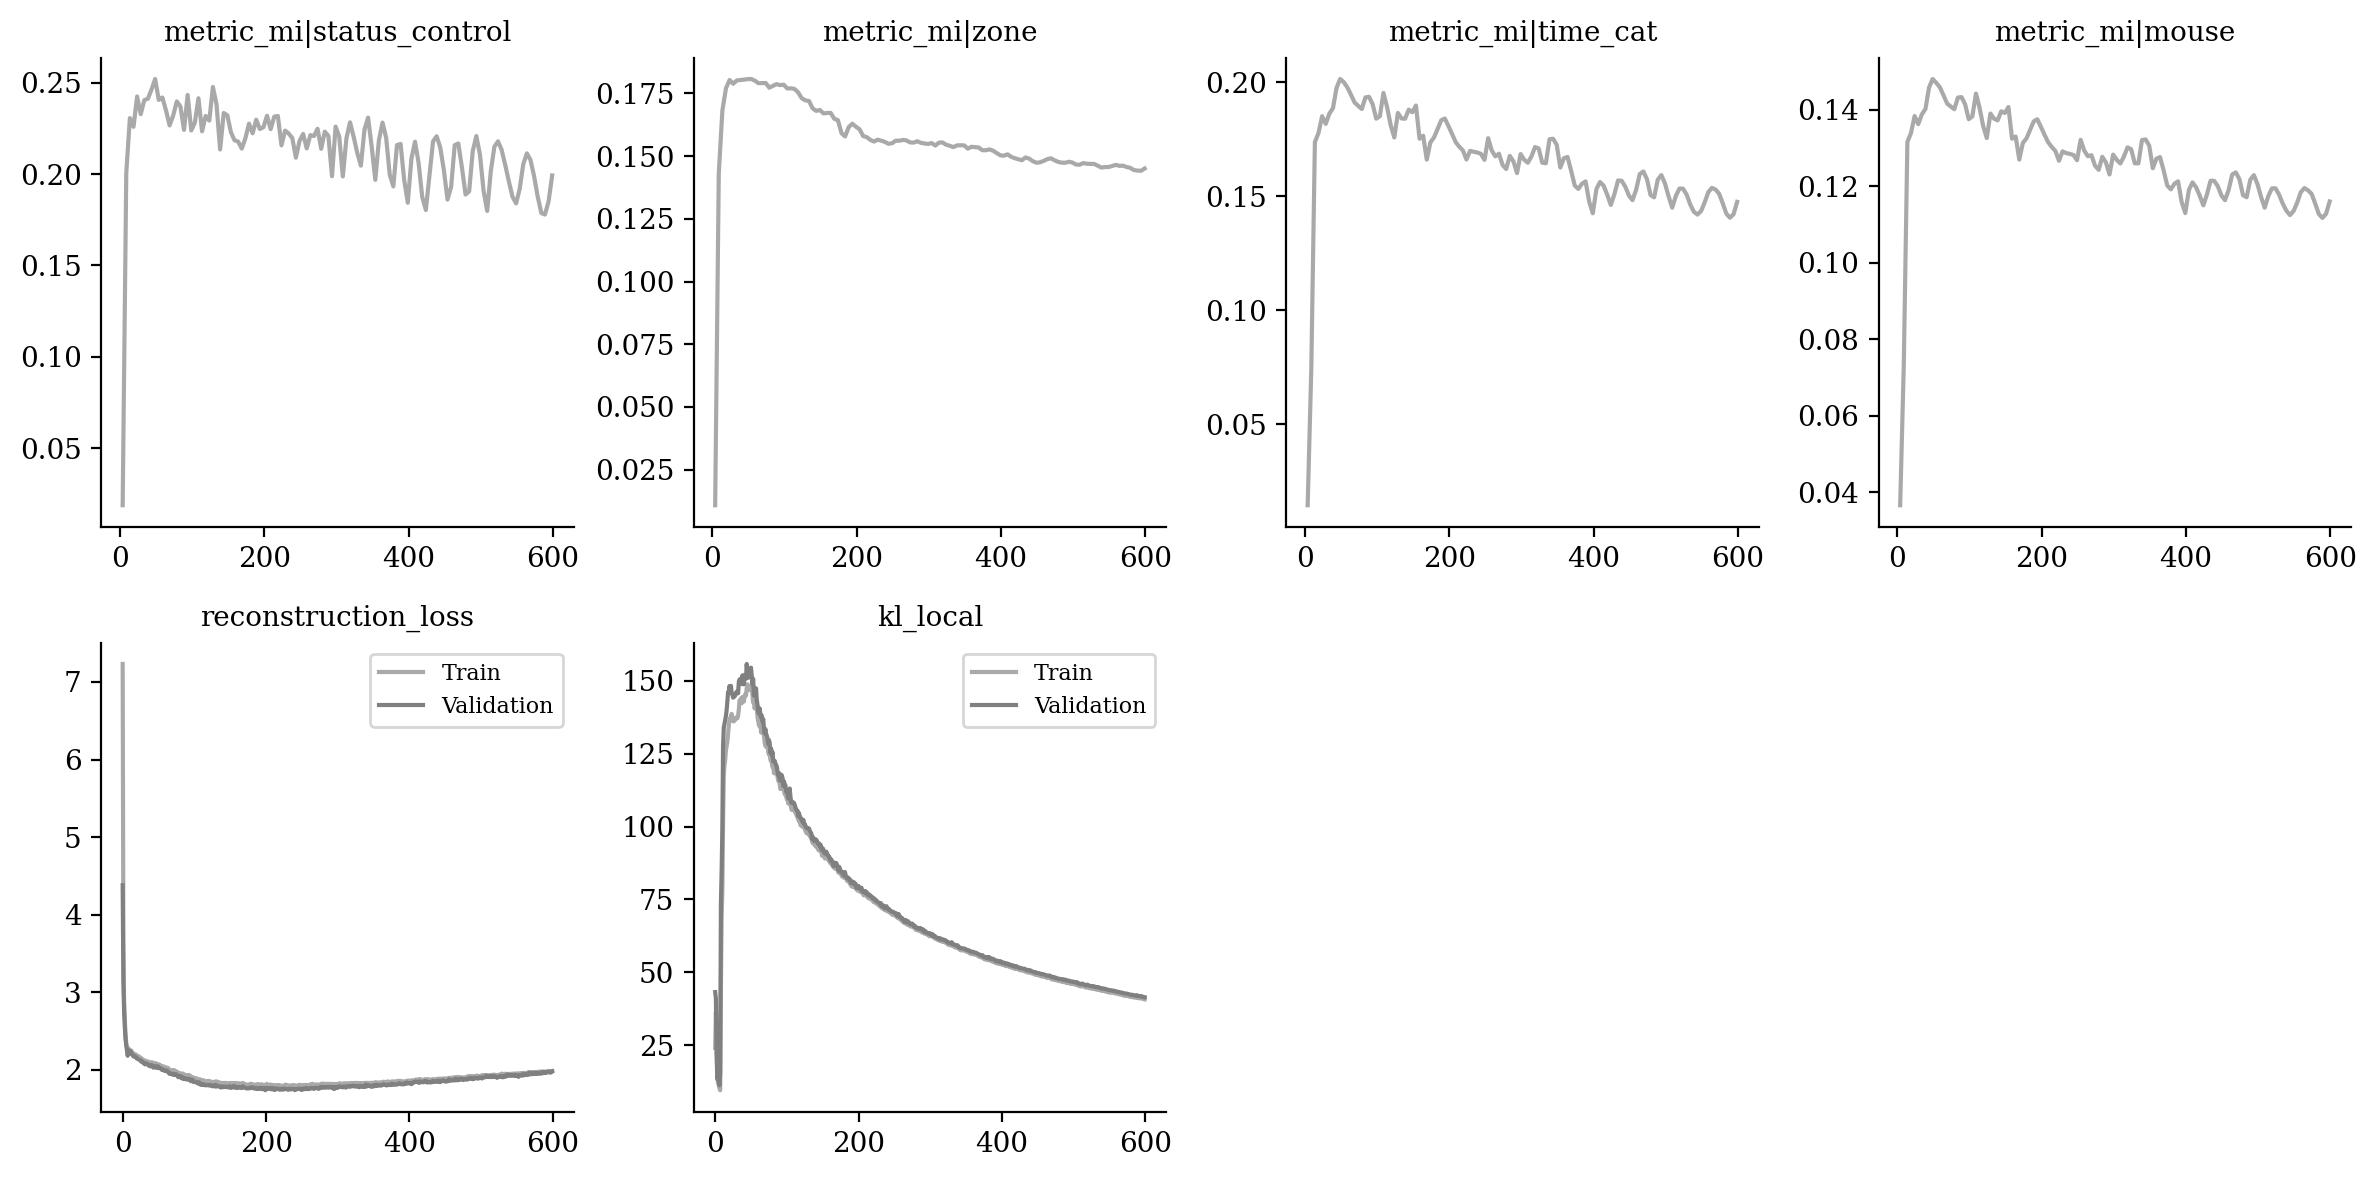

In [15]:
vae.plot_training_history(
    ignore_first=0,
    n_col=4,
    metrics_name=["metric_mi|status_control", "metric_mi|zone", "metric_mi|time_cat", "metric_mi|mouse",
                 "reconstruction_loss", "kl_local"]
)

In [16]:
from tardis._disentanglementmanager import DisentanglementManager as DM

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


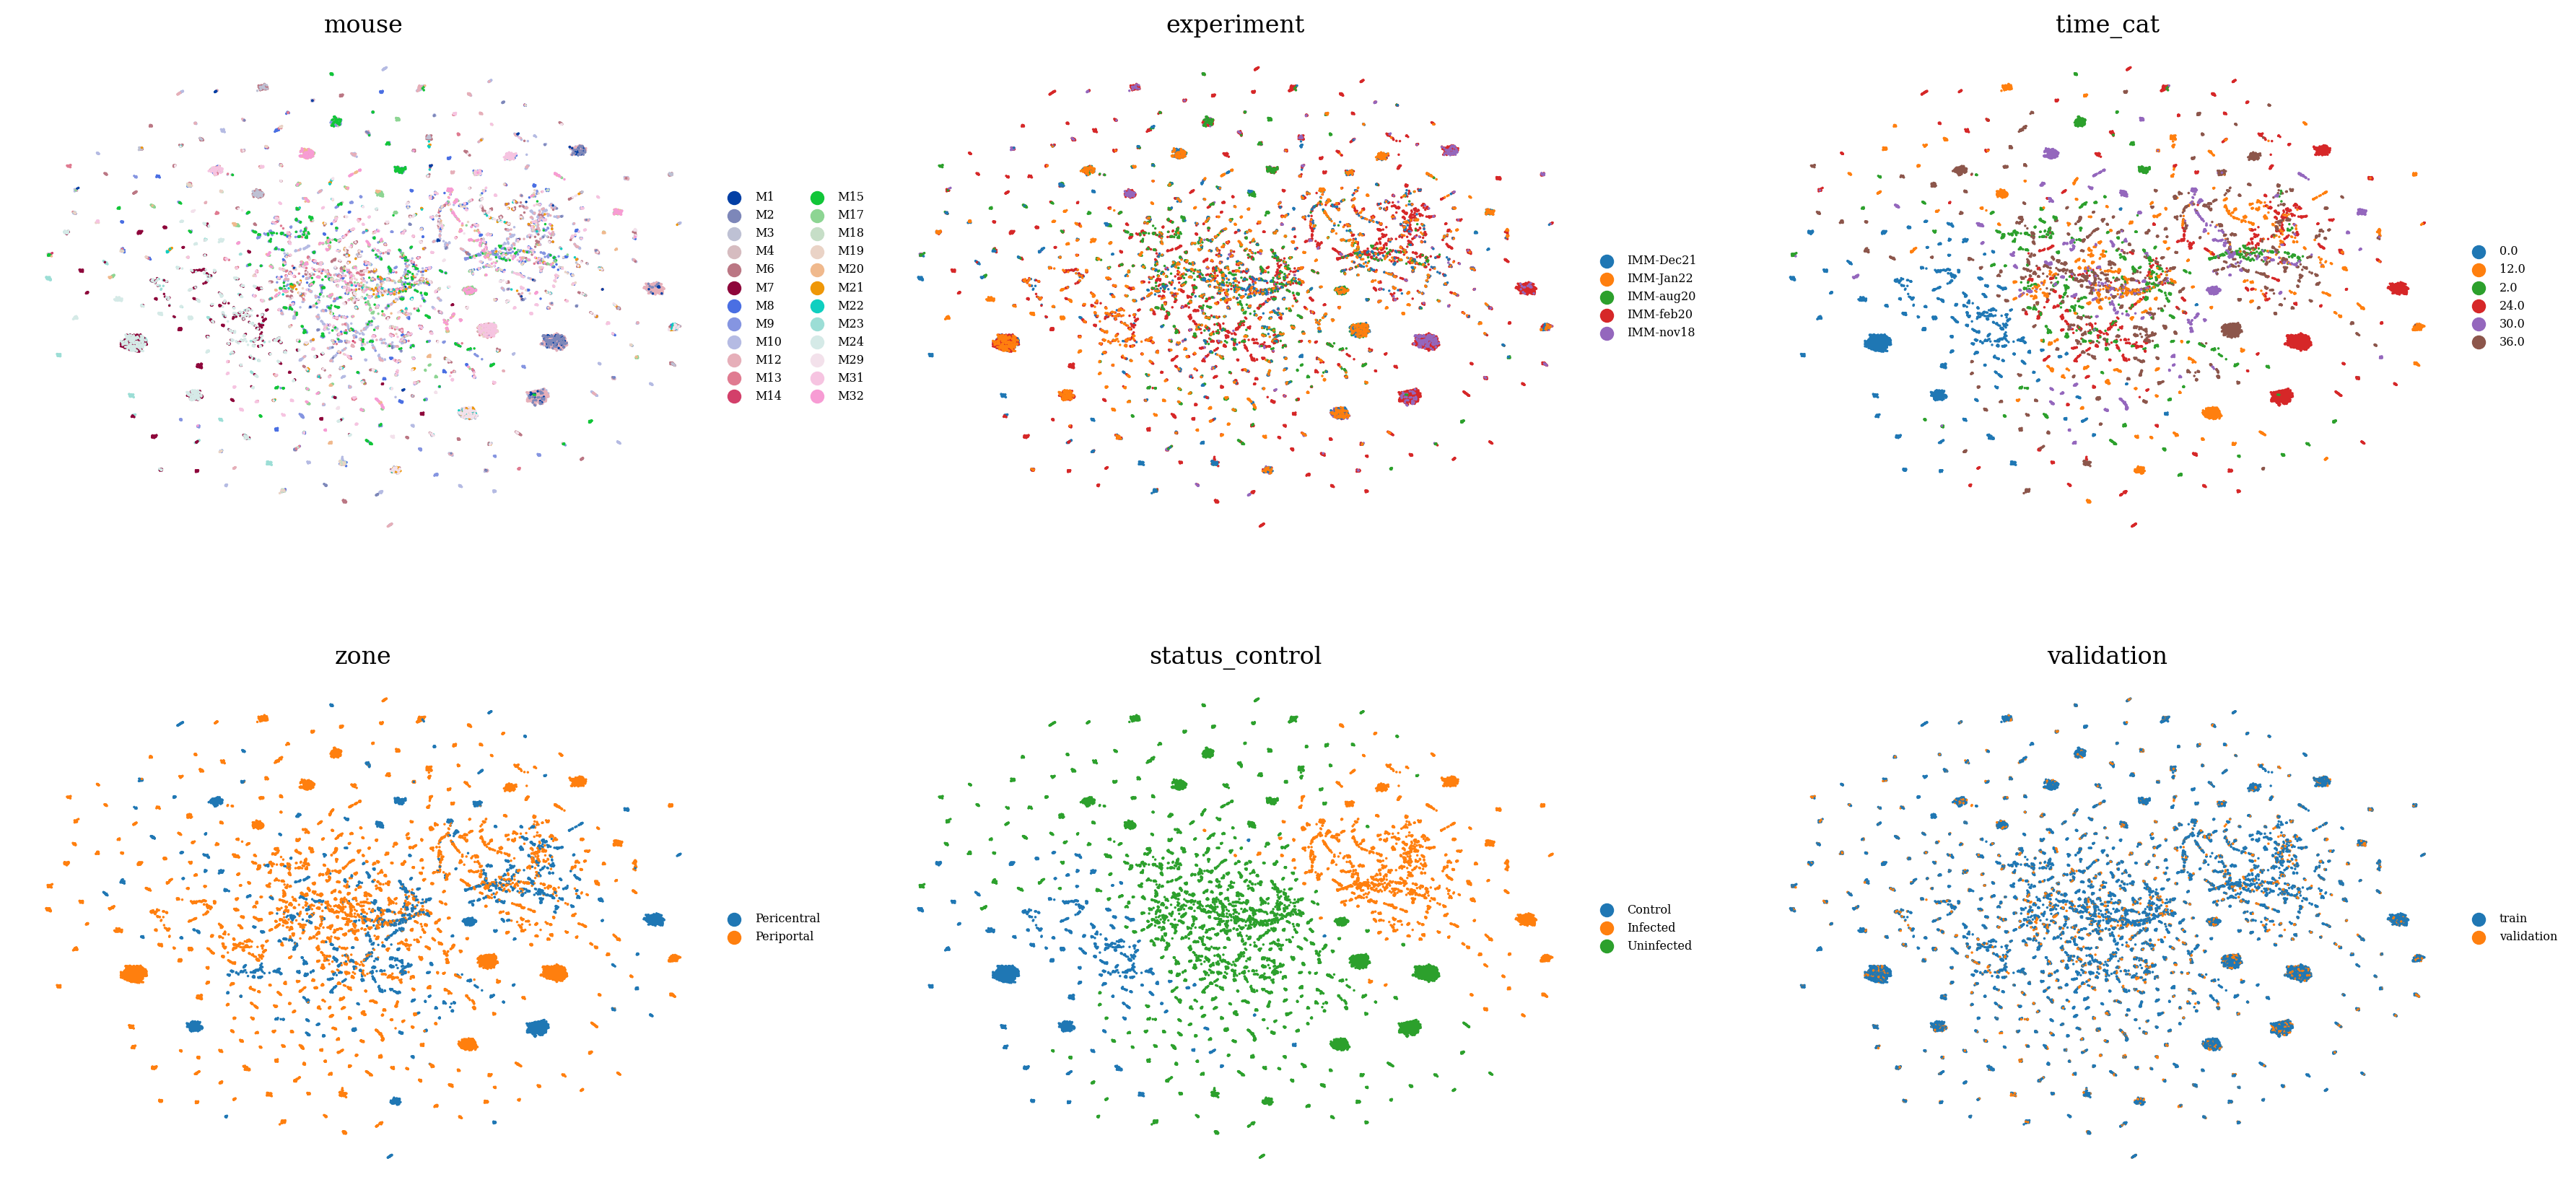

In [17]:
sublatent = DM.configurations.get_by_obs_key("status_control").reserved_latent_indices
latent = ad.AnnData(X=vae.get_latent_representation()[:, sublatent], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


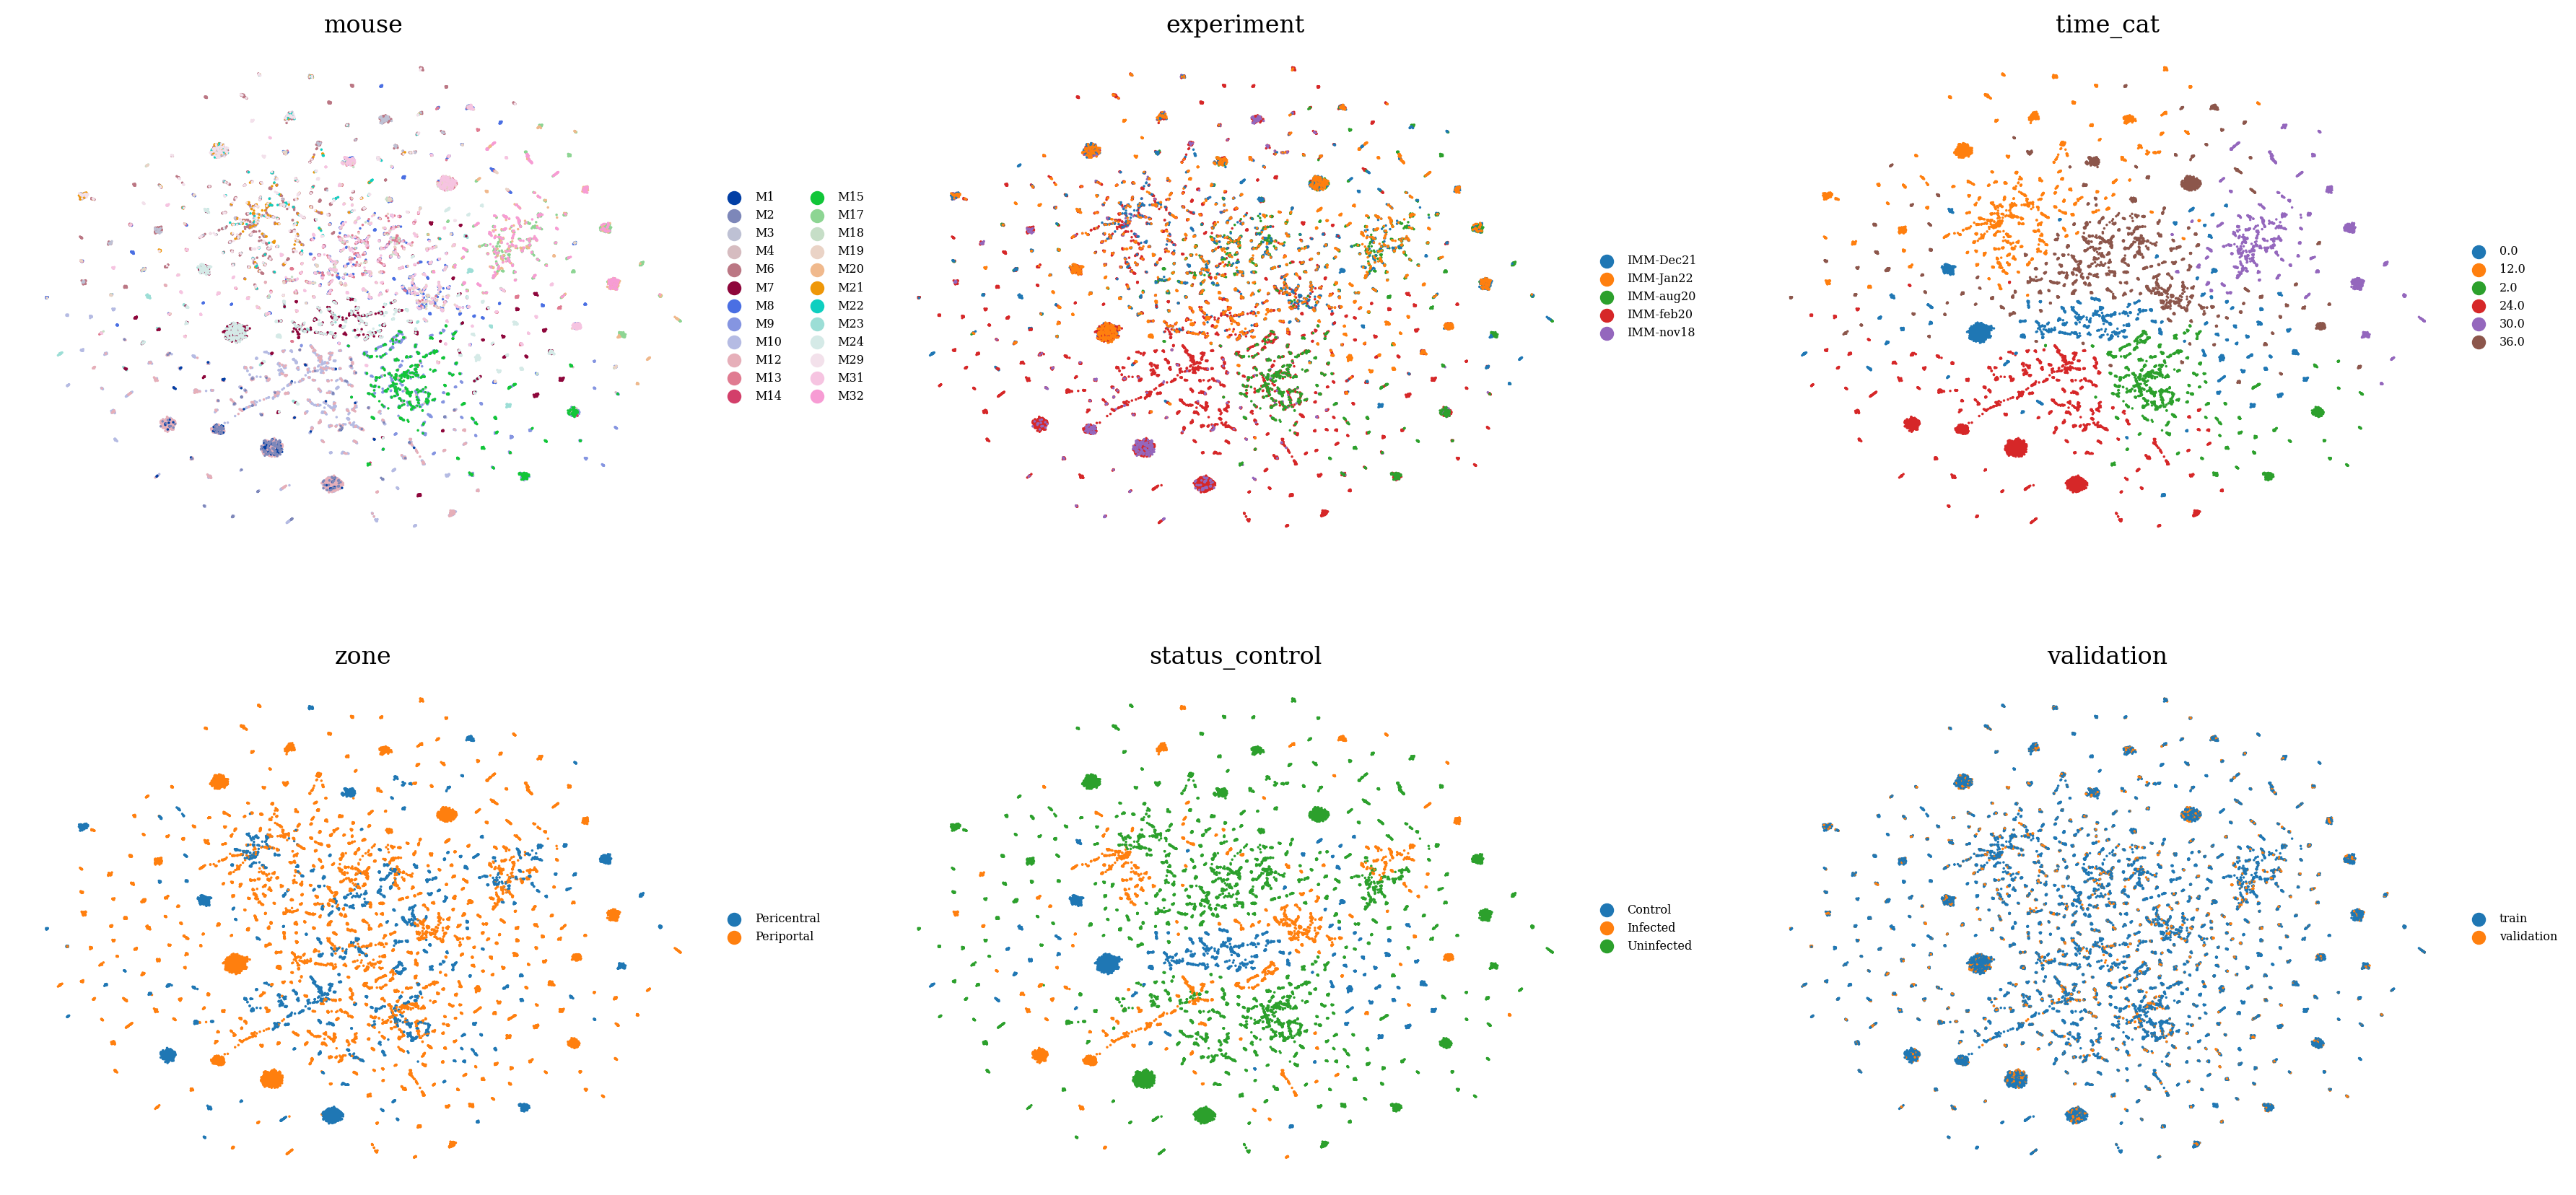

In [18]:
sublatent = DM.configurations.get_by_obs_key("time_cat").reserved_latent_indices
latent = ad.AnnData(X=vae.get_latent_representation()[:, sublatent], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


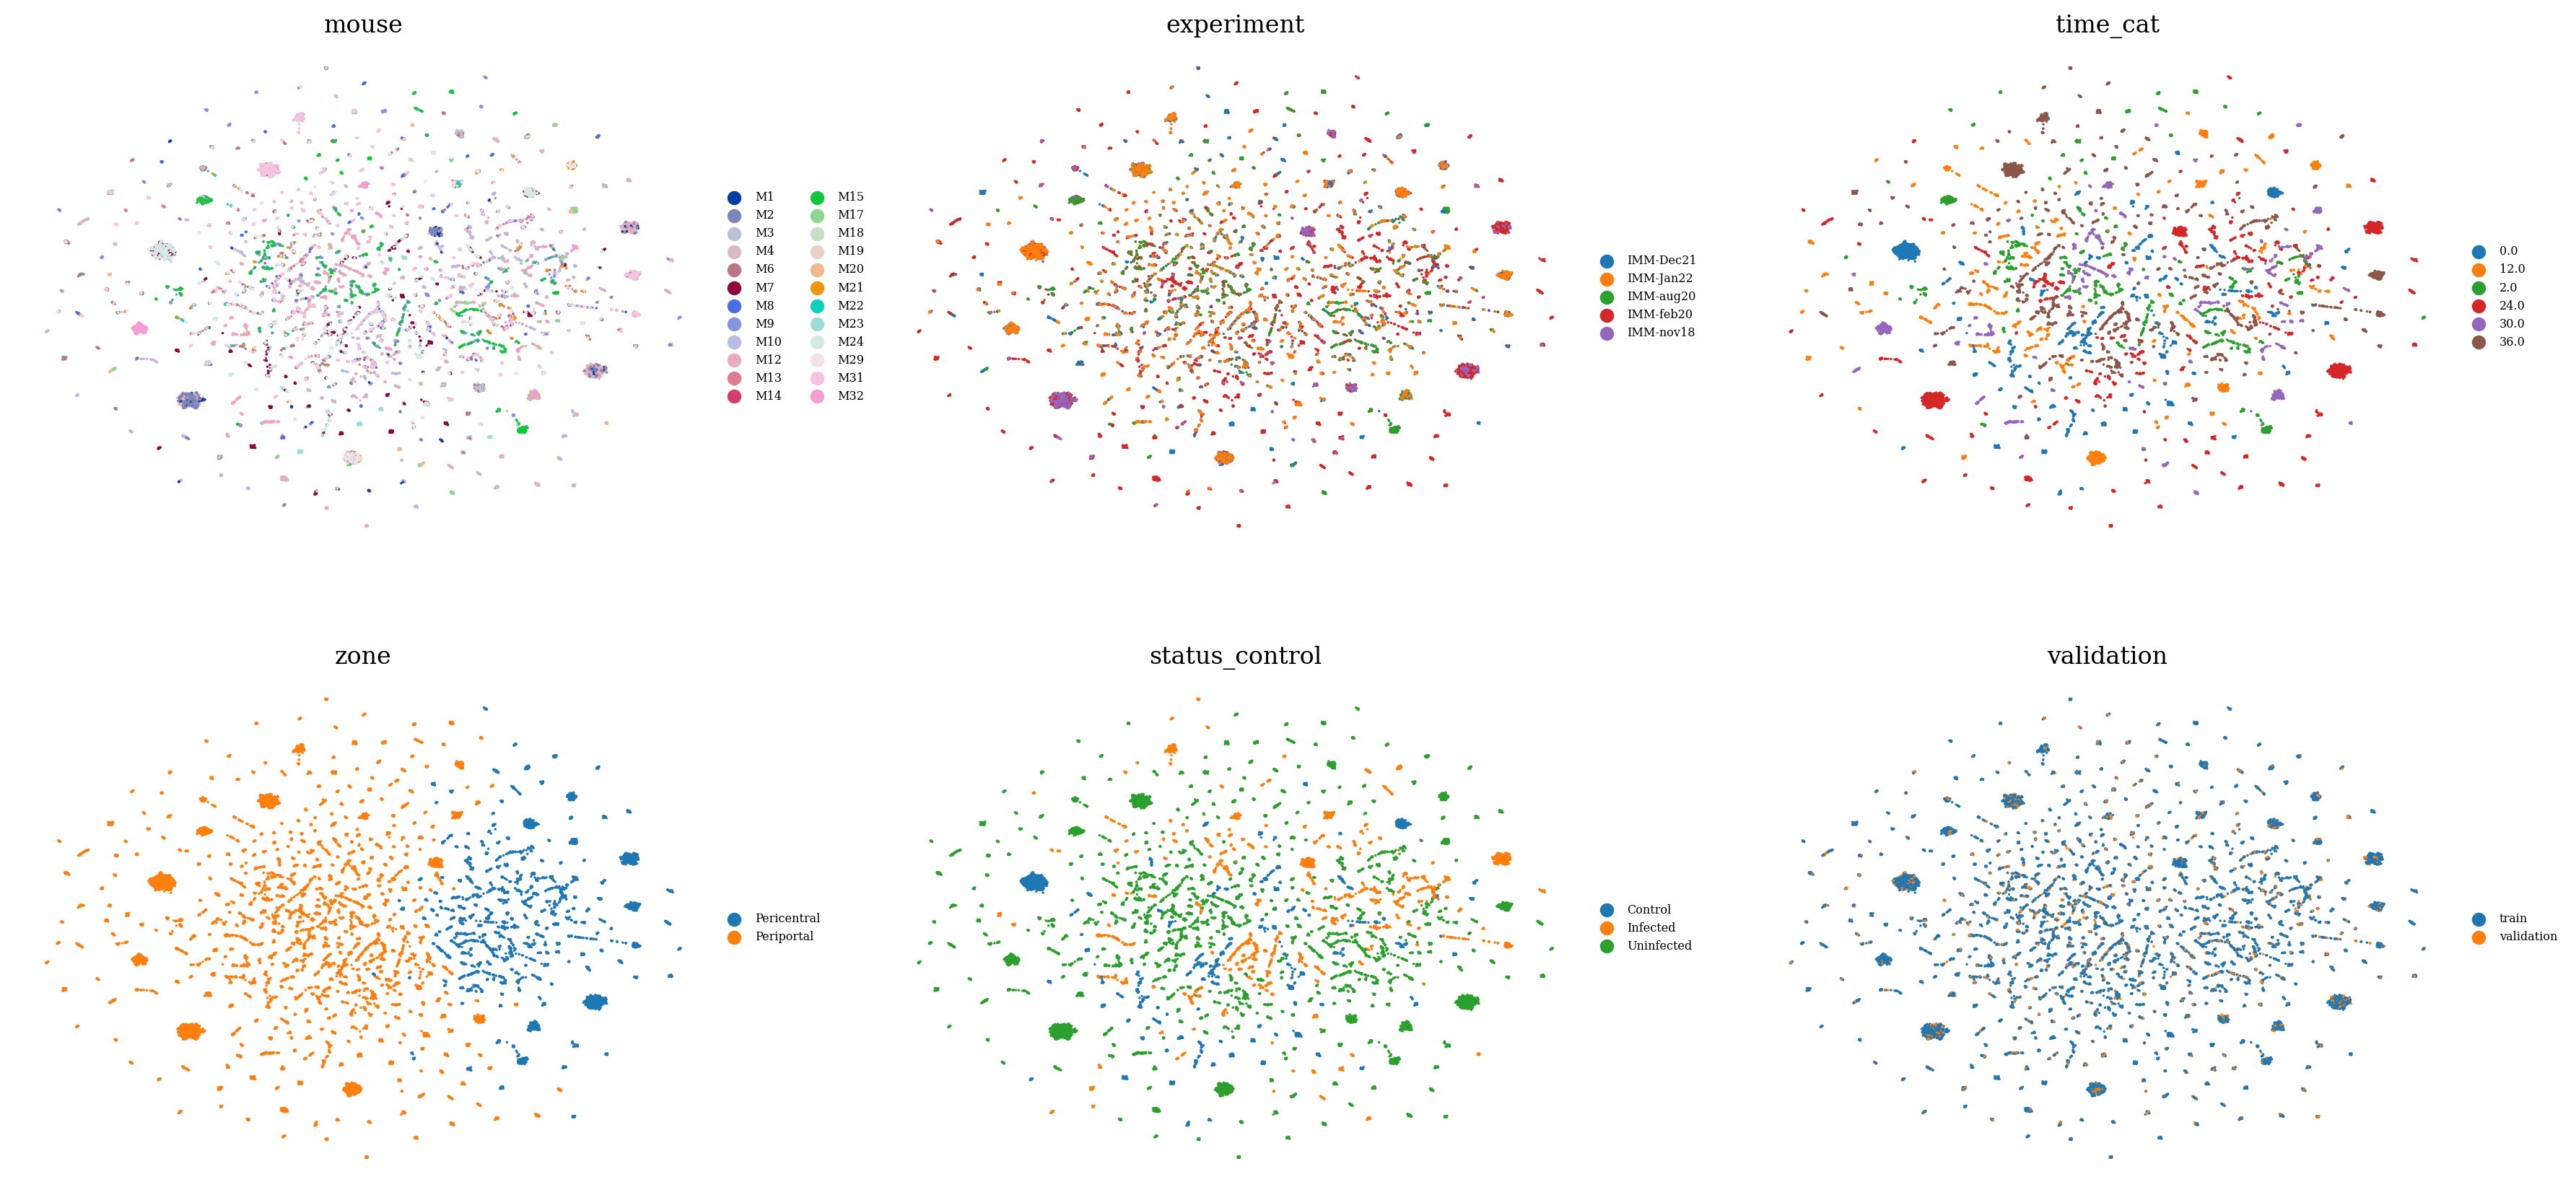

In [19]:
sublatent = DM.configurations.get_by_obs_key("zone").reserved_latent_indices
latent = ad.AnnData(X=vae.get_latent_representation()[:, sublatent], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


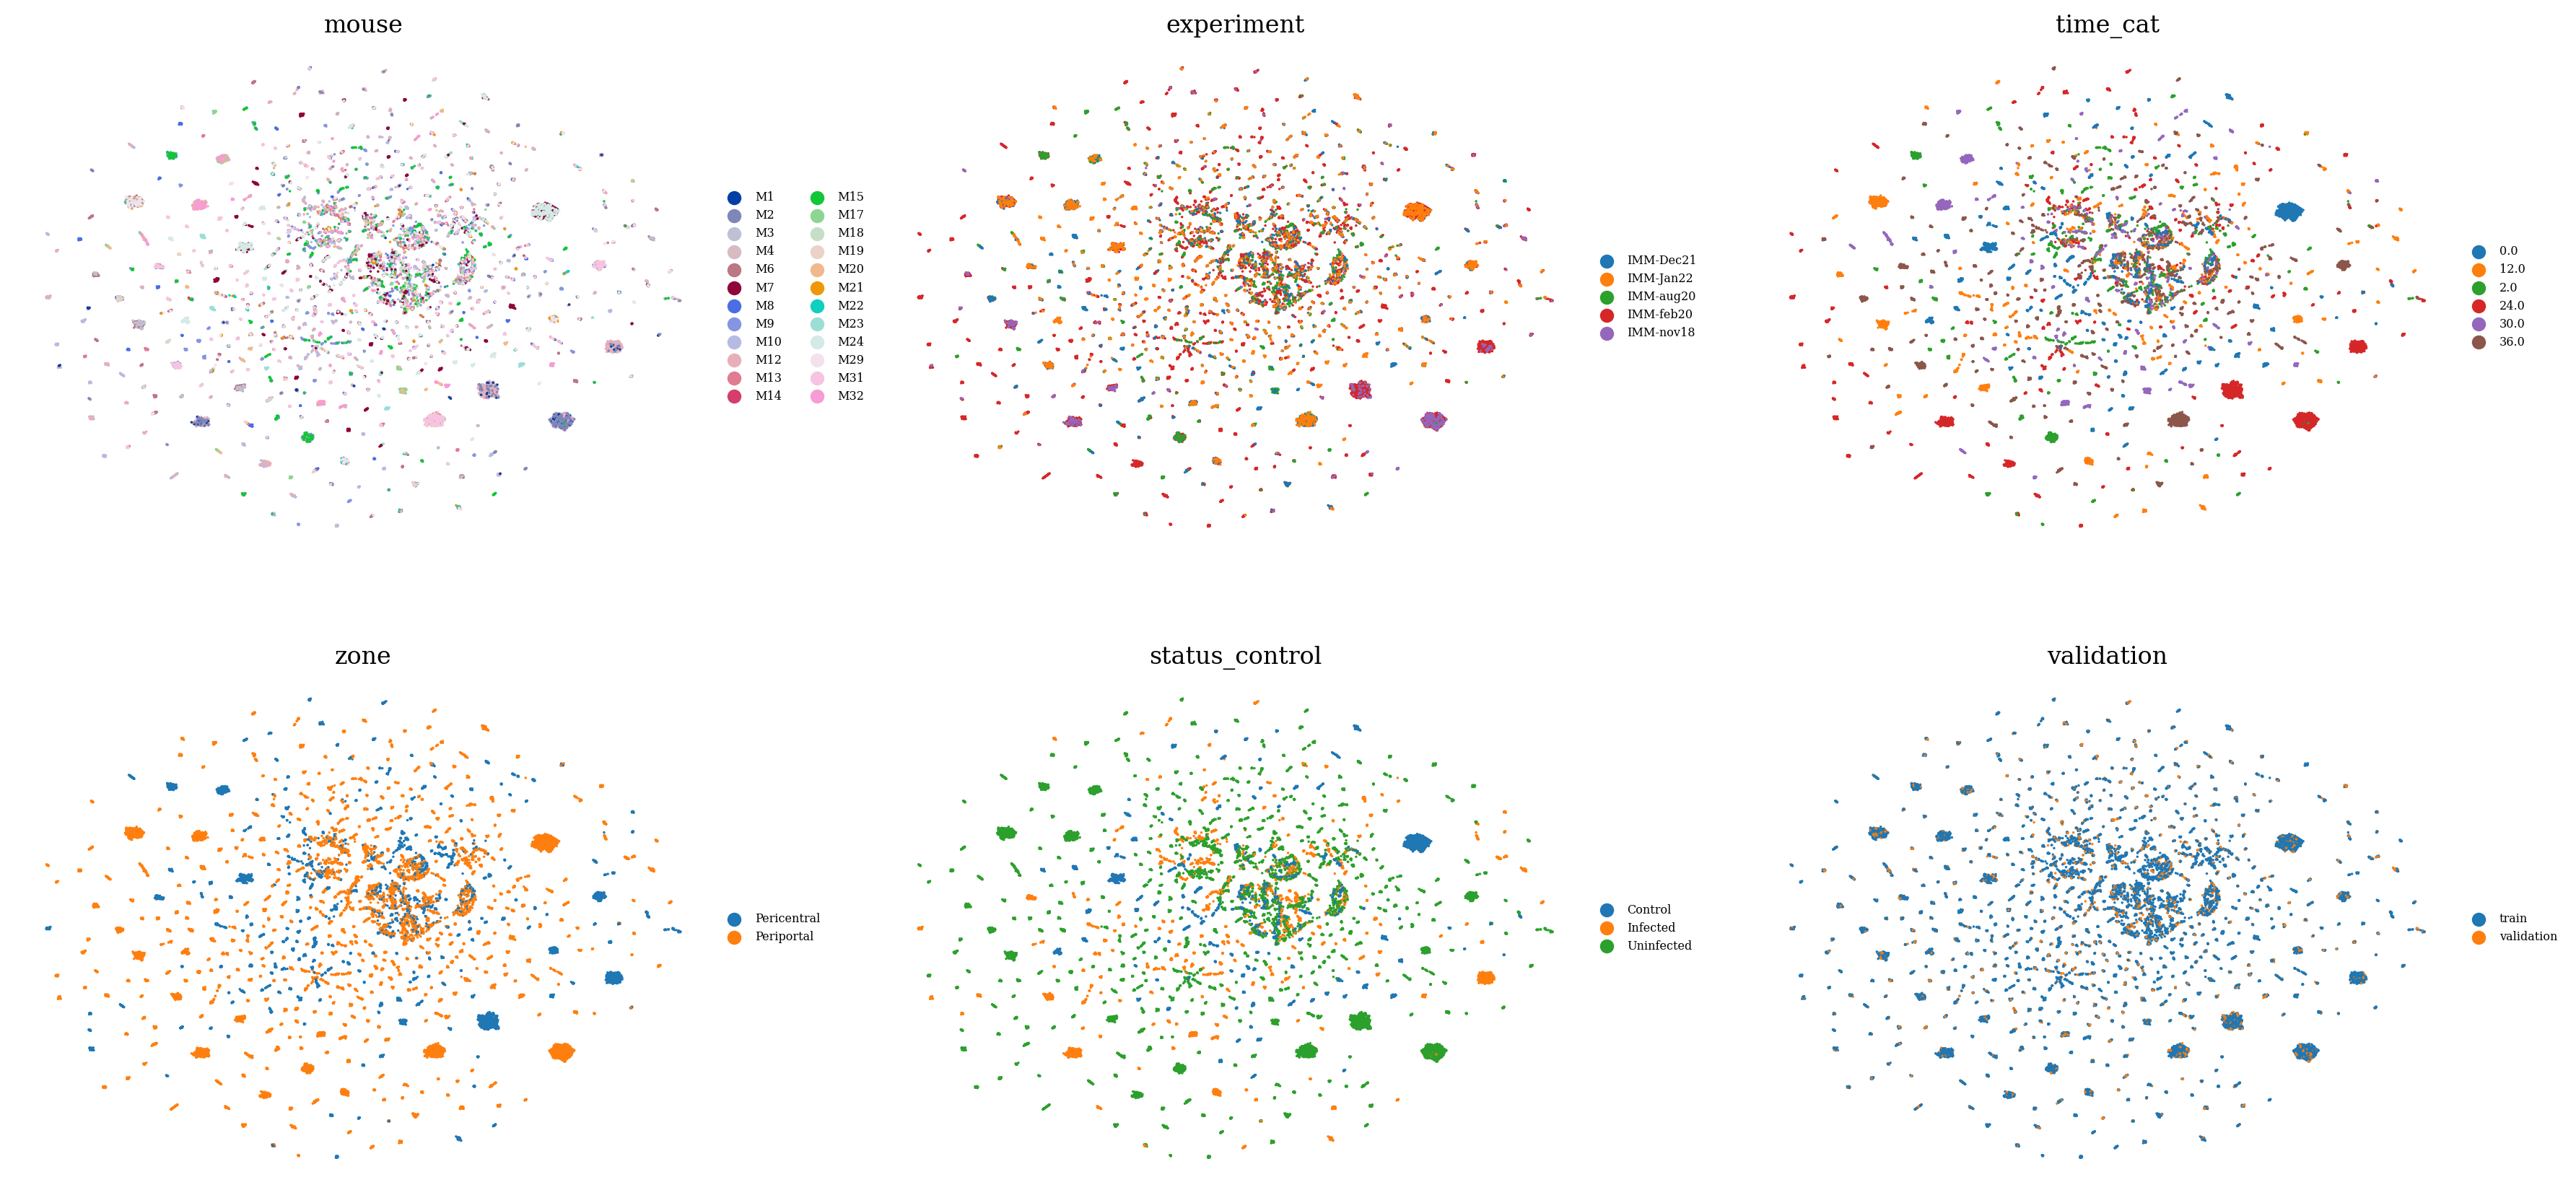

In [20]:
sublatent = DM.configurations.unreserved_latent_indices
latent = ad.AnnData(X=vae.get_latent_representation()[:, sublatent], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


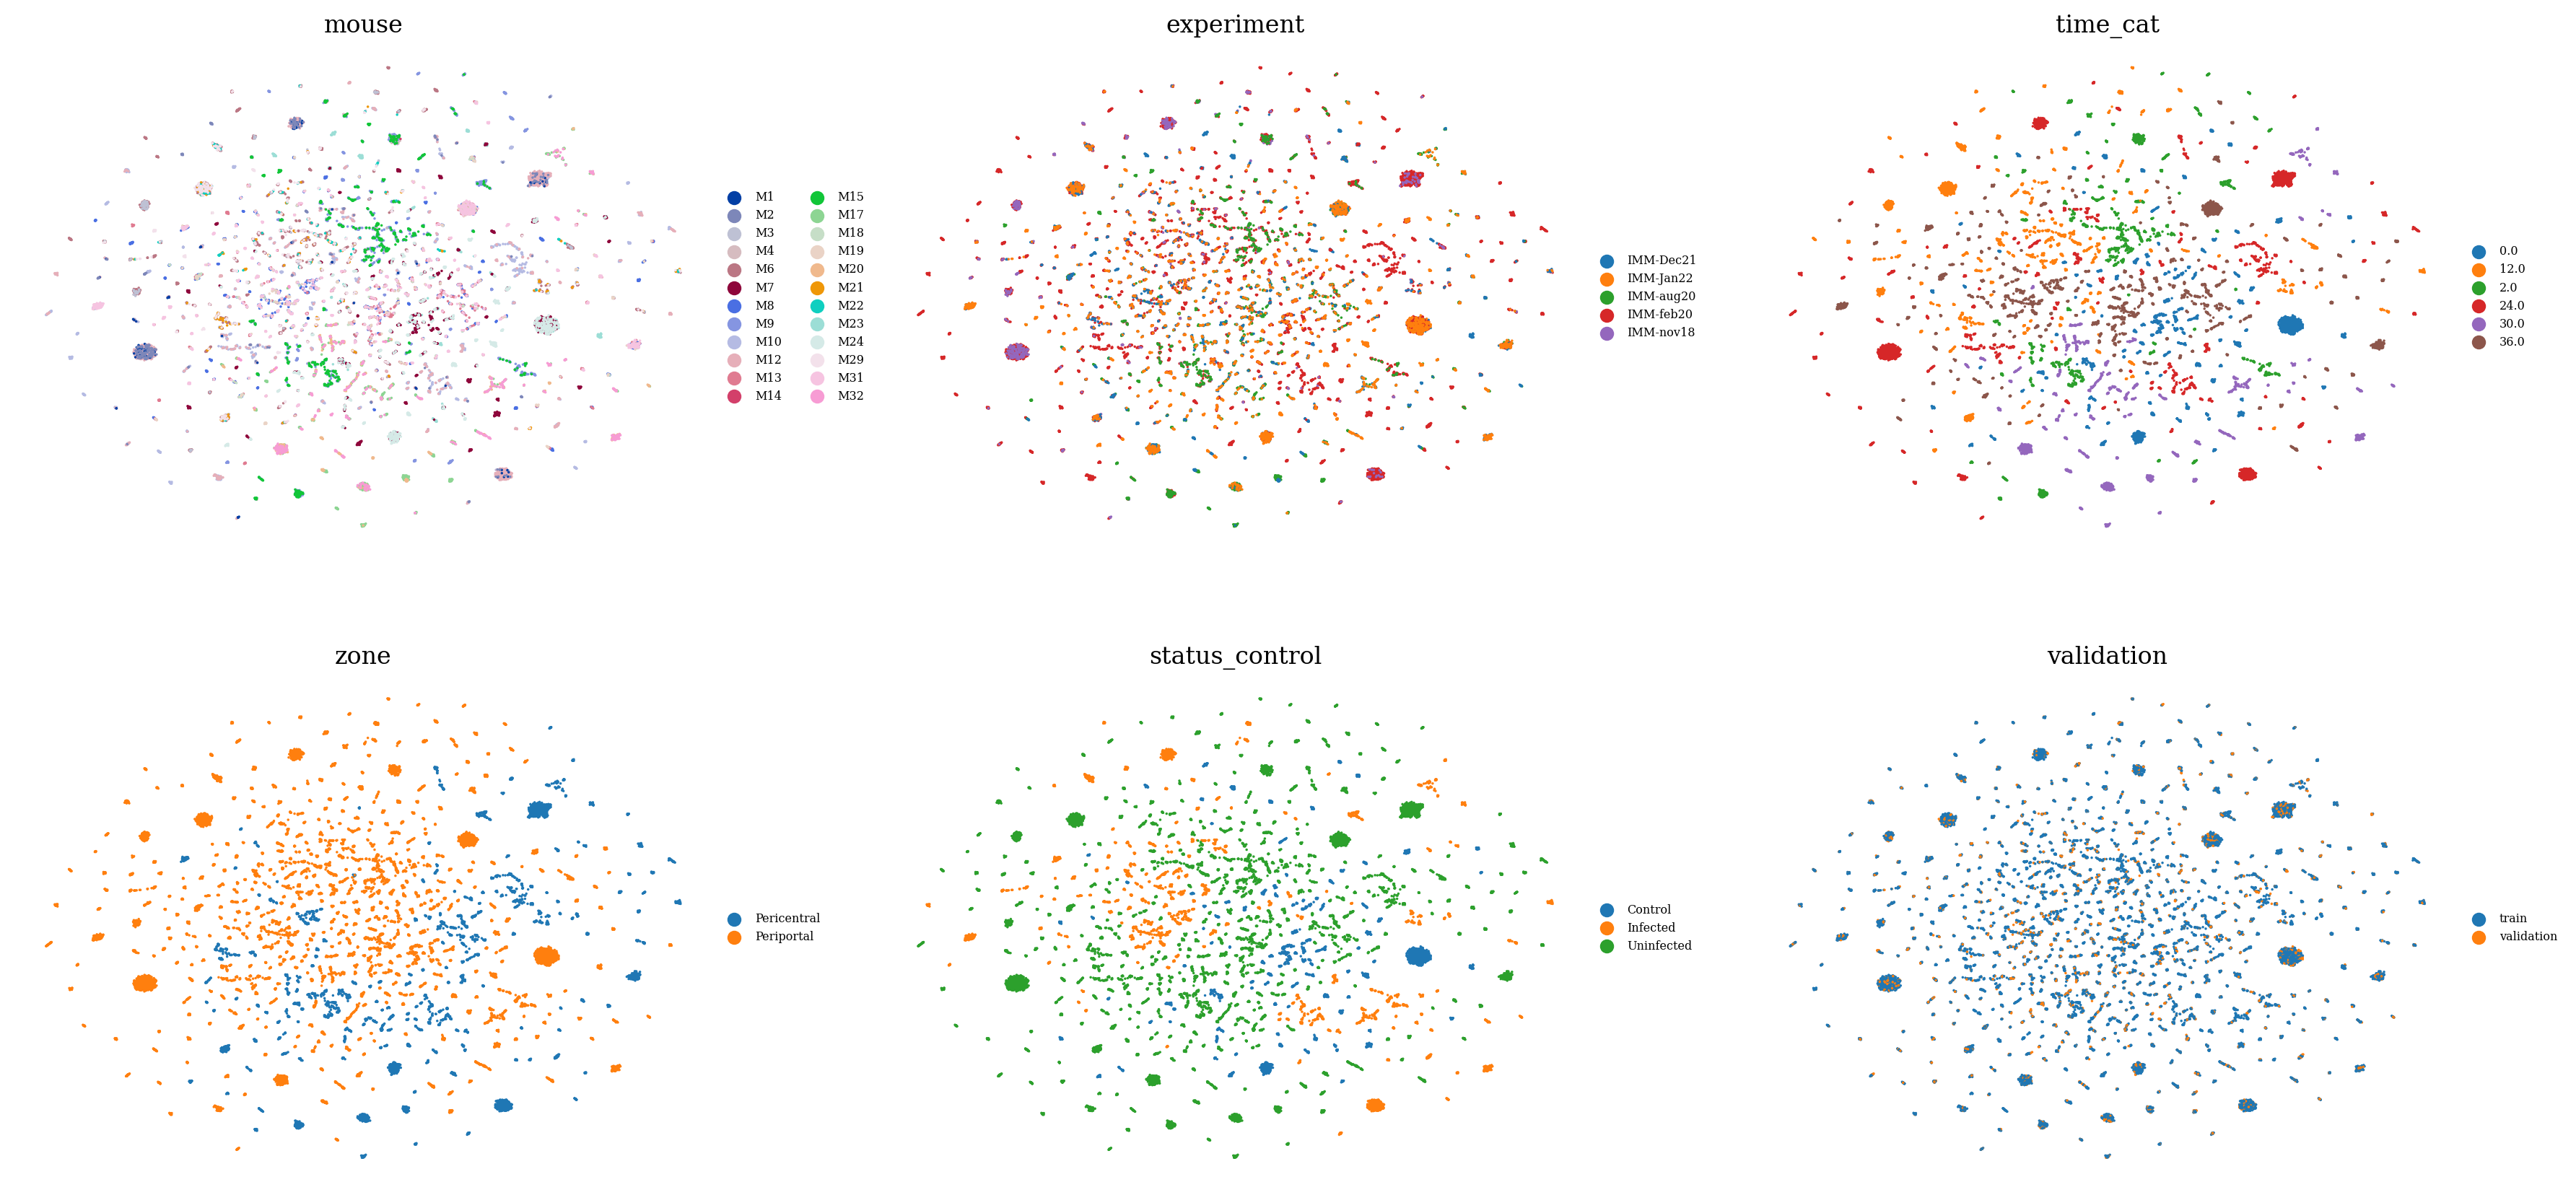

In [21]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [22]:
data = vae.get_latent_representation()

import sklearn
factors_indices = sorted([[indice, config.obs_key] for config in DM.configurations.items for indice in config.reserved_latent_indices])
factors = np.vstack([sklearn.preprocessing.LabelEncoder().fit_transform(
    adata.obs[j].copy().astype(str).values.flatten()
) for i, j in factors_indices]).T

data = data[:, [i for i, j in factors_indices]]

maxMIG = vae.get_MI_precalculated(data=data, factors=factors, variation="maxMIG", discretization_bins=256)
maxMIG_mean = np.mean(maxMIG)
maxMIG_mean

0.48064180514843424

In [23]:
data = vae.get_latent_representation()

import sklearn
factors_indices = sorted([[indice, config.obs_key] for config in DM.configurations.items for indice in config.reserved_latent_indices])
factors = np.vstack([sklearn.preprocessing.LabelEncoder().fit_transform(
    adata.obs[j].copy().astype(str).values.flatten()
) for i, j in factors_indices]).T

data = data[:, [i for i, j in factors_indices]]

maxMIG = vae.get_MI_precalculated(data=data[vae.validation_indices, :], factors=factors[vae.validation_indices, :], variation="maxMIG", discretization_bins=256)
maxMIG_mean = np.mean(maxMIG)
maxMIG_mean

0.4619961484037483

In [24]:
vae.get_MI_normalized_training("zone")

{('validation', 'reserved'): 0.9955521715059119,
 ('validation', 'unreserved'): 0.5663532508249147,
 ('train', 'reserved'): 0.995602143613348,
 ('train', 'unreserved'): 0.5396397152194975}

In [25]:
vae.get_MI_normalized_training("status_control")

{('validation', 'reserved'): 0.9947877015059683,
 ('validation', 'unreserved'): 0.6698749453144545,
 ('train', 'reserved'): 0.9956050868838062,
 ('train', 'unreserved'): 0.6393206483444522}

In [26]:
vae.get_MI_normalized_training("time_cat")

{('validation', 'reserved'): 0.9746731922028622,
 ('validation', 'unreserved'): 0.6632163478025861,
 ('train', 'reserved'): 0.9746139272489538,
 ('train', 'unreserved'): 0.6250805770597934}